# SPDR Sector ETF Analysis

What you will see in here is some high level inferential statistics, as well as many model iterations. If you prefer, you could scan this notebook, and then go to [notebook 2b](https://github.com/dvdhartsman/Stock_Market_Analysis/blob/main/2b_SPDR_Eval.ipynb) for the conclusions. This notebook will essentially be a continuation of the previous notebook that tracked the performance of market indexes qualitatively over different time horizons. This notebook will still address the same time horizons, however because these ETFs represent more specific sectors of the stock market, their performances may diverge from the behavior observed and modeled in the previous notebook.

### Notebook Analysis Layout:
- Inferential EDA/Data Understanding
- Materials 1, 3, 6, 12 Month Modeling
- Energy 1, 3, 6, 12 Month Modeling
- Financials 1, 3, 6, 12 Month Modeling
- Industrials 1, 3, 6, 12 Month Modeling
- Technology 1, 3, 6, 12 Month Modeling
- Staples 1, 3, 6, 12 Month Modeling
- Utilities 1, 3, 6, 12 Month Modeling
- Health Care 1, 3, 6, 12 Month Modeling
- Consumer Discretionary 1, 3, 6, 12 Month Modeling
- Real Estate 1, 3, 6, 12 Month Modeling
- Communication Services 1, 3, 6, 12 Month Modeling
- ##### Final Summary

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 50)
sns.set_style("dark")

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### New container for feature importances

In [3]:
# Class for collecting coefficients of models based on economic features

class Importance():
    df = pd.DataFrame(columns=['Adj Close', 'Close', 'High', 'Low','Open', 'Volume', 'GDP_Filled',\
                               'Interest_Rates','Mkt-RF','SMB','HML','RMW','CMA','garman_klass_vol','RSI', \
                               'lowest_bollinger_band', 'lower_bollinger_band', '20_day_SMA', \
                               'one_up_bollinger_band','upper_bollinger_band', 'ATR', 'MACD', 'dollar_volume(M)',\
                               'Quarter_1','Quarter_2','Quarter_3','Quarter_4','Month_1','Month_10','Month_11',\
                               'Month_12','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8',\
                               'Month_9','cycle_year_1','cycle_year_2','cycle_year_3','cycle_year_4',\
                               'day_of_week_Friday','day_of_week_Monday','day_of_week_Thursday',\
                               'day_of_week_Tuesday','day_of_week_Wednesday'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        


In [4]:
# These functions add changes in percentage at the target dates

def one_month_price_change(df, num="One"):
    for ticker in list(df["Ticker"].unique()):
        ticker_df = df[df["Ticker"] == ticker]

        for index, row in ticker_df.iterrows():
            try:
                one_month_later_value = row[f"{num.lower()}_months_later"]
                if not pd.isna(one_month_later_value):
                    ticker_df.at[index, f"{num}_Month_Change"] = (ticker_df.loc[one_month_later_value, "Adj Close"] - row["Adj Close"]) / row["Adj Close"]
                else:
                    # Handle the case where one_month_later is NaN (NaT)
                    ticker_df.at[index, f"{num}_Month_Change"] = np.nan
            except KeyError:
                # Handle the KeyError exception here if necessary
                ticker_df.at[index, f"{num}_Month_Change"] = np.nan
           
        df.loc[df["Ticker"] == ticker, f"{num}_Month_Change"] = ticker_df[f"{num}_Month_Change"]
    
    return df



def three_month_price_change(df, num="Three"):
    return one_month_price_change(df, num)
    
    
def six_month_price_change(df, num="Six"):
    return one_month_price_change(df, num)


def twelve_month_price_change(df, num="Twelve"):
    return one_month_price_change(df, num)

<hr style="border: 3px solid black">

# SPDR Data

The term "SPDR" stands for "Standard & Poor's Depositary Receipts." These ETFs were literally the first Exchange Traded Funds offered to the public markets that allowed investors to gain access to large sectors of the market or entire indices depending on your preference. As the previous notebook analyzed the major market indices, this notebook will focus on the sector indices to provide a different perspective. The process for modeling will be largely the same. Because so many of the models from the previous notebook performed so well without overfitting, I did not tune them using GridsearchCV. Depending on performances in this notebook, there may be more tuning.

In [13]:
# Loading the data

df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_DATA_W_ADDED.csv')
print(df.shape)
df.head(15)

(56246, 41)


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1999-01-29,XLB,12.173973,21.109375,21.109375,20.953125,20.953125,400.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.113866,45.359196,11.895113,12.260720,12.626326,12.991933,13.357539,0.428209,-0.181913,0.0049,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.003700,0.304891,0.224777,0.120443,1.0,1.0,1.0,1.0
1,1999-01-29,XLE,11.670672,21.812500,21.812500,21.437500,21.687500,18600.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.148177,31.112318,11.538886,11.886097,12.233309,12.580520,12.927731,0.420353,-0.327214,0.2171,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.018624,0.321353,0.294086,0.272486,0.0,1.0,1.0,1.0
2,1999-01-29,XLF,11.877566,19.369415,19.394800,18.810926,19.077478,72998.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.086272,53.698896,11.237432,11.515857,11.794283,12.072709,12.351135,0.441194,-0.100745,0.8670,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.019659,0.138006,0.056829,-0.020673,1.0,1.0,1.0,0.0
3,1999-01-29,XLI,15.624509,24.296875,24.406250,23.953125,24.234375,109200.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.074248,54.474621,15.080736,15.377490,15.674243,15.970996,16.267750,0.354799,-0.094967,1.7062,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.008360,0.199315,0.202136,0.131147,1.0,1.0,1.0,1.0
4,1999-01-29,XLK,28.604773,37.812500,37.843750,36.937500,37.375000,933600.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.027333,69.725520,24.579485,25.563477,26.547469,27.531461,28.515453,1.158526,1.039131,26.7054,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.103306,-0.018595,0.069421,0.337216,0.0,0.0,1.0,1.0
5,1999-01-29,XLP,15.135293,26.796875,26.984375,26.437500,26.812500,167800.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.126109,54.912532,14.189066,14.545906,14.902747,15.259588,15.616429,0.570857,-0.174861,2.5397,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.015161,-0.033281,-0.069888,-0.123416,0.0,0.0,0.0,0.0
6,1999-01-29,XLU,12.437774,29.484375,29.656250,29.203125,29.531250,39800.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.288723,45.545589,12.289195,12.461860,12.634525,12.807191,12.979856,0.575213,-0.079041,0.4950,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.041865,0.012445,0.053542,-0.037186,0.0,1.0,1.0,0.0
7,1999-01-29,XLV,19.057581,27.250000,27.281250,26.906250,27.281250,13800.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.049617,61.773293,18.151676,18.458203,18.764730,19.071257,19.377784,0.495886,0.277835,0.2630,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.000573,0.072248,0.051606,0.111398,0.0,1.0,1.0,1.0
8,1999-01-29,XLY,20.654898,27.468750,27.562500,27.187500,27.375000,6800.0,9411.682,4.37,0.0095,0.0010,-0.0062,0.0044,-0.0057,-0.030556,65.978046,19.308743,19.664002,20.019262,20.374521,20.729780,0.439908,0.242114,0.1405,1,1,3,Friday,1999-03-01,1999-04-29,1999-07-29,2000-01-31,-0.005689,0.072836,0.025242,-0.004598,0.0,1.0,1.0,0.0
9,1999-02-01,XLB,12.273088,21.281250,21.500000,21.281250,21.281250,2900.0,9411.682,4.42,-0.0039,-0.0002,-0.0016,-0.0015,-0.0041,-0.116979,47.631201,11.860719,12.234286,12.607853,12.981421,13.354988,0.425067,-0.176432,0.0356,1,2,3,Monday,1999-03-01,1999-05-03,1999-08-02,2000-02-01,-0.004405,0.308350,0.219320,0.131493,0.0,1.0,1.0,1.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56246 entries, 0 to 56245
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   56246 non-null  object 
 1   Ticker                 56246 non-null  object 
 2   Adj Close              56246 non-null  float64
 3   Close                  56246 non-null  float64
 4   High                   56246 non-null  float64
 5   Low                    56246 non-null  float64
 6   Open                   56246 non-null  float64
 7   Volume                 56246 non-null  float64
 8   GDP_Filled             56246 non-null  float64
 9   Interest_Rates         56246 non-null  float64
 10  Mkt-RF                 56246 non-null  float64
 11  SMB                    56246 non-null  float64
 12  HML                    56246 non-null  float64
 13  RMW                    56246 non-null  float64
 14  CMA                    56246 non-null  float64
 15  ga

In [15]:
# Feature Transformations and additions

df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df['Quarter'].astype(str)
df["cycle_year"] = df["cycle_year"].astype(str)
df['Month'] = df['Month'].astype(str)
df.set_index("Date", inplace=True)

In [16]:
df.shape

(56246, 40)

In [15]:
# Cell creates a dataframe of the NORMALIZED value counts for each ETF and each time target

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XLRE', 'XLC']

# Value Counts for Targets of Each SPDR

values = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values.loc[num] = (df[df["Ticker"]==i]['One_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 3 Month Target

values3 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values3.loc[num] = (df[df["Ticker"]==i]['Three_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 6 Month Target

values6 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values6.loc[num] = (df[df["Ticker"]==i]['Six_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 12 Month Target

values12 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values12.loc[num] = (df[df["Ticker"]==i]['Twelve_Month_Positive'].value_counts(normalize=True)*100).round(2)

# Concat all DFs
    
value_cnts = pd.concat([values, values3, values6, values12], axis=1)

super_column_titles = ['One', 'Month', 'Three', 'Month', 'Six', 'Month', 'Twelve', 'Month']

multi_index = pd.MultiIndex.from_tuples(list(zip(super_column_titles, value_cnts.columns)))

value_cnts.columns = multi_index

value_cnts.rename(index={0:'XLB', 1:'XLE', 2:'XLF', 3:'XLI', 4:'XLK', 5:'XLP', 6:'XLU', 7:'XLV', 8:'XLY',
       9:'XLRE', 10:'XLC'}, inplace=True)

# Value Counts of ETFs for each time horizon

value_cnts

,One,Month,Three,Month,Six,Month,Twelve,Month
,0,1,0,1,0,1,0,1
XLB,39.78,60.22,35.86,64.14,32.09,67.91,29.44,70.56
XLE,42.73,57.27,37.70,62.30,35.37,64.63,33.70,66.30
XLF,41.57,58.43,35.89,64.11,35.98,64.02,36.42,63.58
XLI,39.95,60.05,34.28,65.72,32.36,67.64,25.35,74.65
XLK,39.13,60.87,33.30,66.70,30.39,69.61,24.89,75.11
XLP,37.36,62.64,31.99,68.01,26.24,73.76,18.31,81.69
XLU,38.03,61.97,33.52,66.48,29.00,71.00,22.64,77.36
XLV,38.42,61.58,32.47,67.53,31.24,68.76,23.23,76.77
XLY,37.73,62.27,34.58,65.42,30.87,69.13,25.13,74.87


### Interpretation of the above table:

As you can see, the longer the time horizon, the more likely that any ETF will have increased in value. XLRE and XLF, real estate and financials respectively, each failed to perform better over 6 months compared to 3 months, but those are literally the only exceptions. XLRE and XLC also have not existed for as long as these other SPDR funds, and therefore there is a bit less data for those two ETFs.

# Visual Inspection

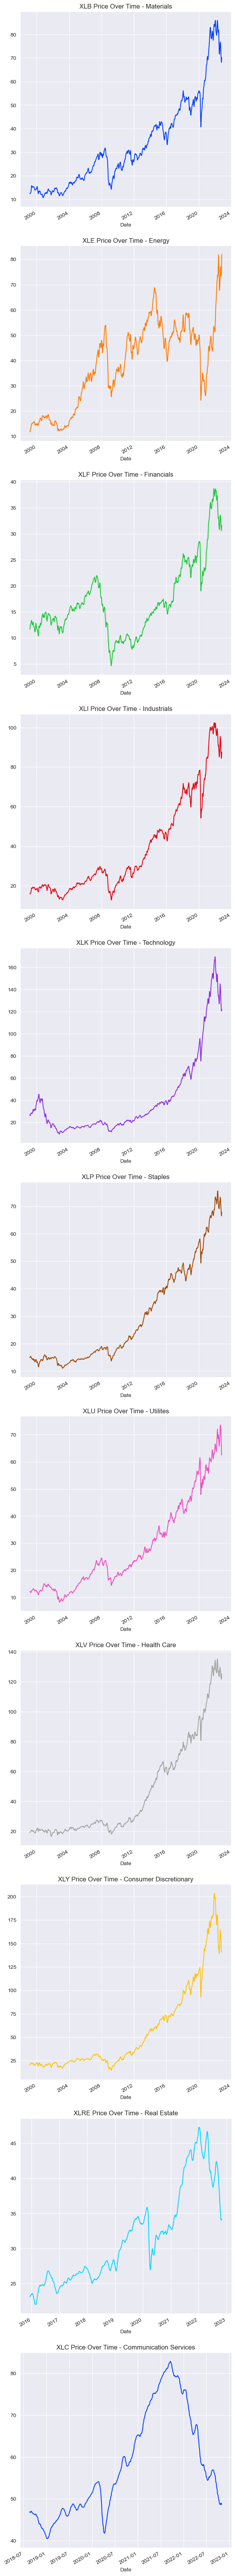

In [16]:
# Plotting price over time
sns.set_style("darkgrid")
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

palette = sns.color_palette("bright", n_colors=11)
fig, ax = plt.subplots(nrows=11, figsize=(7,96))

for num, i in enumerate(tickers):
    df[df["Ticker"]==i]["Adj Close"].rolling(window=20).mean().\
    plot(kind="line", color=palette[num], title=f"{i} Price Over Time - {sectors[num]}", ax=ax[num])

### Monthly Statistics

In [17]:
df.reset_index(inplace=True)
df.set_index(["Date", "Ticker"], inplace=True)

##### Keep in mind that XLC and XLRE do not have as much data, and so their performance might be noisy

In [18]:
# XLE has highest average monthly stock gain not accounting for dividends/expenses

# Creates multi-index columns, then re-structures the df by Monthly groups
monthly_data = df.unstack("Ticker").resample('M')

# Subtract the price at month's end from the price and month's start divided by price at month's start * 100 for %
monthly_percentage_change = monthly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Sort the last of mean percentage monthly gains
monthly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     0.735920
XLI     0.721174
XLRE    0.699393
XLV     0.663228
XLY     0.657240
XLB     0.617715
XLU     0.592624
XLK     0.530358
XLF     0.476599
XLP     0.455981
XLC    -0.033033
dtype: float64

In [19]:
# Fuller Picture of monthly returns

monthly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5937.000000,1064.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,1732.000000,5937.000000,5937.000000,5937.000000
mean,0.617715,-0.033033,0.735920,0.476599,0.721174,0.530358,0.455981,0.699393,0.592624,0.663228,0.657240
std,6.058955,6.434269,7.307500,6.440171,5.437912,6.604844,3.570488,5.218619,4.366374,4.172537,5.678635
min,-21.095913,-15.528110,-36.920886,-27.014185,-21.390426,-24.865897,-13.237379,-19.129239,-14.998876,-14.104296,-17.739842
25%,-2.556932,-5.458960,-2.830115,-2.496538,-2.193283,-2.972343,-1.581269,-1.363809,-1.622717,-1.582014,-2.307290
50%,0.636843,1.017502,0.392298,0.657145,0.795909,1.068224,0.862423,0.662253,1.023580,0.643060,0.776027
75%,3.849909,3.264003,4.894544,3.906783,3.778306,4.274335,2.709526,3.900496,3.271154,2.853538,3.746741
max,23.590417,18.361562,37.581425,24.977077,17.676035,26.440716,10.991558,16.483488,11.876673,17.040249,24.439715


### Yearly statistics - taken from year start - year end, averages of each, so can be misleading

In [20]:
# XLC has highest average yearly stock gain not accounting for dividends/expenses

yearly_data = df.unstack("Ticker").resample('Y')
yearly_percentage_change = yearly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
yearly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     10.784757
XLRE    10.400698
XLC     10.121769
XLY      9.985724
XLK      9.544545
XLB      9.456045
XLI      9.273756
XLV      9.014097
XLU      8.797569
XLP      7.634534
XLF      6.754573
dtype: float64

In [21]:
# Fuller picture of stock appreciation over 1 year beginning and ending periods

yearly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5937.000000,961.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,1710.000000,5937.000000,5937.000000,5937.000000
mean,9.456045,10.121769,10.784757,6.754573,9.273756,9.544545,7.634534,10.400698,8.797569,9.014097,9.985724
std,19.713061,26.893940,26.136396,21.349331,17.790182,26.936440,12.539642,23.263521,15.937055,12.770881,19.915785
min,-43.506975,-40.066239,-39.070508,-53.995759,-37.693408,-43.517486,-19.809942,-28.826901,-29.777632,-22.497962,-34.384100
25%,-6.030321,17.706288,-14.037699,-6.814757,-1.803640,0.540814,2.841735,-1.821357,1.786417,1.534577,0.061198
50%,15.914775,25.430960,12.714321,11.017514,12.762093,13.688129,10.991956,5.197585,12.325605,7.664254,13.662197
75%,22.910315,29.324749,26.888805,25.142450,23.246300,31.563928,13.931273,31.700130,20.746741,17.136334,27.424318
max,42.940632,29.324749,59.942881,36.652056,37.253108,49.759217,28.191275,50.973792,30.744360,38.662444,39.814901


### Notes
While some of these sector ETFs move in concert, there is clearly observable performance dislocation between other ETFs. Also, certain sectors spiders pay dividends. A dividend is a payout of a company's earnings given directly to its shareholders, and dividends are generally described as the percentage of the current asset price to be paid out annually. For individual assets dividend rates and schedules can change depending on performance, however when dealing with a basket of stocks, like those within an ETF, dividends and their structures are usually more reliably consistent. Each of these ETFs also has an associated expense ratio, or amount taken out of your investment to fund the operations of the ETF.
### Dividends of ETFs
- XLB 2.11%
- XLE 3.50%
- XLF 2.00%
- XLI 1.83%
- XLK 0.97%
- XLP 2.81%
- XLU 3.71%
- XLV 1.77%
- XLY 0.87%
- XLRE 3.99%
- XLC 1.06%

### Expense Ratios
Each of the sector spiders has a 0.1% expense ratio. That means that if your investment in a given spider was $1,000 at the start of the year, you would expect to pay an expense of 0.1% on that amount, or 1 dollar. 

### Adjusted Close
As you look at several of the above tables, you may wonder why we use "Adj Close" instead of "Close" for calculating a daily price. Adjusted close takes into account both dividends and future stock splits. Stock splits occur when a company chooses to artificially increase the amount of stocks that are trading by taking the current volume of stock and "splitting" it into x-number of pieces. A 10-to-1 split would mean that if you owned one share of a company or one share of an ETF before the split, afterwards you would own 10 shares, and each would be worth one tenth of the price of your original holding, so your investment is still the same size, but it is spread over more individual shares. 

<hr style="border: 2px solid green">

# Model Prep
Now that we have performed some superficial inspection of these ETFs, we can begin model iterations. 

### Splitting Data in Prep for Models

In [22]:
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

In [23]:
# DFs for each ETF

# Materials
materials_df = df[df["Ticker"]== "XLB"]

# Energy
energy_df = df[df["Ticker"]== "XLE"]

# Financials
financial_df = df[df["Ticker"]== "XLF"]

# Industrials
industrial_df = df[df["Ticker"]== "XLI"]

# Technology
tech_df = df[df["Ticker"]== "XLK"]

# Staples
staples_df = df[df["Ticker"]== "XLP"]

# Utilities
utilities_df = df[df["Ticker"]== "XLU"]

# Health Care
health_df = df[df["Ticker"]== "XLV"]

# Consumer Discretionary
consumer_df = df[df["Ticker"]== "XLY"]

# Real Estate
real_df = df[df["Ticker"]== "XLRE"]

# Tele-com / communication services
communication_df = df[df["Ticker"]== "XLC"]

In [24]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

In [25]:
# %%writefile other_functions.py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


def compare_curves(list_of_models):
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

<hr style="border: 4px solid green">

# Dummy Model

In [26]:
# Preparing for our first batch of models, we will proceed index by index and from time horizons low to high

X_train, X_test, y_train, y_test = select_data(materials_df, "One")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy1 = Materials("Dummy Model", dummy, X_train, X_test, y_train, y_test)
Materials.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.602426,0.602426,1.0,0.751892,14.330028,0.601347,0.601347,1.0,0.751051,14.368918,0.5


# Pipelines

In [27]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ('knn', KNNImputer(add_indicator=True)),
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [39]:
# Pipeline for model fitting and commented out models that will be fit 



                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    
    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)
    
#     RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
#     ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)


                                # Normal Protocol

model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)  
     
    )])

model_pipe.fit(X_train, y_train)

                      
                                # Special protocol for multi ensemble models
        
        
    # VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

# ct.fit(X_train)
# transformed_X_train = pd.DataFrame(ct.transform(X_train), index=X_train.index, columns=ct.get_feature_names_out())
# transformed_X_test = pd.DataFrame(ct.transform(X_test), index=X_test.index, columns=ct.get_feature_names_out())

# model_pipe = Pipeline(steps=[
#     ("model", VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)
# )])
     
# model_pipe.fit(transformed_X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b4dda1c60>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_co...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=0,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=4, num_parallel_tree=None, predictor=None,
                               random_state=13, ...))])

In [41]:
# logreg = Materials("Materials Logistic Regression 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# knn = Materials("Materials KNN 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc = Materials("Materials RFC 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc = Materials("Materials ExtraTrees 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# adaboost = Materials("Materials AdaBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost = Materials("Materials XGBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)


Materials.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
4,Materials ExtraTrees 1-Month,0.891061,0.902566,0.918348,0.910309,0.281311,0.909091,0.911957,0.939530,0.925538,0.282555,0.959214
3,Materials RFC 1-Month,0.885000,0.891468,0.921333,0.906098,0.320122,0.893603,0.891374,0.937290,0.913755,0.297086,0.953519
6,Materials XGBoost 1-Month,0.841872,0.852519,0.891874,0.871737,0.416159,0.860606,0.869612,0.903695,0.886326,0.373784,0.926707
2,Materials KNN 1-Month,0.771571,0.798293,0.830741,0.814072,1.247106,0.787205,0.807898,0.847704,0.827322,1.446601,0.838605
5,Materials AdaBoost 1-Month,0.694749,0.706783,0.843036,0.768799,0.685029,0.686869,0.710216,0.809630,0.756672,0.683877,0.761547
1,Materials Logistic Regression 1-Month,0.642862,0.661158,0.835576,0.738099,0.637828,0.639731,0.662138,0.818589,0.732098,0.630447,0.664663
0,Dummy Model,0.602426,0.602426,1.000000,0.751892,14.330028,0.601347,0.601347,1.000000,0.751051,14.368918,0.500000


- Logistic Regression, max iter warning that more iterations are likely required, slight improvement over the dummy baseline
- KNN performed MUCH better than baseline logistic regression
- RFC once again is a major improvement on the previous two models
- Extra Trees is a slight improvement over RandomForest, better on every metric of test set
- AdaBoost performs significantly worse than KNN, better than Logistic Regression
- XGBoost once again is slotting in below the Forest Ensembles, RFC and ETC, but still strong performance
- Voting Ensemble composed of the top 3 models performed worse than ExtraTrees and RFC respectively

### GridSearch CV
Because we are not overfitting, we are really just searching for hyperparameters that can help improve the accuracy of our model. We will search through the parameters and endeavor to improve upon our model's performance. 

In [42]:
# Parameters to search through

params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
         'model__max_depth': [None, 7, 5],
         'model__max_features': ["auto", "sqrt", "log2"],
         "model__ccp_alpha": [0, .001, .01, .1],
         }

In [43]:
# Fitting the gridsearch model 

grid = GridSearchCV(estimator=etc.model, param_grid=params, n_jobs=6, verbose=0)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('knn',
                                                                                          KNNImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b4dda1c60>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b4dda2ec0>)])),
                                       ('model',
                                        ExtraTreesClassifier(random_state=13))]),
             n_jobs=6,
             param_grid={'model__ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [None, 7, 5],
                         'model__max_features': ['auto', 'sqrt', 'log2']})

In [45]:
# Best hyperparameters 

grid.best_params_

{'model__ccp_alpha': 0,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

### Gridsearch Best Params
- ccp_alpha = 0 default and chosen
- criterion: entropy chosen instead of Default "gini"
- max_depth: None is the default and was chosen
- max_features: "sqrt" was the default

### Only change was from gini to entropy

In [46]:
# Adding GridSearchCV searched model

# gridS_cv = Materials("GridSearched ETC, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)
Materials.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
7,"GridSearched ETC, 1-Month XLB",0.893080,0.904109,0.920210,0.911974,0.278320,0.909764,0.912949,0.939530,0.926049,0.282319,0.958759
4,Materials ExtraTrees 1-Month,0.891061,0.902566,0.918348,0.910309,0.281311,0.909091,0.911957,0.939530,0.925538,0.282555,0.959214
3,Materials RFC 1-Month,0.885000,0.891468,0.921333,0.906098,0.320122,0.893603,0.891374,0.937290,0.913755,0.297086,0.953519
6,Materials XGBoost 1-Month,0.841872,0.852519,0.891874,0.871737,0.416159,0.860606,0.869612,0.903695,0.886326,0.373784,0.926707
2,Materials KNN 1-Month,0.771571,0.798293,0.830741,0.814072,1.247106,0.787205,0.807898,0.847704,0.827322,1.446601,0.838605
5,Materials AdaBoost 1-Month,0.694749,0.706783,0.843036,0.768799,0.685029,0.686869,0.710216,0.809630,0.756672,0.683877,0.761547
1,Materials Logistic Regression 1-Month,0.642862,0.661158,0.835576,0.738099,0.637828,0.639731,0.662138,0.818589,0.732098,0.630447,0.664663
0,Dummy Model,0.602426,0.602426,1.000000,0.751892,14.330028,0.601347,0.601347,1.000000,0.751051,14.368918,0.500000


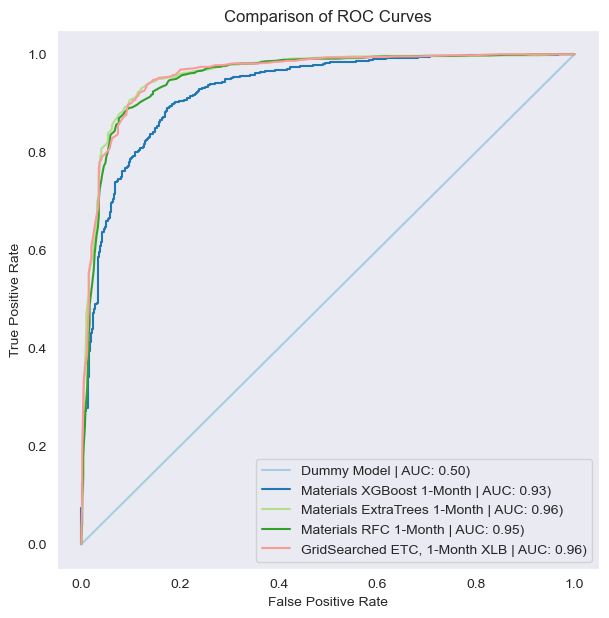

In [48]:
# Plotting the top models vs the dummy
compare_curves([dummy1, XGBoost, etc, rfc, gridS_cv])

### Final Observations
The difference of 0.001 in ccp_alpha allowed for an improvement on our best model of almost 0.1%. These results serve as a reminder than very minute changes can result in changes in performance.

In [50]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [54]:
# object instantiation and inspection of importances
features_from_trees(gridS_cv)

Top 5 Feature Importances
('Interest_Rates', 0.04523382073630687)
('20_day_SMA', 0.045167533701663425)
('Adj Close', 0.044889819851589775)
('MACD', 0.0436706557038892)
('one_up_bollinger_band', 0.043399018755037704)


In [59]:
Importance.df

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.04489,0.042906,0.040875,0.040902,0.037893,0.022596,0.029227,0.045234,0.015475,0.015633,0.015491,0.015779,0.015419,0.02904,0.036452,0.042583,0.043355,0.045168,0.043399,0.04174,0.042175,0.043671,0.022407,0.008054,0.008679,0.008086,0.008615,0.008225,0.00883,0.005291,0.005768,0.007023,0.008574,0.010867,0.006627,0.008664,0.009519,0.006927,0.008633,0.012784,0.014564,0.019284,0.015009,0.008398,0.008487,0.006302,0.008166,0.006314


<hr style="border: 2px solid royalblue">

# Materials 3 Month

### Editorial Discretion
From here forward, I will not be using KNN or AdaBoost as they are not performing well on any of the data I have used them on thus far. I will keep using logisitc regression only because I find it very interesting to compare the performance of parametric models to tree based algorithms. I also will not use the voting or stacking ensembles, however, I will continue to use GridSearchCV

### Functions to expedite models

In [60]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)

In [61]:
def l_regr(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [62]:
def r_forest(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [63]:
def extra_trees(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [64]:
def x_g_b(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [65]:
def best_etc_grid(estimator, model_type, sector_name, time_period):
    # Parameters to search through

    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }


# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, verbose=1)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"GridSearched Best-Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [71]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Three")

# dummy_M_3 = dummy_model(Materials, "Materials", 3)
# logreg_M_3 = l_regr(Materials, "Materials", 3)
# rfc_M_3 = r_forest(Materials, "Materials", 3)
# etc_M_3 = extra_trees(Materials, "Materials", 3)
# XGBoost_M_3 = x_g_b(Materials, "Materials", 3)

# grid_M_3 =best_etc_grid(estimator=etc_M_3.model, model_type=Materials, sector_name="Materials", time_period=3)

Materials.model_df.iloc[8:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,Materials Extra Trees 3-Month,0.944523,0.952709,0.961570,0.957070,0.179829,0.947475,0.961702,0.955603,0.958643,0.190523,0.985440
13,"GridSearched Best-Model, 3-Month Materials",0.945645,0.954076,0.961919,0.957917,0.179626,0.946128,0.959660,0.955603,0.957627,0.173313,0.984100
10,Materials Random Forest 3-Month,0.940254,0.946218,0.961921,0.953916,0.198653,0.944781,0.956660,0.956660,0.956660,0.177388,0.983304
12,Materials XGBoost 3-Month,0.921609,0.928721,0.951437,0.939776,0.232492,0.935354,0.944561,0.954545,0.949527,0.185246,0.980545
9,Materials Logistic Regression 3-Month,0.709120,0.734677,0.857097,0.791155,0.567820,0.715825,0.741697,0.849894,0.792118,0.551510,0.755000
8,Dummy Materials 3-Month,0.642857,0.642857,1.000000,0.782609,12.872737,0.637037,0.637037,1.000000,0.778281,13.082511,0.500000


In [76]:
# Feature importances
features_from_trees(etc_M_3)
Importance.df

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.044890,0.042906,0.040875,0.040902,0.037893,0.022596,0.029227,0.045234,0.015475,0.015633,0.015491,0.015779,0.015419,0.029040,0.036452,0.042583,0.043355,0.045168,0.043399,0.041740,0.042175,0.043671,0.022407,0.008054,0.008679,0.008086,0.008615,0.008225,0.008830,0.005291,0.005768,0.007023,0.008574,0.010867,0.006627,0.008664,0.009519,0.006927,0.008633,0.012784,0.014564,0.019284,0.015009,0.008398,0.008487,0.006302,0.008166,0.006314
1,0.041549,0.038883,0.041317,0.041996,0.041288,0.015714,0.046539,0.052163,0.008869,0.008845,0.009308,0.008089,0.009598,0.032032,0.024332,0.043753,0.039971,0.041239,0.041865,0.039677,0.037955,0.030861,0.014451,0.017342,0.018104,0.016444,0.014353,0.011371,0.008437,0.006605,0.007870,0.010041,0.013001,0.007982,0.005486,0.007269,0.016000,0.007683,0.011310,0.021992,0.020624,0.029405,0.019624,0.004683,0.003118,0.003970,0.003398,0.003598


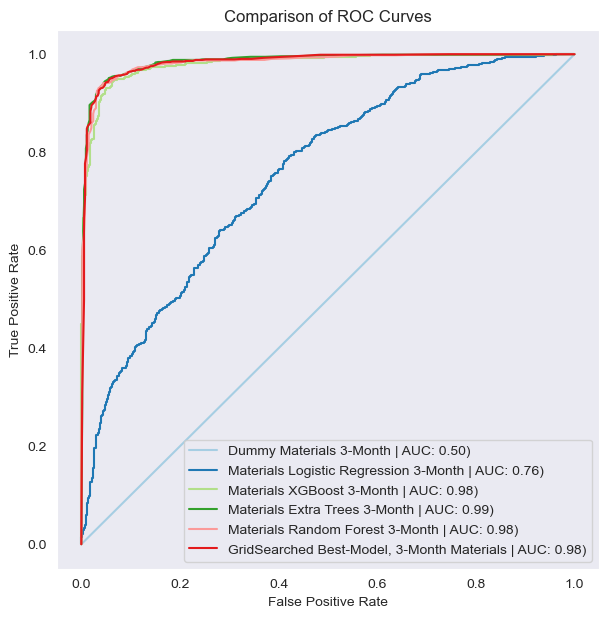

In [73]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_3, logreg_M_3, XGBoost_M_3, etc_M_3, rfc_M_3, grid_M_3])

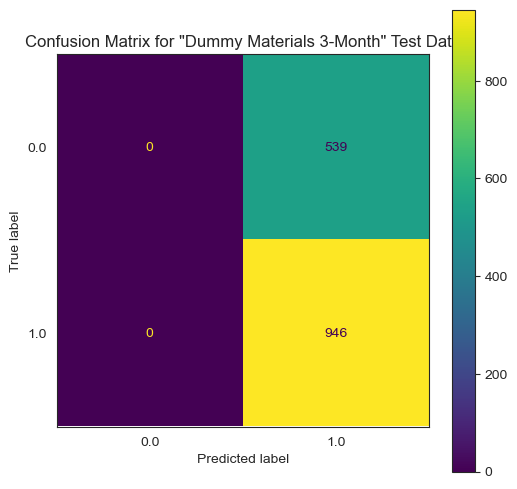

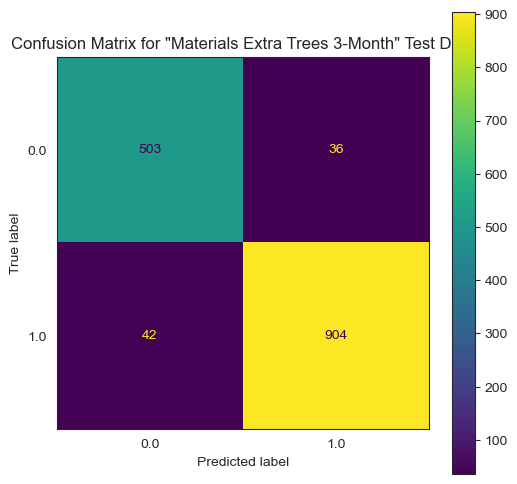

In [74]:
for i in [dummy_M_3, etc_M_3]:
    i.confusion_matrix()

<hr style="border: 2px solid royalblue">

# Materials 6-Month XLB

In [83]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Six")

# dummy_M_6 = dummy_model(Materials, "Materials", 6)
# logreg_M_6 = l_regr(Materials, "Materials", 6)
# rfc_M_6 = r_forest(Materials, "Materials", 6)
# etc_M_6 = extra_trees(Materials, "Materials", 6)
# XGBoost_M_6 = x_g_b(Materials, "Materials", 6)

# grid_M_6 =best_etc_grid(estimator=etc_M_6.model, model_type=Materials, sector_name="Materials", time_period=6)

Materials.model_df.iloc[13:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
19,"GridSearched Best-Model, 6-Month Materials",0.954401,0.960644,0.972943,0.966721,0.138573,0.960943,0.965449,0.977023,0.971202,0.116987,0.989978
17,Materials Extra Trees 6-Month,0.952604,0.959950,0.970964,0.965375,0.150394,0.958249,0.964392,0.974026,0.969185,0.135740,0.989773
16,Materials Random Forest 6-Month,0.948113,0.954644,0.969972,0.962174,0.158875,0.954882,0.953398,0.981019,0.967011,0.140818,0.987174
18,Materials XGBoost 6-Month,0.941377,0.949397,0.965357,0.957287,0.195235,0.949495,0.953033,0.973027,0.962926,0.170508,0.982334
13,"GridSearched Best-Model, 3-Month Materials",0.945645,0.954076,0.961919,0.957917,0.179626,0.946128,0.959660,0.955603,0.957627,0.173313,0.984100
15,Materials Logistic Regression 6-Month,0.743933,0.781213,0.866716,0.821707,0.505022,0.759596,0.794333,0.868132,0.829594,0.493891,0.804788
14,Dummy Materials 6-Month,0.680818,0.680818,1.000000,0.810103,11.504497,0.674074,0.674074,1.000000,0.805310,11.747561,0.500000


In [88]:
# Feature importances
features_from_trees(etc_M_6)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.06067646442395118)
('Interest_Rates', 0.059789566954909806)
('garman_klass_vol', 0.04391457317156223)
('lowest_bollinger_band', 0.04288347988325433)
('upper_bollinger_band', 0.04252266589440987)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.044890,0.042906,0.040875,0.040902,0.037893,0.022596,0.029227,0.045234,0.015475,0.015633,0.015491,0.015779,0.015419,0.029040,0.036452,0.042583,0.043355,0.045168,0.043399,0.041740,0.042175,0.043671,0.022407,0.008054,0.008679,0.008086,0.008615,0.008225,0.008830,0.005291,0.005768,0.007023,0.008574,0.010867,0.006627,0.008664,0.009519,0.006927,0.008633,0.012784,0.014564,0.019284,0.015009,0.008398,0.008487,0.006302,0.008166,0.006314
1,0.041549,0.038883,0.041317,0.041996,0.041288,0.015714,0.046539,0.052163,0.008869,0.008845,0.009308,0.008089,0.009598,0.032032,0.024332,0.043753,0.039971,0.041239,0.041865,0.039677,0.037955,0.030861,0.014451,0.017342,0.018104,0.016444,0.014353,0.011371,0.008437,0.006605,0.007870,0.010041,0.013001,0.007982,0.005486,0.007269,0.016000,0.007683,0.011310,0.021992,0.020624,0.029405,0.019624,0.004683,0.003118,0.003970,0.003398,0.003598
2,0.041111,0.040615,0.038549,0.041320,0.035480,0.015791,0.060676,0.059790,0.007668,0.007579,0.007954,0.007367,0.007852,0.043915,0.021449,0.042883,0.041622,0.041164,0.042184,0.042523,0.036984,0.022893,0.012823,0.015442,0.013389,0.013923,0.024967,0.010452,0.006724,0.005107,0.006191,0.007275,0.009175,0.008386,0.003732,0.004366,0.010425,0.006257,0.007727,0.026279,0.025873,0.035546,0.022017,0.002699,0.004072,0.002992,0.003444,0.003349


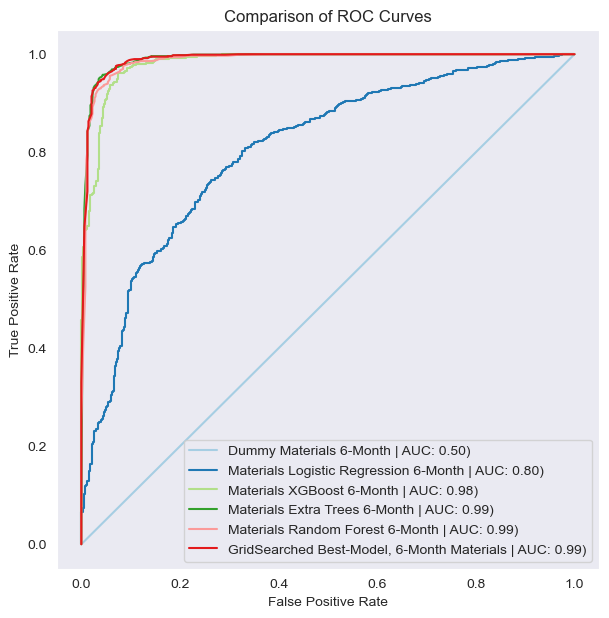

In [87]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_6, logreg_M_6, XGBoost_M_6, etc_M_6, rfc_M_6, grid_M_6])

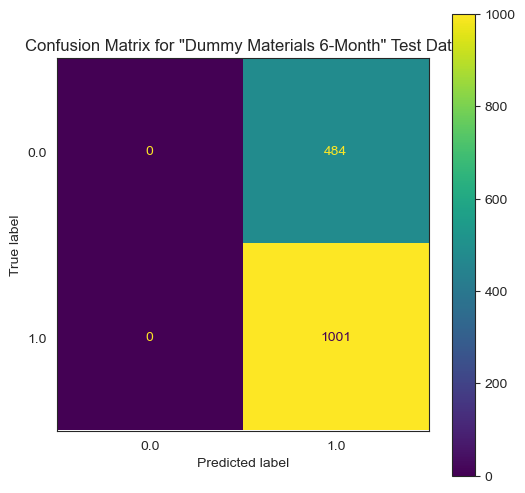

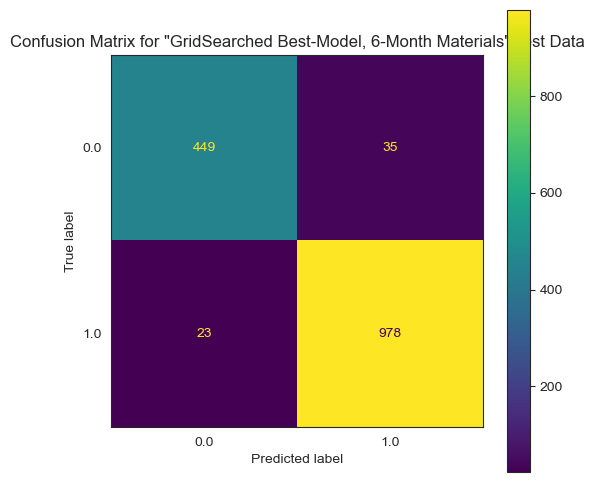

In [89]:
for i in [dummy_M_6, grid_M_6]:
    i.confusion_matrix()

<hr style="border: 2px solid royalblue">

# Materials 12-Month XLB

In [95]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Twelve")

# dummy_M_12 = dummy_model(Materials, "Materials", 12)
# logreg_M_12 = l_regr(Materials, "Materials", 12)
# rfc_M_12 = r_forest(Materials, "Materials", 12)
# etc_M_12 = extra_trees(Materials, "Materials", 12)
# XGBoost_M_12 = x_g_b(Materials, "Materials", 12)

# grid_M_12 = best_etc_grid(estimator=etc_M_12.model, model_type=Materials, sector_name="Materials", time_period=12)

Materials.model_df.iloc[20:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,Materials Extra Trees 12-Month,0.980909,0.985758,0.987302,0.986522,0.075691,0.974411,0.985451,0.977863,0.981643,0.066690,0.997332
25,"GridSearched Best-Model, 12-Month Materials",0.982481,0.987321,0.987937,0.987623,0.069957,0.973737,0.983559,0.978826,0.981187,0.066999,0.997403
24,Materials XGBoost 12-Month,0.974172,0.980989,0.982540,0.981752,0.078509,0.967677,0.977821,0.975938,0.976879,0.092482,0.995826
22,Materials Random Forest 12-Month,0.978886,0.985415,0.984762,0.985077,0.087830,0.966330,0.978703,0.973051,0.975869,0.089599,0.994893
21,Materials Logistic Regression 12-Month,0.835580,0.858804,0.918730,0.887703,0.381246,0.847811,0.868540,0.922040,0.894491,0.370951,0.890078
20,Dummy Materials 12-Month,0.707547,0.707547,1.000000,0.828729,10.541061,0.699663,0.699663,1.000000,0.823296,10.825232,0.500000


In [96]:
# Feature importances
features_from_trees(etc_M_12)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08188023672935653)
('Interest_Rates', 0.05902402425759021)
('garman_klass_vol', 0.05321812573817638)
('20_day_SMA', 0.0492041324366887)
('lower_bollinger_band', 0.048208692637652255)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.044890,0.042906,0.040875,0.040902,0.037893,0.022596,0.029227,0.045234,0.015475,0.015633,0.015491,0.015779,0.015419,0.029040,0.036452,0.042583,0.043355,0.045168,0.043399,0.041740,0.042175,0.043671,0.022407,0.008054,0.008679,0.008086,0.008615,0.008225,0.008830,0.005291,0.005768,0.007023,0.008574,0.010867,0.006627,0.008664,0.009519,0.006927,0.008633,0.012784,0.014564,0.019284,0.015009,0.008398,0.008487,0.006302,0.008166,0.006314
1,0.041549,0.038883,0.041317,0.041996,0.041288,0.015714,0.046539,0.052163,0.008869,0.008845,0.009308,0.008089,0.009598,0.032032,0.024332,0.043753,0.039971,0.041239,0.041865,0.039677,0.037955,0.030861,0.014451,0.017342,0.018104,0.016444,0.014353,0.011371,0.008437,0.006605,0.007870,0.010041,0.013001,0.007982,0.005486,0.007269,0.016000,0.007683,0.011310,0.021992,0.020624,0.029405,0.019624,0.004683,0.003118,0.003970,0.003398,0.003598
2,0.041111,0.040615,0.038549,0.041320,0.035480,0.015791,0.060676,0.059790,0.007668,0.007579,0.007954,0.007367,0.007852,0.043915,0.021449,0.042883,0.041622,0.041164,0.042184,0.042523,0.036984,0.022893,0.012823,0.015442,0.013389,0.013923,0.024967,0.010452,0.006724,0.005107,0.006191,0.007275,0.009175,0.008386,0.003732,0.004366,0.010425,0.006257,0.007727,0.026279,0.025873,0.035546,0.022017,0.002699,0.004072,0.002992,0.003444,0.003349
3,0.043558,0.042014,0.041731,0.041565,0.041107,0.009551,0.081880,0.059024,0.003293,0.004235,0.003910,0.003309,0.003558,0.053218,0.011397,0.041829,0.048209,0.049204,0.045244,0.043951,0.033155,0.017345,0.009731,0.019346,0.020957,0.014935,0.025186,0.003912,0.005941,0.004294,0.004332,0.004156,0.006151,0.005793,0.005394,0.005069,0.005096,0.006474,0.004522,0.024900,0.030834,0.034035,0.029423,0.001426,0.001662,0.001398,0.001304,0.001439


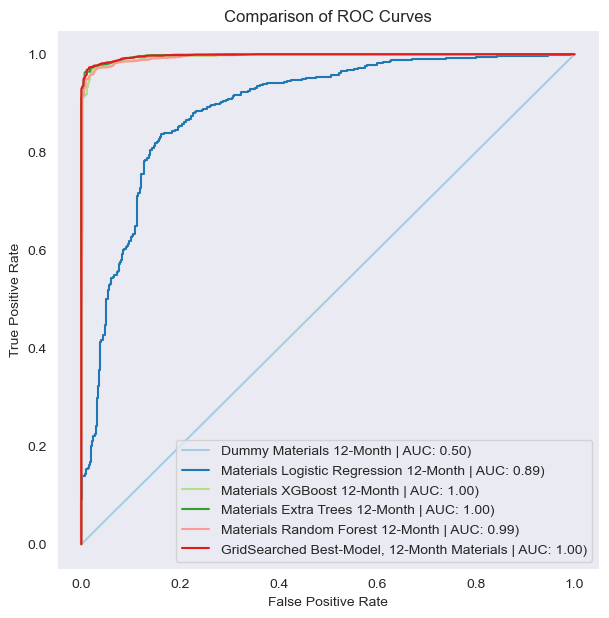

In [97]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_12, logreg_M_12, XGBoost_M_12, etc_M_12, rfc_M_12, grid_M_12])

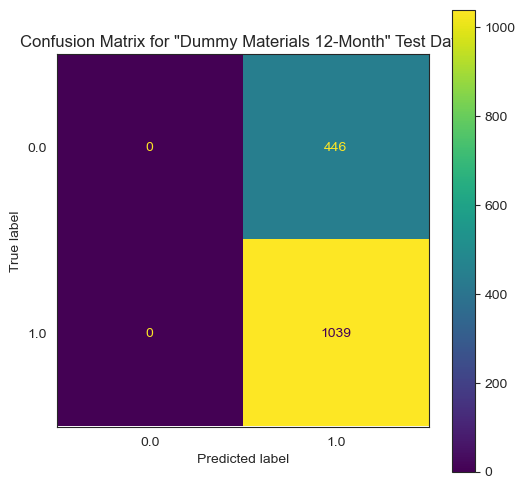

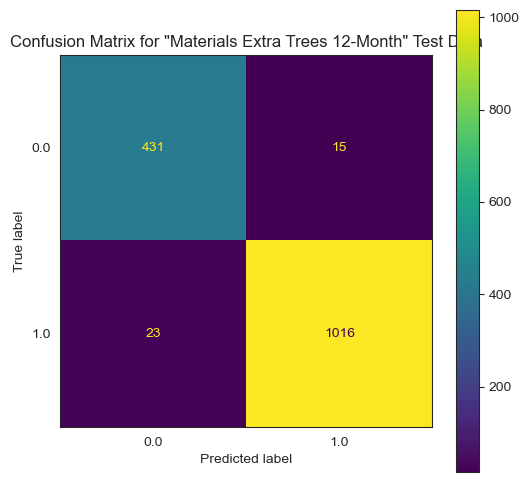

In [98]:
for i in [dummy_M_12, etc_M_12]:
    i.confusion_matrix()

<hr style="border: 4px solid green">

# From here forward: (Materials Completed)
I will be using every function that I have created to abbreviate and expedite the process of iterating through models in different sectors. The markdown explanations will be extremely sparse, but I will summarize the findings at the end of the notebook.

In [101]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "One")

# Create Model Objects

# dummy_E = dummy_model(Energy, "Energy", 1)
# logreg3 = l_regr(Energy, "Energy", 1)
# rfc3 = r_forest(Energy, "Energy", 1)
# etc3 = extra_trees(Energy, "Energy", 1)
# XGBoost3 = x_g_b(Energy, "Energy", 1)
# grid = best_etc_grid(estimator=etc3.model, model_type=Energy, sector_name="Energy", time_period=1)

Energy.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Energy Extra Trees 1-Month,0.903189,0.907732,0.926400,0.916960,0.270371,0.898316,0.888255,0.936298,0.911644,0.314076,0.958519
5,"GridSearched Best-Model, 1-Month Energy",0.903189,0.907732,0.926400,0.916960,0.270371,0.898316,0.888255,0.936298,0.911644,0.314076,0.958519
2,Energy Random Forest 1-Month,0.885888,0.884114,0.923279,0.903234,0.342394,0.896296,0.880045,0.943510,0.910673,0.316793,0.958859
4,Energy XGBoost 1-Month,0.844116,0.853097,0.881618,0.867106,0.417862,0.859259,0.860116,0.894231,0.876841,0.377164,0.927712
1,Energy Logistic Regression 1-Month,0.573902,0.591392,0.845402,0.695880,0.673721,0.565657,0.576828,0.843750,0.685212,0.676879,0.569489
0,Dummy Energy 1-Month,0.576819,0.576819,1.000000,0.731624,15.252976,0.560269,0.560269,1.000000,0.718170,15.849499,0.500000


In [109]:
# features_from_trees(Energy.model_list[3])
Importance.df.rename(index={0:"Materials 1-Month", 1:"Materials 3-Month", 2:"Materials 6-Month", \
                            3:"Materials 12-Month", 4:"Energy 1-Month"}, inplace=True)

<hr style="border: 2px solid darkgreen">

# XLE 3 Month

In [116]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Three")

# Create Model Objects

# dummy_E_3month = dummy_model(Energy, "Energy", 3)
# logregE_3month = l_regr(Energy, "Energy", 3)
# rfcE_3month = r_forest(Energy, "Energy", 3)
# etcE_3month = extra_trees(Energy, "Energy", 3)
# XGBoostE_3month = x_g_b(Energy, "Energy", 3)

# grid_E_3month = best_etc_grid(estimator=etcE_3month.model, model_type=Energy, sector_name="Energy", time_period=3)

Energy.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Energy Extra Trees 3-Month,0.939798,0.942024,0.962970,0.952365,0.213188,0.956229,0.950317,0.980371,0.965110,0.169099,0.987909
11,"GridSearched Best-Model, 3-Month Energy",0.940473,0.945869,0.959737,0.952737,0.185709,0.951515,0.949947,0.972737,0.961207,0.151317,0.988498
8,Energy Random Forest 3-Month,0.926773,0.926380,0.959019,0.942403,0.241896,0.948822,0.944974,0.973828,0.959184,0.212348,0.984264
10,Energy XGBoost 3-Month,0.910598,0.914759,0.944996,0.929618,0.260936,0.938721,0.937500,0.965104,0.951102,0.184704,0.978620
7,Energy Logistic Regression 3-Month,0.646673,0.666891,0.868438,0.754405,0.625198,0.636364,0.659881,0.848419,0.742366,0.633964,0.640688
6,Dummy Energy 3-Month,0.624888,0.624888,1.000000,0.769146,13.520422,0.617508,0.617508,1.000000,0.763530,13.786394,0.500000


In [119]:
# Feature Importances
features_from_trees(etcE_3month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.05063375462102687)
('Interest_Rates', 0.04698055221829858)
('Low', 0.043081511096514244)
('High', 0.04143239910168592)
('lower_bollinger_band', 0.041373767116052805)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Materials 6-Month,0.041111,0.040615,0.038549,0.041320,0.035480,0.015791,0.060676,0.059790,0.007668,0.007579,0.007954,0.007367,0.007852,0.043915,0.021449,0.042883,0.041622,0.041164,0.042184,0.042523,0.036984,0.022893,0.012823,0.015442,0.013389,0.013923,0.024967,0.010452,0.006724,0.005107,0.006191,0.007275,0.009175,0.008386,0.003732,0.004366,0.010425,0.006257,0.007727,0.026279,0.025873,0.035546,0.022017,0.002699,0.004072,0.002992,0.003444,0.003349
Materials 12-Month,0.043558,0.042014,0.041731,0.041565,0.041107,0.009551,0.081880,0.059024,0.003293,0.004235,0.003910,0.003309,0.003558,0.053218,0.011397,0.041829,0.048209,0.049204,0.045244,0.043951,0.033155,0.017345,0.009731,0.019346,0.020957,0.014935,0.025186,0.003912,0.005941,0.004294,0.004332,0.004156,0.006151,0.005793,0.005394,0.005069,0.005096,0.006474,0.004522,0.024900,0.030834,0.034035,0.029423,0.001426,0.001662,0.001398,0.001304,0.001439
Energy 1-Month,0.039603,0.042283,0.040701,0.039026,0.034973,0.020339,0.039448,0.044089,0.014855,0.013553,0.014077,0.014393,0.013856,0.031040,0.033747,0.039289,0.039600,0.040403,0.041314,0.041687,0.041111,0.039689,0.021334,0.011887,0.012065,0.010380,0.009928,0.010435,0.008986,0.008949,0.009878,0.008291,0.010879,0.009866,0.007726,0.012024,0.012421,0.007447,0.009484,0.017497,0.013816,0.018174,0.016657,0.006895,0.006334,0.005815,0.006795,0.006961
5,0.041359,0.040721,0.041432,0.043082,0.038206,0.017553,0.050634,0.046981,0.009643,0.009425,0.010175,0.009519,0.010107,0.033012,0.024775,0.038976,0.041374,0.040351,0.039779,0.037047,0.039282,0.027522,0.016603,0.019702,0.018250,0.017580,0.013148,0.011996,0.010701,0.008495,0.009438,0.006338,0.008470,0.007721,0.008906,0.008269,0.007703,0.007858,0.008449,0.025920,0.020749,0.024150,0.027321,0.004174,0.004291,0.004463,0.004126,0.004223


<hr style="border: 2px solid darkgreen">

# XLE 6 Month

In [122]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Six")

# Create Model Objects

# dummy_E_6month = dummy_model(Energy, "Energy", 6)
# logregE_6month = l_regr(Energy, "Energy", 6)
# rfcE_6month = r_forest(Energy, "Energy", 6)
# etcE_6month = extra_trees(Energy, "Energy", 6)
# XGBoostE_6month = x_g_b(Energy, "Energy", 6)

# grid_E_6month = best_etc_grid(estimator=etcE_6month.model, model_type=Energy, sector_name="Energy", time_period=6)

Energy.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Energy Extra Trees 6-Month,0.960469,0.968985,0.969657,0.969316,0.118624,0.962963,0.974093,0.969072,0.971576,0.099122,0.994797
17,"GridSearched Best-Model, 6-Month Energy",0.960469,0.968985,0.969657,0.969316,0.118624,0.962963,0.974093,0.969072,0.971576,0.099122,0.994797
14,Energy Random Forest 6-Month,0.953951,0.958677,0.970350,0.964467,0.147981,0.958249,0.968041,0.968041,0.968041,0.129113,0.991279
16,Energy XGBoost 6-Month,0.953278,0.960550,0.967213,0.963853,0.139882,0.952862,0.964876,0.962887,0.963880,0.144765,0.988464
13,Energy Logistic Regression 6-Month,0.692494,0.717526,0.861871,0.783086,0.585491,0.716498,0.740157,0.872165,0.800757,0.567142,0.730664
12,Dummy Energy 6-Month,0.643980,0.643980,1.000000,0.783440,12.832257,0.653199,0.653199,1.000000,0.790224,12.499988,0.500000


In [123]:
# Importances
features_from_trees(etcE_6month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.05837915829813945)
('Interest_Rates', 0.052433519460500524)
('cycle_year_1', 0.04398573000750036)
('Low', 0.04336601223475053)
('Adj Close', 0.043183602939830854)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Materials 12-Month,0.043558,0.042014,0.041731,0.041565,0.041107,0.009551,0.081880,0.059024,0.003293,0.004235,0.003910,0.003309,0.003558,0.053218,0.011397,0.041829,0.048209,0.049204,0.045244,0.043951,0.033155,0.017345,0.009731,0.019346,0.020957,0.014935,0.025186,0.003912,0.005941,0.004294,0.004332,0.004156,0.006151,0.005793,0.005394,0.005069,0.005096,0.006474,0.004522,0.024900,0.030834,0.034035,0.029423,0.001426,0.001662,0.001398,0.001304,0.001439
Energy 1-Month,0.039603,0.042283,0.040701,0.039026,0.034973,0.020339,0.039448,0.044089,0.014855,0.013553,0.014077,0.014393,0.013856,0.031040,0.033747,0.039289,0.039600,0.040403,0.041314,0.041687,0.041111,0.039689,0.021334,0.011887,0.012065,0.010380,0.009928,0.010435,0.008986,0.008949,0.009878,0.008291,0.010879,0.009866,0.007726,0.012024,0.012421,0.007447,0.009484,0.017497,0.013816,0.018174,0.016657,0.006895,0.006334,0.005815,0.006795,0.006961
5,0.041359,0.040721,0.041432,0.043082,0.038206,0.017553,0.050634,0.046981,0.009643,0.009425,0.010175,0.009519,0.010107,0.033012,0.024775,0.038976,0.041374,0.040351,0.039779,0.037047,0.039282,0.027522,0.016603,0.019702,0.018250,0.017580,0.013148,0.011996,0.010701,0.008495,0.009438,0.006338,0.008470,0.007721,0.008906,0.008269,0.007703,0.007858,0.008449,0.025920,0.020749,0.024150,0.027321,0.004174,0.004291,0.004463,0.004126,0.004223
6,0.043184,0.039242,0.037143,0.043366,0.041005,0.014160,0.058379,0.052434,0.006296,0.005827,0.006576,0.006843,0.006244,0.037127,0.017529,0.040265,0.039480,0.041687,0.041209,0.040860,0.032525,0.020014,0.013951,0.028473,0.011183,0.011147,0.022670,0.011518,0.005960,0.006899,0.006035,0.008825,0.008851,0.009305,0.003462,0.004530,0.003678,0.004782,0.006434,0.043986,0.031068,0.041491,0.031266,0.003053,0.002509,0.002858,0.002120,0.002552


<hr style="border: 2px solid darkgreen">

# XLE 12 Month

In [126]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Twelve")

# Create Model Objects

# dummy_E_12month = dummy_model(Energy, "Energy", 12)
# logregE_12month = l_regr(Energy, "Energy", 12)
# rfcE_12month = r_forest(Energy, "Energy", 12)
# etcE_12month = extra_trees(Energy, "Energy", 12)
# XGBoostE_12month = x_g_b(Energy, "Energy", 12)

# grid_E_12month = best_etc_grid(estimator=etcE_12month.model, model_type=Energy, sector_name="Energy", time_period=12)

Energy.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Energy Extra Trees 12-Month,0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987,0.987988,0.056978,0.998055
23,"GridSearched Best-Model, 12-Month Energy",0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987,0.987988,0.056978,0.998055
20,Energy Random Forest 12-Month,0.972148,0.977318,0.980585,0.978916,0.079379,0.979798,0.982107,0.988,0.985045,0.072762,0.997373
22,Energy XGBoost 12-Month,0.969227,0.972437,0.981264,0.976777,0.094764,0.973064,0.980000,0.980,0.980000,0.084670,0.995786
19,Energy Logistic Regression 12-Month,0.735172,0.775090,0.843326,0.807668,0.496073,0.742761,0.788785,0.844,0.815459,0.488093,0.806522
18,Dummy Energy 12-Month,0.659479,0.659479,1.000000,0.794802,12.273623,0.673401,0.673401,1.000,0.804829,11.771833,0.500000


In [128]:
# Importances
features_from_trees(etcE_12month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.07521498200780251)
('Interest_Rates', 0.06848471118673358)
('cycle_year_1', 0.0646144071178549)
('Low', 0.053182747221124566)
('Adj Close', 0.049606212759451714)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Energy 1-Month,0.039603,0.042283,0.040701,0.039026,0.034973,0.020339,0.039448,0.044089,0.014855,0.013553,0.014077,0.014393,0.013856,0.031040,0.033747,0.039289,0.039600,0.040403,0.041314,0.041687,0.041111,0.039689,0.021334,0.011887,0.012065,0.010380,0.009928,0.010435,0.008986,0.008949,0.009878,0.008291,0.010879,0.009866,0.007726,0.012024,0.012421,0.007447,0.009484,0.017497,0.013816,0.018174,0.016657,0.006895,0.006334,0.005815,0.006795,0.006961
5,0.041359,0.040721,0.041432,0.043082,0.038206,0.017553,0.050634,0.046981,0.009643,0.009425,0.010175,0.009519,0.010107,0.033012,0.024775,0.038976,0.041374,0.040351,0.039779,0.037047,0.039282,0.027522,0.016603,0.019702,0.018250,0.017580,0.013148,0.011996,0.010701,0.008495,0.009438,0.006338,0.008470,0.007721,0.008906,0.008269,0.007703,0.007858,0.008449,0.025920,0.020749,0.024150,0.027321,0.004174,0.004291,0.004463,0.004126,0.004223
6,0.043184,0.039242,0.037143,0.043366,0.041005,0.014160,0.058379,0.052434,0.006296,0.005827,0.006576,0.006843,0.006244,0.037127,0.017529,0.040265,0.039480,0.041687,0.041209,0.040860,0.032525,0.020014,0.013951,0.028473,0.011183,0.011147,0.022670,0.011518,0.005960,0.006899,0.006035,0.008825,0.008851,0.009305,0.003462,0.004530,0.003678,0.004782,0.006434,0.043986,0.031068,0.041491,0.031266,0.003053,0.002509,0.002858,0.002120,0.002552
7,0.049606,0.041808,0.049488,0.053183,0.046611,0.016175,0.075215,0.068485,0.003996,0.003571,0.004393,0.004485,0.005000,0.042815,0.009372,0.045771,0.045787,0.045237,0.047195,0.048411,0.028916,0.012118,0.016418,0.006997,0.009881,0.007111,0.009314,0.004518,0.003001,0.003145,0.007878,0.003638,0.003112,0.001973,0.002873,0.004093,0.003664,0.004059,0.005039,0.064614,0.020012,0.042209,0.020837,0.001509,0.001552,0.001650,0.001276,0.001988


In [129]:
Importance.df.rename(index={5:"Energy 3-Month", 6:"Energy 6-Month", 7:"Energy 12-Month"}, inplace=True)

<hr style="border: 2px solid black">

#  Financials XLF

### 1 Month

In [132]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "One")


# Create Model Objects

# dummy_F_1 = dummy_model(Financials, "Financials", 1)
# logreg_F_1 = l_regr(Financials, "Financials", 1)
# rfc_F_1 = r_forest(Financials, "Financials", 1)
# etc_F_1 = extra_trees(Financials, "Financials", 1)
# XGBoost_F_1 = x_g_b(Financials, "Financials", 1)

# grid_F_1 = best_etc_grid(estimator=etc_F_1.model, model_type=Financials, sector_name="Financials", time_period=1)

Financials.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Financials Extra Trees 1-Month,0.887016,0.897810,0.910522,0.904106,0.304427,0.912458,0.907880,0.945665,0.926387,0.249511,0.967786
5,"GridSearched Best-Model, 1-Month Financials",0.887465,0.899503,0.909367,0.904347,0.305436,0.911785,0.909598,0.942197,0.925610,0.247999,0.969739
2,Financials Random Forest 1-Month,0.886346,0.889388,0.920505,0.904584,0.341710,0.909091,0.904656,0.943353,0.923599,0.294053,0.963811
4,Financials XGBoost 1-Month,0.848606,0.861545,0.883253,0.872132,0.433027,0.876094,0.883015,0.907514,0.895097,0.350197,0.935197
0,Dummy Financials 1-Month,0.584906,0.584906,1.000000,0.738095,14.961514,0.582492,0.582492,1.000000,0.736170,15.048529,0.500000
1,Financials Logistic Regression 1-Month,0.605122,0.625542,0.809530,0.705654,0.654167,0.579798,0.605609,0.798844,0.688933,0.657019,0.623069


In [133]:
# Importances
features_from_trees(grid_F_1)
Importance.df[-4:]

Top 5 Feature Importances
('Close', 0.04367300681735767)
('one_up_bollinger_band', 0.04172915203454829)
('MACD', 0.04145863866686467)
('20_day_SMA', 0.041107017562207915)
('Adj Close', 0.040444215681062747)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Energy 3-Month,0.041359,0.040721,0.041432,0.043082,0.038206,0.017553,0.050634,0.046981,0.009643,0.009425,0.010175,0.009519,0.010107,0.033012,0.024775,0.038976,0.041374,0.040351,0.039779,0.037047,0.039282,0.027522,0.016603,0.019702,0.018250,0.017580,0.013148,0.011996,0.010701,0.008495,0.009438,0.006338,0.008470,0.007721,0.008906,0.008269,0.007703,0.007858,0.008449,0.025920,0.020749,0.024150,0.027321,0.004174,0.004291,0.004463,0.004126,0.004223
Energy 6-Month,0.043184,0.039242,0.037143,0.043366,0.041005,0.014160,0.058379,0.052434,0.006296,0.005827,0.006576,0.006843,0.006244,0.037127,0.017529,0.040265,0.039480,0.041687,0.041209,0.040860,0.032525,0.020014,0.013951,0.028473,0.011183,0.011147,0.022670,0.011518,0.005960,0.006899,0.006035,0.008825,0.008851,0.009305,0.003462,0.004530,0.003678,0.004782,0.006434,0.043986,0.031068,0.041491,0.031266,0.003053,0.002509,0.002858,0.002120,0.002552
Energy 12-Month,0.049606,0.041808,0.049488,0.053183,0.046611,0.016175,0.075215,0.068485,0.003996,0.003571,0.004393,0.004485,0.005000,0.042815,0.009372,0.045771,0.045787,0.045237,0.047195,0.048411,0.028916,0.012118,0.016418,0.006997,0.009881,0.007111,0.009314,0.004518,0.003001,0.003145,0.007878,0.003638,0.003112,0.001973,0.002873,0.004093,0.003664,0.004059,0.005039,0.064614,0.020012,0.042209,0.020837,0.001509,0.001552,0.001650,0.001276,0.001988
8,0.040444,0.043673,0.039717,0.039952,0.038204,0.023322,0.032309,0.040015,0.018375,0.016075,0.017714,0.017482,0.016101,0.027485,0.036834,0.039807,0.040173,0.041107,0.041729,0.039564,0.039583,0.041459,0.024106,0.009308,0.011954,0.010423,0.010195,0.012339,0.009099,0.006916,0.008669,0.011123,0.009697,0.008447,0.008109,0.008963,0.010743,0.008757,0.007653,0.010757,0.015063,0.014310,0.012771,0.007777,0.008362,0.007637,0.008402,0.007294


<hr style="border: 2px solid darkgreen">

# XLF 3 Month

In [136]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Three")


# Create Model Objects

# dummy_F_3 = dummy_model(Financials, "Financials", 3)
# logreg_F_3 = l_regr(Financials, "Financials", 3)
# rfc_F_3 = r_forest(Financials, "Financials", 3)
# etc_F_3 = extra_trees(Financials, "Financials", 3)
# XGBoost_F_3 = x_g_b(Financials, "Financials", 3)

# grid_F_3 = best_etc_grid(estimator=etc_F_3.model, model_type=Financials, sector_name="Financials", time_period=3)

Financials.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Financials Extra Trees 3-Month,0.944745,0.953360,0.960608,0.956913,0.173511,0.949495,0.957732,0.964694,0.961200,0.170169,0.985126
11,"GridSearched Best-Model, 3-Month Financials",0.944745,0.953360,0.960608,0.956913,0.173511,0.949495,0.957732,0.964694,0.961200,0.170169,0.985126
8,Financials Random Forest 3-Month,0.940029,0.941734,0.965885,0.953636,0.200054,0.940067,0.945918,0.962617,0.954195,0.182802,0.981930
10,Financials XGBoost 3-Month,0.928349,0.934955,0.954275,0.944481,0.235568,0.927946,0.943064,0.946002,0.944531,0.216626,0.971760
7,Financials Logistic Regression 3-Month,0.708449,0.733150,0.854385,0.789095,0.559281,0.723232,0.744248,0.873313,0.803631,0.551050,0.747785
6,Dummy Financials 3-Month,0.638589,0.638589,1.000000,0.779438,13.026559,0.648485,0.648485,1.000000,0.786765,12.669890,0.500000


In [137]:
# Importances
features_from_trees(etc_F_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.059456839831980766)
('Interest_Rates', 0.050007700713297486)
('ATR', 0.04576452961908186)
('upper_bollinger_band', 0.04187540982131246)
('High', 0.04055533769505283)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Energy 6-Month,0.043184,0.039242,0.037143,0.043366,0.041005,0.014160,0.058379,0.052434,0.006296,0.005827,0.006576,0.006843,0.006244,0.037127,0.017529,0.040265,0.039480,0.041687,0.041209,0.040860,0.032525,0.020014,0.013951,0.028473,0.011183,0.011147,0.022670,0.011518,0.005960,0.006899,0.006035,0.008825,0.008851,0.009305,0.003462,0.004530,0.003678,0.004782,0.006434,0.043986,0.031068,0.041491,0.031266,0.003053,0.002509,0.002858,0.002120,0.002552
Energy 12-Month,0.049606,0.041808,0.049488,0.053183,0.046611,0.016175,0.075215,0.068485,0.003996,0.003571,0.004393,0.004485,0.005000,0.042815,0.009372,0.045771,0.045787,0.045237,0.047195,0.048411,0.028916,0.012118,0.016418,0.006997,0.009881,0.007111,0.009314,0.004518,0.003001,0.003145,0.007878,0.003638,0.003112,0.001973,0.002873,0.004093,0.003664,0.004059,0.005039,0.064614,0.020012,0.042209,0.020837,0.001509,0.001552,0.001650,0.001276,0.001988
8,0.040444,0.043673,0.039717,0.039952,0.038204,0.023322,0.032309,0.040015,0.018375,0.016075,0.017714,0.017482,0.016101,0.027485,0.036834,0.039807,0.040173,0.041107,0.041729,0.039564,0.039583,0.041459,0.024106,0.009308,0.011954,0.010423,0.010195,0.012339,0.009099,0.006916,0.008669,0.011123,0.009697,0.008447,0.008109,0.008963,0.010743,0.008757,0.007653,0.010757,0.015063,0.014310,0.012771,0.007777,0.008362,0.007637,0.008402,0.007294
9,0.037704,0.038034,0.040555,0.035010,0.035242,0.024169,0.059457,0.050008,0.007930,0.008183,0.009348,0.008037,0.008481,0.036080,0.021791,0.040058,0.040067,0.038803,0.039389,0.041875,0.045765,0.027670,0.021475,0.024282,0.015545,0.009580,0.016855,0.010369,0.007176,0.011217,0.013237,0.008891,0.011298,0.012261,0.006664,0.009570,0.007978,0.006256,0.009690,0.026697,0.019834,0.022859,0.016976,0.003230,0.003612,0.003639,0.004021,0.003132


<hr style="border: 2px solid darkgreen">

# XLF 6 Month

In [140]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Six")

# Create Model Objects

# dummy_F_6month = dummy_model(Financials, "Financials", 6)
# logreg_F_6month = l_regr(Financials, "Financials", 6)
# rfc_F_6month = r_forest(Financials, "Financials", 6)
# etc_F_6month = extra_trees(Financials, "Financials", 6)
# XGBoost_F_6month = x_g_b(Financials, "Financials", 6)

# grid_F_6month = best_etc_grid(estimator=etc_F_6month.model, model_type=Financials, sector_name="Financials", time_period=6)

Financials.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,"GridSearched Best-Model, 6-Month Financials",0.963614,0.972341,0.970265,0.971278,0.153263,0.958923,0.969231,0.968238,0.968734,0.099020,0.994469
15,Financials Extra Trees 6-Month,0.962942,0.972003,0.969558,0.970765,0.121486,0.956902,0.968172,0.966189,0.967179,0.103757,0.992914
14,Financials Random Forest 6-Month,0.959124,0.965547,0.970265,0.967885,0.141370,0.956229,0.963377,0.970287,0.966820,0.143501,0.990671
16,Financials XGBoost 6-Month,0.954406,0.963242,0.964956,0.964088,0.136832,0.948148,0.961026,0.960041,0.960533,0.162966,0.985895
13,Financials Logistic Regression 6-Month,0.689355,0.723425,0.826549,0.771538,0.532558,0.715825,0.751818,0.847336,0.796724,0.515878,0.785607
12,Dummy Financials 6-Month,0.634546,0.634546,1.000000,0.776419,13.172281,0.657239,0.657239,1.000000,0.793174,12.354357,0.500000


In [141]:
# Importance
features_from_trees(grid_F_6month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.07084555617102847)
('Interest_Rates', 0.06223607083023794)
('one_up_bollinger_band', 0.0453229898051339)
('lower_bollinger_band', 0.04288516521206553)
('20_day_SMA', 0.04269897543174706)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Energy 12-Month,0.049606,0.041808,0.049488,0.053183,0.046611,0.016175,0.075215,0.068485,0.003996,0.003571,0.004393,0.004485,0.005000,0.042815,0.009372,0.045771,0.045787,0.045237,0.047195,0.048411,0.028916,0.012118,0.016418,0.006997,0.009881,0.007111,0.009314,0.004518,0.003001,0.003145,0.007878,0.003638,0.003112,0.001973,0.002873,0.004093,0.003664,0.004059,0.005039,0.064614,0.020012,0.042209,0.020837,0.001509,0.001552,0.001650,0.001276,0.001988
8,0.040444,0.043673,0.039717,0.039952,0.038204,0.023322,0.032309,0.040015,0.018375,0.016075,0.017714,0.017482,0.016101,0.027485,0.036834,0.039807,0.040173,0.041107,0.041729,0.039564,0.039583,0.041459,0.024106,0.009308,0.011954,0.010423,0.010195,0.012339,0.009099,0.006916,0.008669,0.011123,0.009697,0.008447,0.008109,0.008963,0.010743,0.008757,0.007653,0.010757,0.015063,0.014310,0.012771,0.007777,0.008362,0.007637,0.008402,0.007294
9,0.037704,0.038034,0.040555,0.035010,0.035242,0.024169,0.059457,0.050008,0.007930,0.008183,0.009348,0.008037,0.008481,0.036080,0.021791,0.040058,0.040067,0.038803,0.039389,0.041875,0.045765,0.027670,0.021475,0.024282,0.015545,0.009580,0.016855,0.010369,0.007176,0.011217,0.013237,0.008891,0.011298,0.012261,0.006664,0.009570,0.007978,0.006256,0.009690,0.026697,0.019834,0.022859,0.016976,0.003230,0.003612,0.003639,0.004021,0.003132
10,0.040776,0.038564,0.041221,0.037851,0.035158,0.021591,0.070846,0.062236,0.006951,0.006319,0.006526,0.006957,0.007397,0.038537,0.017564,0.040186,0.042885,0.042699,0.045323,0.042043,0.041610,0.021241,0.020820,0.017346,0.008974,0.012981,0.016730,0.007692,0.006863,0.006307,0.009877,0.005589,0.007222,0.005309,0.004366,0.005383,0.005360,0.007079,0.009745,0.024502,0.023034,0.040008,0.025362,0.003123,0.003088,0.002906,0.002977,0.002877


<hr style="border: 2px solid darkgreen">

# XLF 12 Month

In [144]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Twelve")

# Create Model Objects

# dummy_F_12month = dummy_model(Financials, "Financials", 12)
# logreg_F_12month = l_regr(Financials, "Financials", 12)
# rfc_F_12month = r_forest(Financials, "Financials", 12)
# etc_F_12month = extra_trees(Financials, "Financials", 12)
# XGBoost_F_12month = x_g_b(Financials, "Financials", 12)

# grid_F_12month = best_etc_grid(estimator=etc_F_12month.model, model_type=Financials, sector_name="Financials", time_period=12)

Financials.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Financials Extra Trees 12-Month,0.974618,0.980877,0.979104,0.979958,0.078537,0.977104,0.987248,0.976866,0.982030,0.069397,0.997436
23,"GridSearched Best-Model, 12-Month Financials",0.976192,0.981960,0.980522,0.981217,0.080634,0.977104,0.985185,0.978970,0.982068,0.069402,0.997412
20,Financials Random Forest 12-Month,0.972148,0.979096,0.976980,0.978013,0.102726,0.974411,0.983069,0.976866,0.979958,0.089078,0.996172
22,Financials XGBoost 12-Month,0.969004,0.975951,0.975210,0.975552,0.087966,0.973737,0.975992,0.983176,0.979570,0.080545,0.996178
19,Financials Logistic Regression 12-Month,0.718777,0.751158,0.832511,0.789721,0.515216,0.719865,0.749767,0.844374,0.794263,0.502856,0.800342
18,Dummy Financials 12-Month,0.634322,0.634322,1.000000,0.776251,13.180380,0.640404,0.640404,1.000000,0.780788,12.961152,0.500000


In [145]:
# Importance
features_from_trees(grid_F_12month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.07080464376402197)
('cycle_year_3', 0.05404993213202203)
('Interest_Rates', 0.051135743434159206)
('one_up_bollinger_band', 0.04640022693871722)
('High', 0.04515156882928083)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
8,0.040444,0.043673,0.039717,0.039952,0.038204,0.023322,0.032309,0.040015,0.018375,0.016075,0.017714,0.017482,0.016101,0.027485,0.036834,0.039807,0.040173,0.041107,0.041729,0.039564,0.039583,0.041459,0.024106,0.009308,0.011954,0.010423,0.010195,0.012339,0.009099,0.006916,0.008669,0.011123,0.009697,0.008447,0.008109,0.008963,0.010743,0.008757,0.007653,0.010757,0.015063,0.014310,0.012771,0.007777,0.008362,0.007637,0.008402,0.007294
9,0.037704,0.038034,0.040555,0.035010,0.035242,0.024169,0.059457,0.050008,0.007930,0.008183,0.009348,0.008037,0.008481,0.036080,0.021791,0.040058,0.040067,0.038803,0.039389,0.041875,0.045765,0.027670,0.021475,0.024282,0.015545,0.009580,0.016855,0.010369,0.007176,0.011217,0.013237,0.008891,0.011298,0.012261,0.006664,0.009570,0.007978,0.006256,0.009690,0.026697,0.019834,0.022859,0.016976,0.003230,0.003612,0.003639,0.004021,0.003132
10,0.040776,0.038564,0.041221,0.037851,0.035158,0.021591,0.070846,0.062236,0.006951,0.006319,0.006526,0.006957,0.007397,0.038537,0.017564,0.040186,0.042885,0.042699,0.045323,0.042043,0.041610,0.021241,0.020820,0.017346,0.008974,0.012981,0.016730,0.007692,0.006863,0.006307,0.009877,0.005589,0.007222,0.005309,0.004366,0.005383,0.005360,0.007079,0.009745,0.024502,0.023034,0.040008,0.025362,0.003123,0.003088,0.002906,0.002977,0.002877
11,0.042371,0.042791,0.045152,0.041562,0.039139,0.018223,0.070805,0.051136,0.005185,0.004504,0.005219,0.004727,0.005055,0.040012,0.014257,0.041556,0.044219,0.042888,0.046400,0.044073,0.040276,0.017767,0.018952,0.018453,0.011039,0.011334,0.021511,0.005436,0.005317,0.005015,0.006537,0.005546,0.006504,0.007202,0.005687,0.004685,0.008137,0.007011,0.007286,0.021174,0.021657,0.054050,0.029742,0.002017,0.002387,0.001998,0.001805,0.002202


In [147]:
Importance.df.rename(index={8:"Financials 1-Month", 9:"Financials 3-Month",10:"Financials 6-Month",\
                           11:"Financials 12-Month"}, inplace=True)

<hr style="border: 2px solid black">

#  Industrials

### 1 Month

In [150]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "One")


# Create Model Objects

# dummy_Ind_1 = dummy_model(Industrials, "Industrials", 1)
# logreg_Ind_1 = l_regr(Industrials, "Industrials", 1)
# rfc_Ind_1 = r_forest(Industrials, "Industrials", 1)
# etc_Ind_1 = extra_trees(Industrials, "Industrials", 1)
# XGBoost_Ind_1 = x_g_b(Industrials, "Industrials", 1)

# grid_Ind_1 = best_etc_grid(estimator=etc_Ind_1.model, model_type=Industrials, sector_name="Industrials", time_period=1)

Industrials.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Industrials Extra Trees 1-Month,0.890165,0.904881,0.912607,0.908668,0.290053,0.915825,0.920652,0.942158,0.931281,0.234928,0.970751
5,"GridSearched Best-Model, 1-Month Industrials",0.890839,0.904114,0.914858,0.909391,0.286363,0.911111,0.920966,0.933259,0.927072,0.238033,0.972028
2,Industrials Random Forest 1-Month,0.878934,0.889495,0.911108,0.900112,0.330731,0.910438,0.913607,0.941046,0.927123,0.280494,0.966873
4,Industrials XGBoost 1-Month,0.837601,0.856257,0.875847,0.865910,0.427615,0.859259,0.876638,0.893215,0.884848,0.356491,0.931113
1,Industrials Logistic Regression 1-Month,0.656562,0.671194,0.836093,0.744544,0.636397,0.670034,0.685403,0.840934,0.755245,0.616782,0.688957
0,Dummy Industrials 1-Month,0.598832,0.598832,1.000000,0.749087,14.459560,0.605387,0.605387,1.000000,0.754195,14.223287,0.500000


In [151]:
# Importance
features_from_trees(etc_Ind_1)
Importance.df[-4:]

Top 5 Feature Importances
('one_up_bollinger_band', 0.04375117534119992)
('20_day_SMA', 0.04372038614317151)
('Adj Close', 0.043372028563344586)
('Close', 0.04330129088165946)
('lowest_bollinger_band', 0.042838535252420235)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Financials 3-Month,0.037704,0.038034,0.040555,0.035010,0.035242,0.024169,0.059457,0.050008,0.007930,0.008183,0.009348,0.008037,0.008481,0.036080,0.021791,0.040058,0.040067,0.038803,0.039389,0.041875,0.045765,0.027670,0.021475,0.024282,0.015545,0.009580,0.016855,0.010369,0.007176,0.011217,0.013237,0.008891,0.011298,0.012261,0.006664,0.009570,0.007978,0.006256,0.009690,0.026697,0.019834,0.022859,0.016976,0.003230,0.003612,0.003639,0.004021,0.003132
Financials 6-Month,0.040776,0.038564,0.041221,0.037851,0.035158,0.021591,0.070846,0.062236,0.006951,0.006319,0.006526,0.006957,0.007397,0.038537,0.017564,0.040186,0.042885,0.042699,0.045323,0.042043,0.041610,0.021241,0.020820,0.017346,0.008974,0.012981,0.016730,0.007692,0.006863,0.006307,0.009877,0.005589,0.007222,0.005309,0.004366,0.005383,0.005360,0.007079,0.009745,0.024502,0.023034,0.040008,0.025362,0.003123,0.003088,0.002906,0.002977,0.002877
Financials 12-Month,0.042371,0.042791,0.045152,0.041562,0.039139,0.018223,0.070805,0.051136,0.005185,0.004504,0.005219,0.004727,0.005055,0.040012,0.014257,0.041556,0.044219,0.042888,0.046400,0.044073,0.040276,0.017767,0.018952,0.018453,0.011039,0.011334,0.021511,0.005436,0.005317,0.005015,0.006537,0.005546,0.006504,0.007202,0.005687,0.004685,0.008137,0.007011,0.007286,0.021174,0.021657,0.054050,0.029742,0.002017,0.002387,0.001998,0.001805,0.002202
12,0.043372,0.043301,0.041702,0.042329,0.038594,0.020396,0.032228,0.039118,0.014428,0.014655,0.015296,0.014777,0.014478,0.027271,0.035211,0.042839,0.042269,0.043720,0.043751,0.042081,0.039812,0.040076,0.020138,0.009356,0.010336,0.009751,0.009346,0.010987,0.009100,0.006790,0.006521,0.010757,0.011436,0.008236,0.008873,0.008051,0.012909,0.009776,0.009569,0.013063,0.014750,0.018489,0.016698,0.006695,0.006356,0.006486,0.006799,0.007030


<hr style="border: 2px solid darkgreen">

# XLI 3 Month

In [154]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Three")


# Create Model Objects

# dummy_Ind_3 = dummy_model(Industrials, "Industrials", 3)
# logreg_Ind_3 = l_regr(Industrials, "Industrials", 3)
# rfc_Ind_3 = r_forest(Industrials, "Industrials", 3)
# etc_Ind_3 = extra_trees(Industrials, "Industrials", 3)
# XGBoost_Ind_3 = x_g_b(Industrials, "Industrials", 3)

# grid_Ind_3 = best_etc_grid(estimator=etc_Ind_3.model, model_type=Industrials, sector_name="Industrials", time_period=3)

Industrials.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Industrials Extra Trees 3-Month,0.945418,0.959630,0.957132,0.958284,0.185748,0.952189,0.958877,0.969574,0.964196,0.162535,0.988177
11,"GridSearched Best-Model, 3-Month Industrials",0.945419,0.960634,0.956104,0.958241,0.175472,0.950168,0.955090,0.970588,0.962777,0.185254,0.987588
8,Industrials Random Forest 3-Month,0.939805,0.951921,0.956446,0.954148,0.195543,0.947475,0.961382,0.959432,0.960406,0.178813,0.983903
10,Industrials XGBoost 3-Month,0.921609,0.935583,0.945471,0.940455,0.222130,0.928620,0.944444,0.948276,0.946356,0.182839,0.980600
7,Industrials Logistic Regression 3-Month,0.699015,0.731378,0.854261,0.788001,0.554470,0.701010,0.740675,0.845842,0.789773,0.542851,0.752265
6,Dummy Industrials 3-Month,0.654987,0.654987,1.000000,0.791531,12.435544,0.663973,0.663973,1.000000,0.798057,12.111638,0.500000


In [155]:
# Importance
features_from_trees(etc_Ind_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.04954365225202263)
('Interest_Rates', 0.049391582556765075)
('one_up_bollinger_band', 0.04140399612685797)
('lower_bollinger_band', 0.04042118991043211)
('lowest_bollinger_band', 0.0402743161272703)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Financials 6-Month,0.040776,0.038564,0.041221,0.037851,0.035158,0.021591,0.070846,0.062236,0.006951,0.006319,0.006526,0.006957,0.007397,0.038537,0.017564,0.040186,0.042885,0.042699,0.045323,0.042043,0.041610,0.021241,0.020820,0.017346,0.008974,0.012981,0.016730,0.007692,0.006863,0.006307,0.009877,0.005589,0.007222,0.005309,0.004366,0.005383,0.005360,0.007079,0.009745,0.024502,0.023034,0.040008,0.025362,0.003123,0.003088,0.002906,0.002977,0.002877
Financials 12-Month,0.042371,0.042791,0.045152,0.041562,0.039139,0.018223,0.070805,0.051136,0.005185,0.004504,0.005219,0.004727,0.005055,0.040012,0.014257,0.041556,0.044219,0.042888,0.046400,0.044073,0.040276,0.017767,0.018952,0.018453,0.011039,0.011334,0.021511,0.005436,0.005317,0.005015,0.006537,0.005546,0.006504,0.007202,0.005687,0.004685,0.008137,0.007011,0.007286,0.021174,0.021657,0.054050,0.029742,0.002017,0.002387,0.001998,0.001805,0.002202
12,0.043372,0.043301,0.041702,0.042329,0.038594,0.020396,0.032228,0.039118,0.014428,0.014655,0.015296,0.014777,0.014478,0.027271,0.035211,0.042839,0.042269,0.043720,0.043751,0.042081,0.039812,0.040076,0.020138,0.009356,0.010336,0.009751,0.009346,0.010987,0.009100,0.006790,0.006521,0.010757,0.011436,0.008236,0.008873,0.008051,0.012909,0.009776,0.009569,0.013063,0.014750,0.018489,0.016698,0.006695,0.006356,0.006486,0.006799,0.007030
13,0.038876,0.037232,0.036322,0.038815,0.036084,0.016735,0.049544,0.049392,0.008864,0.009864,0.009552,0.008634,0.009046,0.033461,0.025340,0.040274,0.040421,0.039827,0.041404,0.037636,0.038739,0.027706,0.016760,0.019718,0.021242,0.011758,0.017905,0.013302,0.007605,0.007926,0.008805,0.009406,0.012675,0.010103,0.010188,0.009909,0.011216,0.007661,0.009128,0.022729,0.027734,0.026620,0.024068,0.003454,0.003598,0.004660,0.003891,0.004172


<hr style="border: 2px solid darkgreen">

# XLI 6 Month

In [158]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Six")


# Create Model Objects

# dummy_Ind_6 = dummy_model(Industrials, "Industrials", 6)
# logreg_Ind_6 = l_regr(Industrials, "Industrials", 6)
# rfc_Ind_6 = r_forest(Industrials, "Industrials", 6)
# etc_Ind_6 = extra_trees(Industrials, "Industrials", 6)
# XGBoost_Ind_6 = x_g_b(Industrials, "Industrials", 6)

# grid_Ind_6 = best_etc_grid(estimator=etc_Ind_6.model, model_type=Industrials, sector_name="Industrials", time_period=6)

Industrials.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Industrials Extra Trees 6-Month,0.958672,0.968772,0.970023,0.969375,0.130954,0.971717,0.976471,0.982249,0.979351,0.109122,0.994059
17,"GridSearched Best-Model, 6-Month Industrials",0.960245,0.969805,0.971354,0.970553,0.123504,0.969024,0.975442,0.979290,0.977362,0.087530,0.995223
14,Industrials Random Forest 6-Month,0.955979,0.965295,0.969689,0.967435,0.144414,0.966330,0.970703,0.980276,0.975466,0.135391,0.991671
16,Industrials XGBoost 6-Month,0.948341,0.956456,0.967689,0.961932,0.165342,0.963636,0.966926,0.980276,0.973555,0.111965,0.990680
13,Industrials Logistic Regression 6-Month,0.741020,0.766205,0.886418,0.821892,0.509804,0.773737,0.801066,0.889546,0.842991,0.468350,0.831422
12,Dummy Industrials 6-Month,0.674304,0.674304,1.000000,0.805473,11.739289,0.682828,0.682828,1.000000,0.811525,11.432027,0.500000


In [159]:
# Importance
features_from_trees(etc_Ind_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.07026920906248117)
('Interest_Rates', 0.061266597702345965)
('Adj Close', 0.04186898772751211)
('20_day_SMA', 0.04186676950357153)
('lower_bollinger_band', 0.04144230125730485)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Financials 12-Month,0.042371,0.042791,0.045152,0.041562,0.039139,0.018223,0.070805,0.051136,0.005185,0.004504,0.005219,0.004727,0.005055,0.040012,0.014257,0.041556,0.044219,0.042888,0.046400,0.044073,0.040276,0.017767,0.018952,0.018453,0.011039,0.011334,0.021511,0.005436,0.005317,0.005015,0.006537,0.005546,0.006504,0.007202,0.005687,0.004685,0.008137,0.007011,0.007286,0.021174,0.021657,0.054050,0.029742,0.002017,0.002387,0.001998,0.001805,0.002202
12,0.043372,0.043301,0.041702,0.042329,0.038594,0.020396,0.032228,0.039118,0.014428,0.014655,0.015296,0.014777,0.014478,0.027271,0.035211,0.042839,0.042269,0.043720,0.043751,0.042081,0.039812,0.040076,0.020138,0.009356,0.010336,0.009751,0.009346,0.010987,0.009100,0.006790,0.006521,0.010757,0.011436,0.008236,0.008873,0.008051,0.012909,0.009776,0.009569,0.013063,0.014750,0.018489,0.016698,0.006695,0.006356,0.006486,0.006799,0.007030
13,0.038876,0.037232,0.036322,0.038815,0.036084,0.016735,0.049544,0.049392,0.008864,0.009864,0.009552,0.008634,0.009046,0.033461,0.025340,0.040274,0.040421,0.039827,0.041404,0.037636,0.038739,0.027706,0.016760,0.019718,0.021242,0.011758,0.017905,0.013302,0.007605,0.007926,0.008805,0.009406,0.012675,0.010103,0.010188,0.009909,0.011216,0.007661,0.009128,0.022729,0.027734,0.026620,0.024068,0.003454,0.003598,0.004660,0.003891,0.004172
14,0.041869,0.040402,0.040017,0.036027,0.036095,0.017323,0.070269,0.061267,0.006607,0.006153,0.006612,0.006952,0.006542,0.037635,0.018439,0.040140,0.041442,0.041867,0.040682,0.041151,0.033734,0.021007,0.016005,0.015868,0.013544,0.014021,0.023357,0.008812,0.006664,0.005063,0.006275,0.005273,0.008973,0.005632,0.003722,0.005761,0.006106,0.005520,0.010869,0.026018,0.027711,0.036962,0.040539,0.003129,0.003257,0.002576,0.003463,0.002649


<hr style="border: 2px solid darkgreen">

# XLI 12 Month

In [162]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Twelve")


# Create Model Objects

# dummy_Ind_12 = dummy_model(Industrials, "Industrials", 12)
# logreg_Ind_12 = l_regr(Industrials, "Industrials", 12)
# rfc_Ind_12 = r_forest(Industrials, "Industrials", 12)
# etc_Ind_12 = extra_trees(Industrials, "Industrials", 12)
# XGBoost_Ind_12 = x_g_b(Industrials, "Industrials", 12)

# grid_Ind_12 = best_etc_grid(estimator=etc_Ind_12.model, model_type=Industrials, sector_name="Industrials", time_period=12)

Industrials.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Industrials Extra Trees 12-Month,0.974617,0.978553,0.987655,0.983066,0.087366,0.980471,0.982159,0.991892,0.987001,0.067330,0.996659
23,"GridSearched Best-Model, 12-Month Industrials",0.974617,0.978553,0.987655,0.983066,0.087366,0.980471,0.982159,0.991892,0.987001,0.067330,0.996659
20,Industrials Random Forest 12-Month,0.968328,0.971598,0.986450,0.978936,0.109630,0.971717,0.978495,0.983784,0.981132,0.086344,0.995852
22,Industrials XGBoost 12-Month,0.959793,0.967649,0.978926,0.973216,0.124747,0.967003,0.977498,0.978378,0.977938,0.105979,0.991940
19,Industrials Logistic Regression 12-Month,0.807723,0.828482,0.936182,0.879036,0.405854,0.800673,0.827170,0.927027,0.874257,0.399107,0.860939
18,Dummy Industrials 12-Month,0.746181,0.746181,1.000000,0.854644,9.148549,0.747475,0.747475,1.000000,0.855491,9.101933,0.500000


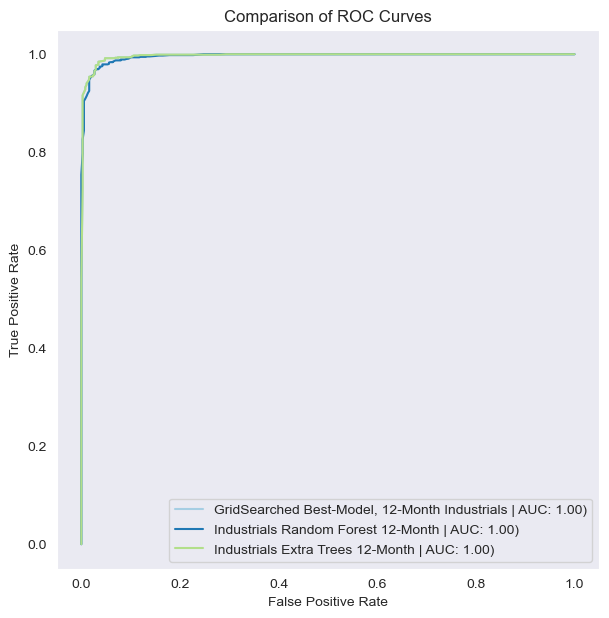

In [163]:
# 3 good models

compare_curves([grid_Ind_12, rfc_Ind_12, etc_Ind_12])

In [164]:
# Importance
features_from_trees(grid_Ind_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08088592361896557)
('Interest_Rates', 0.06442048767633762)
('garman_klass_vol', 0.047053630085464516)
('ATR', 0.046107805797618265)
('lower_bollinger_band', 0.04552517523882348)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12,0.043372,0.043301,0.041702,0.042329,0.038594,0.020396,0.032228,0.039118,0.014428,0.014655,0.015296,0.014777,0.014478,0.027271,0.035211,0.042839,0.042269,0.043720,0.043751,0.042081,0.039812,0.040076,0.020138,0.009356,0.010336,0.009751,0.009346,0.010987,0.009100,0.006790,0.006521,0.010757,0.011436,0.008236,0.008873,0.008051,0.012909,0.009776,0.009569,0.013063,0.014750,0.018489,0.016698,0.006695,0.006356,0.006486,0.006799,0.007030
13,0.038876,0.037232,0.036322,0.038815,0.036084,0.016735,0.049544,0.049392,0.008864,0.009864,0.009552,0.008634,0.009046,0.033461,0.025340,0.040274,0.040421,0.039827,0.041404,0.037636,0.038739,0.027706,0.016760,0.019718,0.021242,0.011758,0.017905,0.013302,0.007605,0.007926,0.008805,0.009406,0.012675,0.010103,0.010188,0.009909,0.011216,0.007661,0.009128,0.022729,0.027734,0.026620,0.024068,0.003454,0.003598,0.004660,0.003891,0.004172
14,0.041869,0.040402,0.040017,0.036027,0.036095,0.017323,0.070269,0.061267,0.006607,0.006153,0.006612,0.006952,0.006542,0.037635,0.018439,0.040140,0.041442,0.041867,0.040682,0.041151,0.033734,0.021007,0.016005,0.015868,0.013544,0.014021,0.023357,0.008812,0.006664,0.005063,0.006275,0.005273,0.008973,0.005632,0.003722,0.005761,0.006106,0.005520,0.010869,0.026018,0.027711,0.036962,0.040539,0.003129,0.003257,0.002576,0.003463,0.002649
15,0.044773,0.038521,0.042057,0.036454,0.038426,0.015269,0.080886,0.064420,0.005305,0.005068,0.006552,0.005926,0.007191,0.047054,0.016353,0.041688,0.045525,0.039965,0.041391,0.036291,0.046108,0.020990,0.013396,0.018804,0.014532,0.010254,0.012241,0.005940,0.003861,0.002759,0.005146,0.004631,0.007956,0.005572,0.007290,0.006670,0.007539,0.004334,0.009354,0.026779,0.030471,0.034758,0.029585,0.002416,0.002559,0.002016,0.002597,0.002324


In [165]:
Importance.df.rename(index={12:"Industrials 1-Month", 13:"Industrials 3-Month", 14:"Industrials 6-Month", \
                            15:"Industrials 12-Month"}, inplace=True)

<hr style="border: 2px solid darkgreen">

#  Technology

### 1 Month

In [169]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "One")


# Create Model Objects

# dummy_tech_1 = dummy_model(Technology, "Technology", 1)
# logreg_tech_1 = l_regr(Technology, "Technology", 1)
# rfc_tech_1 = r_forest(Technology, "Technology", 1)
# etc_tech_1 = extra_trees(Technology, "Technology", 1)
# XGBoost_tech_1 = x_g_b(Technology, "Technology", 1)

# grid_tech_1 = best_etc_grid(estimator=etc_tech_1.model, model_type=Technology, \
#                             sector_name="Technology", time_period=1)

Technology.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Technology Extra Trees 1-Month,0.903416,0.914665,0.928156,0.921318,0.268386,0.918519,0.923830,0.943333,0.933480,0.223019,0.972975
5,"GridSearched Best-Model, 1-Month Technology",0.906337,0.916864,0.930735,0.923710,0.268265,0.917845,0.918280,0.948889,0.933333,0.219043,0.974777
2,Technology Random Forest 1-Month,0.896898,0.899681,0.935157,0.917053,0.310984,0.911785,0.915676,0.941111,0.928219,0.271694,0.967374
4,Technology XGBoost 1-Month,0.855793,0.873756,0.892787,0.882970,0.397663,0.875421,0.886486,0.911111,0.898630,0.326513,0.942359
1,Technology Logistic Regression 1-Month,0.646890,0.660032,0.868092,0.749853,0.641458,0.637037,0.649297,0.872222,0.744429,0.647086,0.629309
0,Dummy Technology 1-Month,0.609614,0.609614,1.000000,0.757466,14.070947,0.606061,0.606061,1.000000,0.754717,14.199015,0.500000


In [170]:
# Importance
features_from_trees(etc_tech_1)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.04398741173770164)
('Close', 0.040796321496672235)
('Adj Close', 0.040641954076051624)
('lowest_bollinger_band', 0.04060118421856076)
('High', 0.04030743209064063)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Industrials 3-Month,0.038876,0.037232,0.036322,0.038815,0.036084,0.016735,0.049544,0.049392,0.008864,0.009864,0.009552,0.008634,0.009046,0.033461,0.025340,0.040274,0.040421,0.039827,0.041404,0.037636,0.038739,0.027706,0.016760,0.019718,0.021242,0.011758,0.017905,0.013302,0.007605,0.007926,0.008805,0.009406,0.012675,0.010103,0.010188,0.009909,0.011216,0.007661,0.009128,0.022729,0.027734,0.026620,0.024068,0.003454,0.003598,0.004660,0.003891,0.004172
Industrials 6-Month,0.041869,0.040402,0.040017,0.036027,0.036095,0.017323,0.070269,0.061267,0.006607,0.006153,0.006612,0.006952,0.006542,0.037635,0.018439,0.040140,0.041442,0.041867,0.040682,0.041151,0.033734,0.021007,0.016005,0.015868,0.013544,0.014021,0.023357,0.008812,0.006664,0.005063,0.006275,0.005273,0.008973,0.005632,0.003722,0.005761,0.006106,0.005520,0.010869,0.026018,0.027711,0.036962,0.040539,0.003129,0.003257,0.002576,0.003463,0.002649
Industrials 12-Month,0.044773,0.038521,0.042057,0.036454,0.038426,0.015269,0.080886,0.064420,0.005305,0.005068,0.006552,0.005926,0.007191,0.047054,0.016353,0.041688,0.045525,0.039965,0.041391,0.036291,0.046108,0.020990,0.013396,0.018804,0.014532,0.010254,0.012241,0.005940,0.003861,0.002759,0.005146,0.004631,0.007956,0.005572,0.007290,0.006670,0.007539,0.004334,0.009354,0.026779,0.030471,0.034758,0.029585,0.002416,0.002559,0.002016,0.002597,0.002324
16,0.040642,0.040796,0.040307,0.039451,0.036313,0.021184,0.033193,0.043987,0.013887,0.013140,0.013951,0.013722,0.013952,0.025638,0.036028,0.040601,0.039976,0.038253,0.039542,0.038517,0.039075,0.038430,0.019075,0.012654,0.016370,0.011691,0.010467,0.010869,0.010025,0.006685,0.009643,0.015607,0.012744,0.013817,0.011467,0.009423,0.016650,0.009530,0.013217,0.013033,0.015226,0.017274,0.013974,0.006019,0.006890,0.005348,0.006151,0.005559


<hr style="border: 2px solid darkgreen">

# XLK 3 Month

In [173]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Three")


# Create Model Objects

# dummy_tech_3 = dummy_model(Technology, "Technology", 3)
# logreg_tech_3 = l_regr(Technology, "Technology", 3)
# rfc_tech_3 = r_forest(Technology, "Technology", 3)
# etc_tech_3 = extra_trees(Technology, "Technology", 3)
# XGBoost_tech_3 = x_g_b(Technology, "Technology", 3)

# grid_tech_3 = best_etc_grid(estimator=rfc_tech_3.model, model_type=Technology, \
#                             sector_name="Technology", time_period=3)

Technology.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
8,Technology Random Forest 3-Month,0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
11,"GridSearched Best-Model, 3-Month Technology",0.952829,0.955530,0.974737,0.964980,0.162295,0.958249,0.959486,0.978831,0.969062,0.155356,0.987532
9,Technology Extra Trees 3-Month,0.954177,0.962222,0.969346,0.965742,0.155678,0.950842,0.955401,0.971774,0.963518,0.123021,0.989951
10,Technology XGBoost 3-Month,0.941600,0.945170,0.968670,0.956737,0.184470,0.940741,0.947525,0.964718,0.956044,0.163719,0.984750
7,Technology Logistic Regression 3-Month,0.731582,0.746544,0.904993,0.817996,0.560196,0.744108,0.758883,0.904234,0.825207,0.552488,0.735721
6,Dummy Technology 3-Month,0.666667,0.666667,1.000000,0.800000,12.014551,0.668013,0.668013,1.000000,0.800969,11.966007,0.500000


In [174]:
# Importance
features_from_trees(rfc_tech_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08228552980814025)
('Interest_Rates', 0.07782046718587995)
('ATR', 0.06002739047957851)
('upper_bollinger_band', 0.05116797816756911)
('Adj Close', 0.04427078870173799)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Industrials 6-Month,0.041869,0.040402,0.040017,0.036027,0.036095,0.017323,0.070269,0.061267,0.006607,0.006153,0.006612,0.006952,0.006542,0.037635,0.018439,0.040140,0.041442,0.041867,0.040682,0.041151,0.033734,0.021007,0.016005,0.015868,0.013544,0.014021,0.023357,0.008812,0.006664,0.005063,0.006275,0.005273,0.008973,0.005632,0.003722,0.005761,0.006106,0.005520,0.010869,0.026018,0.027711,0.036962,0.040539,0.003129,0.003257,0.002576,0.003463,0.002649
Industrials 12-Month,0.044773,0.038521,0.042057,0.036454,0.038426,0.015269,0.080886,0.064420,0.005305,0.005068,0.006552,0.005926,0.007191,0.047054,0.016353,0.041688,0.045525,0.039965,0.041391,0.036291,0.046108,0.020990,0.013396,0.018804,0.014532,0.010254,0.012241,0.005940,0.003861,0.002759,0.005146,0.004631,0.007956,0.005572,0.007290,0.006670,0.007539,0.004334,0.009354,0.026779,0.030471,0.034758,0.029585,0.002416,0.002559,0.002016,0.002597,0.002324
16,0.040642,0.040796,0.040307,0.039451,0.036313,0.021184,0.033193,0.043987,0.013887,0.013140,0.013951,0.013722,0.013952,0.025638,0.036028,0.040601,0.039976,0.038253,0.039542,0.038517,0.039075,0.038430,0.019075,0.012654,0.016370,0.011691,0.010467,0.010869,0.010025,0.006685,0.009643,0.015607,0.012744,0.013817,0.011467,0.009423,0.016650,0.009530,0.013217,0.013033,0.015226,0.017274,0.013974,0.006019,0.006890,0.005348,0.006151,0.005559
17,0.044271,0.044180,0.042546,0.036594,0.037480,0.019075,0.082286,0.077820,0.009922,0.009622,0.010808,0.009750,0.009679,0.037508,0.026749,0.038652,0.039716,0.043394,0.044021,0.051168,0.060027,0.040397,0.023312,0.009824,0.008875,0.008130,0.007530,0.006863,0.004202,0.002220,0.003703,0.003922,0.008923,0.003406,0.005107,0.002647,0.005426,0.002214,0.003369,0.012376,0.015724,0.019481,0.021718,0.000962,0.001193,0.001317,0.000964,0.000930


<hr style="border: 2px solid darkgreen">

# XLK 6 Month

In [177]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Six")


# Create Model Objects

# dummy_tech_6 = dummy_model(Technology, "Technology", 6)
# logreg_tech_6 = l_regr(Technology, "Technology", 6)
# rfc_tech_6 = r_forest(Technology, "Technology", 6)
# etc_tech_6 = extra_trees(Technology, "Technology", 6)
# XGBoost_tech_6 = x_g_b(Technology, "Technology", 6)

# grid_tech_6 = best_etc_grid(estimator=rfc_tech_6.model, model_type=Technology, \
#                             sector_name="Technology", time_period=6)

Technology.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
14,Technology Random Forest 6-Month,0.966305,0.970524,0.981193,0.975822,0.123413,0.965657,0.972538,0.979028,0.975772,0.102938,0.994773
17,"GridSearched Best-Model, 6-Month Technology",0.966305,0.970524,0.981193,0.975822,0.123413,0.965657,0.972538,0.979028,0.975772,0.102938,0.994773
15,Technology Extra Trees 6-Month,0.969900,0.977039,0.979571,0.978301,0.124022,0.964983,0.974310,0.976168,0.975238,0.087117,0.994681
16,Technology XGBoost 6-Month,0.958667,0.966884,0.973734,0.970287,0.126205,0.958923,0.971374,0.970448,0.970911,0.119605,0.990935
13,Technology Logistic Regression 6-Month,0.755615,0.772400,0.917966,0.838816,0.522911,0.764310,0.786710,0.914204,0.845679,0.511809,0.751990
12,Dummy Technology 6-Month,0.692722,0.692722,1.000000,0.818471,11.075404,0.706397,0.706397,1.000000,0.827940,10.582514,0.500000


In [178]:
# Importance
features_from_trees(rfc_tech_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.11175972294430601)
('Interest_Rates', 0.0889810119384046)
('ATR', 0.05364255341392158)
('Close', 0.04892133111770529)
('upper_bollinger_band', 0.04866716346276116)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Industrials 12-Month,0.044773,0.038521,0.042057,0.036454,0.038426,0.015269,0.080886,0.064420,0.005305,0.005068,0.006552,0.005926,0.007191,0.047054,0.016353,0.041688,0.045525,0.039965,0.041391,0.036291,0.046108,0.020990,0.013396,0.018804,0.014532,0.010254,0.012241,0.005940,0.003861,0.002759,0.005146,0.004631,0.007956,0.005572,0.007290,0.006670,0.007539,0.004334,0.009354,0.026779,0.030471,0.034758,0.029585,0.002416,0.002559,0.002016,0.002597,0.002324
16,0.040642,0.040796,0.040307,0.039451,0.036313,0.021184,0.033193,0.043987,0.013887,0.013140,0.013951,0.013722,0.013952,0.025638,0.036028,0.040601,0.039976,0.038253,0.039542,0.038517,0.039075,0.038430,0.019075,0.012654,0.016370,0.011691,0.010467,0.010869,0.010025,0.006685,0.009643,0.015607,0.012744,0.013817,0.011467,0.009423,0.016650,0.009530,0.013217,0.013033,0.015226,0.017274,0.013974,0.006019,0.006890,0.005348,0.006151,0.005559
17,0.044271,0.044180,0.042546,0.036594,0.037480,0.019075,0.082286,0.077820,0.009922,0.009622,0.010808,0.009750,0.009679,0.037508,0.026749,0.038652,0.039716,0.043394,0.044021,0.051168,0.060027,0.040397,0.023312,0.009824,0.008875,0.008130,0.007530,0.006863,0.004202,0.002220,0.003703,0.003922,0.008923,0.003406,0.005107,0.002647,0.005426,0.002214,0.003369,0.012376,0.015724,0.019481,0.021718,0.000962,0.001193,0.001317,0.000964,0.000930
18,0.041676,0.048921,0.044081,0.042937,0.043567,0.024278,0.111760,0.088981,0.006587,0.005844,0.007265,0.007489,0.008898,0.042975,0.016193,0.043865,0.043128,0.043484,0.042703,0.048667,0.053643,0.023723,0.031399,0.008148,0.004914,0.009009,0.004845,0.002956,0.001684,0.002669,0.002298,0.003117,0.004474,0.001869,0.003139,0.002495,0.001985,0.001973,0.003327,0.007842,0.011083,0.027038,0.019775,0.000544,0.000578,0.000674,0.000674,0.000826


<hr style="border: 2px solid darkgreen">

# XLK 12 Month

In [181]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Twelve")


# Create Model Objects

# dummy_tech_12 = dummy_model(Technology, "Technology", 12)
# logreg_tech_12 = l_regr(Technology, "Technology", 12)
# rfc_tech_12 = r_forest(Technology, "Technology", 12)
# etc_tech_12 = extra_trees(Technology, "Technology", 12)
# XGBoost_tech_12 = x_g_b(Technology, "Technology", 12)

# grid_tech_12 = best_etc_grid(estimator=rfc_tech_12.model, model_type=Technology, \
#                             sector_name="Technology", time_period=12)

Technology.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
20,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
21,Technology Extra Trees 12-Month,0.980008,0.984525,0.988911,0.986693,0.072815,0.984512,0.988444,0.991087,0.989764,0.042637,0.999099
22,Technology XGBoost 12-Month,0.977761,0.982164,0.988311,0.985211,0.086091,0.983838,0.986702,0.991979,0.989333,0.054686,0.995889
19,Technology Logistic Regression 12-Month,0.804130,0.841062,0.910999,0.874577,0.376629,0.815488,0.855705,0.909091,0.881590,0.364491,0.869664
18,Dummy Technology 12-Month,0.749551,0.749551,1.000000,0.856849,9.027108,0.755556,0.755556,1.000000,0.860759,8.810671,0.500000


In [182]:
# Importance
features_from_trees(grid_tech_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.1070265288253815)
('Interest_Rates', 0.08949712812130063)
('garman_klass_vol', 0.06371479393169131)
('High', 0.056075028852299875)
('20_day_SMA', 0.052331029608631396)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
16,0.040642,0.040796,0.040307,0.039451,0.036313,0.021184,0.033193,0.043987,0.013887,0.013140,0.013951,0.013722,0.013952,0.025638,0.036028,0.040601,0.039976,0.038253,0.039542,0.038517,0.039075,0.038430,0.019075,0.012654,0.016370,0.011691,0.010467,0.010869,0.010025,0.006685,0.009643,0.015607,0.012744,0.013817,0.011467,0.009423,0.016650,0.009530,0.013217,0.013033,0.015226,0.017274,0.013974,0.006019,0.006890,0.005348,0.006151,0.005559
17,0.044271,0.044180,0.042546,0.036594,0.037480,0.019075,0.082286,0.077820,0.009922,0.009622,0.010808,0.009750,0.009679,0.037508,0.026749,0.038652,0.039716,0.043394,0.044021,0.051168,0.060027,0.040397,0.023312,0.009824,0.008875,0.008130,0.007530,0.006863,0.004202,0.002220,0.003703,0.003922,0.008923,0.003406,0.005107,0.002647,0.005426,0.002214,0.003369,0.012376,0.015724,0.019481,0.021718,0.000962,0.001193,0.001317,0.000964,0.000930
18,0.041676,0.048921,0.044081,0.042937,0.043567,0.024278,0.111760,0.088981,0.006587,0.005844,0.007265,0.007489,0.008898,0.042975,0.016193,0.043865,0.043128,0.043484,0.042703,0.048667,0.053643,0.023723,0.031399,0.008148,0.004914,0.009009,0.004845,0.002956,0.001684,0.002669,0.002298,0.003117,0.004474,0.001869,0.003139,0.002495,0.001985,0.001973,0.003327,0.007842,0.011083,0.027038,0.019775,0.000544,0.000578,0.000674,0.000674,0.000826
19,0.043679,0.047729,0.056075,0.043069,0.039211,0.042784,0.107027,0.089497,0.005100,0.003766,0.005088,0.006880,0.008345,0.063715,0.015296,0.044727,0.045297,0.052331,0.044899,0.048532,0.048914,0.019148,0.046940,0.004455,0.002725,0.002201,0.005569,0.003845,0.000781,0.000904,0.001682,0.001887,0.001335,0.001550,0.001285,0.001124,0.001677,0.000932,0.001041,0.006518,0.008172,0.011440,0.009875,0.000811,0.000410,0.000547,0.000606,0.000581


In [184]:
Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Technology 1-Month,0.040642,0.040796,0.040307,0.039451,0.036313,0.021184,0.033193,0.043987,0.013887,0.013140,0.013951,0.013722,0.013952,0.025638,0.036028,0.040601,0.039976,0.038253,0.039542,0.038517,0.039075,0.038430,0.019075,0.012654,0.016370,0.011691,0.010467,0.010869,0.010025,0.006685,0.009643,0.015607,0.012744,0.013817,0.011467,0.009423,0.016650,0.009530,0.013217,0.013033,0.015226,0.017274,0.013974,0.006019,0.006890,0.005348,0.006151,0.005559
Technology 3-Month,0.044271,0.044180,0.042546,0.036594,0.037480,0.019075,0.082286,0.077820,0.009922,0.009622,0.010808,0.009750,0.009679,0.037508,0.026749,0.038652,0.039716,0.043394,0.044021,0.051168,0.060027,0.040397,0.023312,0.009824,0.008875,0.008130,0.007530,0.006863,0.004202,0.002220,0.003703,0.003922,0.008923,0.003406,0.005107,0.002647,0.005426,0.002214,0.003369,0.012376,0.015724,0.019481,0.021718,0.000962,0.001193,0.001317,0.000964,0.000930
Technology 6-Month,0.041676,0.048921,0.044081,0.042937,0.043567,0.024278,0.111760,0.088981,0.006587,0.005844,0.007265,0.007489,0.008898,0.042975,0.016193,0.043865,0.043128,0.043484,0.042703,0.048667,0.053643,0.023723,0.031399,0.008148,0.004914,0.009009,0.004845,0.002956,0.001684,0.002669,0.002298,0.003117,0.004474,0.001869,0.003139,0.002495,0.001985,0.001973,0.003327,0.007842,0.011083,0.027038,0.019775,0.000544,0.000578,0.000674,0.000674,0.000826
Technology 12-Month,0.043679,0.047729,0.056075,0.043069,0.039211,0.042784,0.107027,0.089497,0.005100,0.003766,0.005088,0.006880,0.008345,0.063715,0.015296,0.044727,0.045297,0.052331,0.044899,0.048532,0.048914,0.019148,0.046940,0.004455,0.002725,0.002201,0.005569,0.003845,0.000781,0.000904,0.001682,0.001887,0.001335,0.001550,0.001285,0.001124,0.001677,0.000932,0.001041,0.006518,0.008172,0.011440,0.009875,0.000811,0.000410,0.000547,0.000606,0.000581


In [183]:
Importance.df.rename(index={16:"Technology 1-Month", 17:"Technology 3-Month", 18:"Technology 6-Month", \
                            19:"Technology 12-Month"}, inplace=True)

<hr style="border: 2px solid darkgreen">

#  Staples - XLP

### 1 Month

In [187]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "One")


# Create Model Objects

# dummy_stap_1 = dummy_model(Staples, "Staples", 1)
# logreg_stap_1 = l_regr(Staples, "Staples", 1)
# rfc_stap_1 = r_forest(Staples, "Staples", 1)
# etc_stap_1 = extra_trees(Staples, "Staples", 1)
# XGBoost_stap_1 = x_g_b(Staples, "Staples", 1)

# grid_stap_1 = best_etc_grid(estimator=etc_stap_1.model, model_type=Staples, \
#                             sector_name="Staples", time_period=1)

Staples.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Staples",0.898474,0.907922,0.933713,0.920610,0.310036,0.904377,0.902821,0.946331,0.924064,0.252725,0.962056
3,Staples Extra Trees 1-Month,0.897575,0.907596,0.932645,0.919886,0.292828,0.901010,0.899791,0.944140,0.921432,0.253521,0.962060
2,Staples Random Forest 1-Month,0.887466,0.889983,0.937632,0.913116,0.325447,0.897643,0.892673,0.947426,0.919235,0.298690,0.956293
4,Staples XGBoost 1-Month,0.840968,0.856385,0.898427,0.876870,0.424135,0.861279,0.864058,0.918949,0.890658,0.386387,0.921363
1,Staples Logistic Regression 1-Month,0.656557,0.670223,0.895946,0.766765,0.625169,0.659259,0.663454,0.904710,0.765524,0.617903,0.679068
0,Dummy Staples 1-Month,0.630279,0.630279,1.000000,0.773216,13.326111,0.614815,0.614815,1.000000,0.761468,13.883481,0.500000


In [188]:
# Feature importance for the best model

features_from_trees(grid_stap_1)
Importance.df[-4:]

Top 5 Feature Importances
('one_up_bollinger_band', 0.04632102852291705)
('20_day_SMA', 0.04446857051114444)
('lower_bollinger_band', 0.044289526657427455)
('upper_bollinger_band', 0.04370099527672225)
('lowest_bollinger_band', 0.04334012862860415)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Technology 3-Month,0.044271,0.044180,0.042546,0.036594,0.037480,0.019075,0.082286,0.077820,0.009922,0.009622,0.010808,0.009750,0.009679,0.037508,0.026749,0.038652,0.039716,0.043394,0.044021,0.051168,0.060027,0.040397,0.023312,0.009824,0.008875,0.008130,0.007530,0.006863,0.004202,0.002220,0.003703,0.003922,0.008923,0.003406,0.005107,0.002647,0.005426,0.002214,0.003369,0.012376,0.015724,0.019481,0.021718,0.000962,0.001193,0.001317,0.000964,0.000930
Technology 6-Month,0.041676,0.048921,0.044081,0.042937,0.043567,0.024278,0.111760,0.088981,0.006587,0.005844,0.007265,0.007489,0.008898,0.042975,0.016193,0.043865,0.043128,0.043484,0.042703,0.048667,0.053643,0.023723,0.031399,0.008148,0.004914,0.009009,0.004845,0.002956,0.001684,0.002669,0.002298,0.003117,0.004474,0.001869,0.003139,0.002495,0.001985,0.001973,0.003327,0.007842,0.011083,0.027038,0.019775,0.000544,0.000578,0.000674,0.000674,0.000826
Technology 12-Month,0.043679,0.047729,0.056075,0.043069,0.039211,0.042784,0.107027,0.089497,0.005100,0.003766,0.005088,0.006880,0.008345,0.063715,0.015296,0.044727,0.045297,0.052331,0.044899,0.048532,0.048914,0.019148,0.046940,0.004455,0.002725,0.002201,0.005569,0.003845,0.000781,0.000904,0.001682,0.001887,0.001335,0.001550,0.001285,0.001124,0.001677,0.000932,0.001041,0.006518,0.008172,0.011440,0.009875,0.000811,0.000410,0.000547,0.000606,0.000581
20,0.042452,0.040807,0.040641,0.039763,0.038527,0.019199,0.029691,0.040024,0.015790,0.015573,0.016256,0.015020,0.015729,0.028402,0.034601,0.043340,0.044290,0.044469,0.046321,0.043701,0.040906,0.039448,0.018692,0.011863,0.009252,0.010068,0.008216,0.011717,0.009257,0.006949,0.007459,0.010273,0.010476,0.009388,0.010891,0.009072,0.011616,0.007069,0.009374,0.013240,0.016747,0.011612,0.012587,0.008225,0.008035,0.007615,0.007608,0.007752


<hr style="border: 2px solid darkgreen">

# XLP 3 Month

In [191]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Three")


# Create Model Objects

# dummy_stap_3 = dummy_model(Staples, "Staples", 3)
# logreg_stap_3 = l_regr(Staples, "Staples", 3)
# rfc_stap_3 = r_forest(Staples, "Staples", 3)
# etc_stap_3 = extra_trees(Staples, "Staples", 3)
# XGBoost_stap_3 = x_g_b(Staples, "Staples", 3)

# grid_stap_3 = best_etc_grid(estimator=etc_stap_3.model, model_type=Staples, \
#                             sector_name="Staples", time_period=3)

Staples.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Staples Extra Trees 3-Month,0.934187,0.947411,0.956421,0.951874,0.180488,0.936700,0.946341,0.961348,0.953786,0.234230,0.978467
11,"GridSearched Best-Model, 3-Month Staples",0.934187,0.947411,0.956421,0.951874,0.180488,0.936700,0.946341,0.961348,0.953786,0.234230,0.978467
8,Staples Random Forest 3-Month,0.924528,0.936162,0.954112,0.945042,0.216062,0.932660,0.943415,0.958375,0.950836,0.192524,0.980226
10,Staples XGBoost 3-Month,0.912397,0.925836,0.947176,0.936355,0.263155,0.924579,0.935015,0.955401,0.945098,0.215120,0.972189
7,Staples Logistic Regression 3-Month,0.733601,0.748900,0.915809,0.823917,0.542593,0.738721,0.756400,0.907830,0.825225,0.542031,0.738061
6,Dummy Staples 3-Month,0.680368,0.680368,1.000000,0.809785,11.520688,0.679461,0.679461,1.000000,0.809142,11.553387,0.500000


In [192]:
# Feature importances of the best models

features_from_trees(etc_stap_3)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.051740458846366987)
('GDP_Filled', 0.05070445775928548)
('High', 0.044765023579906596)
('20_day_SMA', 0.04205172998219891)
('lower_bollinger_band', 0.041496615608843296)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Technology 6-Month,0.041676,0.048921,0.044081,0.042937,0.043567,0.024278,0.111760,0.088981,0.006587,0.005844,0.007265,0.007489,0.008898,0.042975,0.016193,0.043865,0.043128,0.043484,0.042703,0.048667,0.053643,0.023723,0.031399,0.008148,0.004914,0.009009,0.004845,0.002956,0.001684,0.002669,0.002298,0.003117,0.004474,0.001869,0.003139,0.002495,0.001985,0.001973,0.003327,0.007842,0.011083,0.027038,0.019775,0.000544,0.000578,0.000674,0.000674,0.000826
Technology 12-Month,0.043679,0.047729,0.056075,0.043069,0.039211,0.042784,0.107027,0.089497,0.005100,0.003766,0.005088,0.006880,0.008345,0.063715,0.015296,0.044727,0.045297,0.052331,0.044899,0.048532,0.048914,0.019148,0.046940,0.004455,0.002725,0.002201,0.005569,0.003845,0.000781,0.000904,0.001682,0.001887,0.001335,0.001550,0.001285,0.001124,0.001677,0.000932,0.001041,0.006518,0.008172,0.011440,0.009875,0.000811,0.000410,0.000547,0.000606,0.000581
20,0.042452,0.040807,0.040641,0.039763,0.038527,0.019199,0.029691,0.040024,0.015790,0.015573,0.016256,0.015020,0.015729,0.028402,0.034601,0.043340,0.044290,0.044469,0.046321,0.043701,0.040906,0.039448,0.018692,0.011863,0.009252,0.010068,0.008216,0.011717,0.009257,0.006949,0.007459,0.010273,0.010476,0.009388,0.010891,0.009072,0.011616,0.007069,0.009374,0.013240,0.016747,0.011612,0.012587,0.008225,0.008035,0.007615,0.007608,0.007752
21,0.040399,0.040377,0.044765,0.039047,0.036535,0.015552,0.050704,0.051740,0.010387,0.010003,0.010792,0.010072,0.010018,0.039282,0.026207,0.040240,0.041497,0.042052,0.036843,0.038172,0.038180,0.030357,0.016120,0.017161,0.014469,0.018703,0.013265,0.013119,0.006758,0.006796,0.011312,0.005677,0.010057,0.008393,0.009444,0.010241,0.009598,0.008169,0.009534,0.013559,0.024822,0.022448,0.024363,0.004431,0.004513,0.004548,0.004639,0.004637


<hr style="border: 2px solid darkgreen">

# XLP 6 Month

In [195]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Six")


# Create Model Objects

# dummy_stap_6 = dummy_model(Staples, "Staples", 6)
# logreg_stap_6 = l_regr(Staples, "Staples", 6)
# rfc_stap_6 = r_forest(Staples, "Staples", 6)
# etc_stap_6 = extra_trees(Staples, "Staples", 6)
# XGBoost_stap_6 = x_g_b(Staples, "Staples", 6)

# grid_stap_6 = best_etc_grid(estimator=etc_stap_6.model, model_type=Staples, \
#                             sector_name="Staples", time_period=6)

Staples.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Staples Extra Trees 6-Month,0.952830,0.963514,0.973385,0.968410,0.130524,0.962963,0.964416,0.985089,0.974643,0.136564,0.988749
17,"GridSearched Best-Model, 6-Month Staples",0.953954,0.963288,0.975200,0.969192,0.159390,0.956902,0.959054,0.982293,0.970534,0.119331,0.989512
14,Staples Random Forest 6-Month,0.950132,0.957066,0.976711,0.966774,0.165306,0.956229,0.954874,0.986021,0.970197,0.136825,0.988562
16,Staples XGBoost 6-Month,0.942943,0.952601,0.971567,0.961977,0.194765,0.947475,0.946990,0.982293,0.964318,0.171039,0.981732
13,Staples Logistic Regression 6-Month,0.800983,0.811948,0.952810,0.876708,0.456826,0.793939,0.802684,0.947810,0.869231,0.453253,0.805330
12,Dummy Staples 6-Month,0.742588,0.742588,1.000000,0.852282,9.278081,0.722559,0.722559,1.000000,0.838937,9.999990,0.500000


In [196]:
# Importance
features_from_trees(etc_stap_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.0674316663074221)
('Interest_Rates', 0.06281365736192338)
('ATR', 0.045158098886613825)
('garman_klass_vol', 0.04253834549203063)
('lower_bollinger_band', 0.041215008584289545)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Technology 12-Month,0.043679,0.047729,0.056075,0.043069,0.039211,0.042784,0.107027,0.089497,0.005100,0.003766,0.005088,0.006880,0.008345,0.063715,0.015296,0.044727,0.045297,0.052331,0.044899,0.048532,0.048914,0.019148,0.046940,0.004455,0.002725,0.002201,0.005569,0.003845,0.000781,0.000904,0.001682,0.001887,0.001335,0.001550,0.001285,0.001124,0.001677,0.000932,0.001041,0.006518,0.008172,0.011440,0.009875,0.000811,0.000410,0.000547,0.000606,0.000581
20,0.042452,0.040807,0.040641,0.039763,0.038527,0.019199,0.029691,0.040024,0.015790,0.015573,0.016256,0.015020,0.015729,0.028402,0.034601,0.043340,0.044290,0.044469,0.046321,0.043701,0.040906,0.039448,0.018692,0.011863,0.009252,0.010068,0.008216,0.011717,0.009257,0.006949,0.007459,0.010273,0.010476,0.009388,0.010891,0.009072,0.011616,0.007069,0.009374,0.013240,0.016747,0.011612,0.012587,0.008225,0.008035,0.007615,0.007608,0.007752
21,0.040399,0.040377,0.044765,0.039047,0.036535,0.015552,0.050704,0.051740,0.010387,0.010003,0.010792,0.010072,0.010018,0.039282,0.026207,0.040240,0.041497,0.042052,0.036843,0.038172,0.038180,0.030357,0.016120,0.017161,0.014469,0.018703,0.013265,0.013119,0.006758,0.006796,0.011312,0.005677,0.010057,0.008393,0.009444,0.010241,0.009598,0.008169,0.009534,0.013559,0.024822,0.022448,0.024363,0.004431,0.004513,0.004548,0.004639,0.004637
22,0.039965,0.037756,0.038987,0.037214,0.035989,0.015150,0.067432,0.062814,0.007753,0.007224,0.008924,0.008763,0.009057,0.042538,0.020994,0.038909,0.041215,0.040794,0.038959,0.038621,0.045158,0.022659,0.015736,0.019825,0.012950,0.011977,0.015937,0.010298,0.006777,0.004674,0.011186,0.010585,0.013804,0.005707,0.005868,0.005604,0.008773,0.005496,0.006165,0.020842,0.029193,0.025658,0.029480,0.003033,0.003214,0.003715,0.003423,0.003204


<hr style="border: 2px solid darkgreen">

# XLP 12 Month

In [199]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Twelve")


# Create Model Objects

# dummy_stap_12 = dummy_model(Staples, "Staples", 12)
# logreg_stap_12 = l_regr(Staples, "Staples", 12)
# rfc_stap_12 = r_forest(Staples, "Staples", 12)
# etc_stap_12 = extra_trees(Staples, "Staples", 12)
# XGBoost_stap_12 = x_g_b(Staples, "Staples", 12)

# grid_stap_12 = best_etc_grid(estimator=etc_stap_12.model, model_type=Staples, \
#                             sector_name="Staples", time_period=12)

Staples.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Staples Extra Trees 12-Month,0.977313,0.984189,0.988223,0.986197,0.089298,0.980471,0.982673,0.993328,0.987972,0.056970,0.997498
23,"GridSearched Best-Model, 12-Month Staples",0.977313,0.984189,0.988223,0.986197,0.089298,0.980471,0.982673,0.993328,0.987972,0.056970,0.997498
20,Staples Random Forest 12-Month,0.975966,0.982589,0.988223,0.985390,0.072484,0.975758,0.977814,0.992494,0.985099,0.070672,0.996041
22,Staples XGBoost 12-Month,0.969901,0.978266,0.985209,0.981716,0.092897,0.972391,0.973813,0.992494,0.983065,0.077629,0.995375
19,Staples Logistic Regression 12-Month,0.878929,0.888864,0.974252,0.929565,0.307832,0.880808,0.883634,0.981651,0.930067,0.299201,0.895577
18,Dummy Staples 12-Month,0.820081,0.820081,1.000000,0.901148,6.484940,0.807407,0.807407,1.000000,0.893443,6.941741,0.500000


In [200]:
# Top 5 feature importances for the best model

features_from_trees(etc_stap_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.09151381708515169)
('garman_klass_vol', 0.06662797806562995)
('Interest_Rates', 0.06528193610049772)
('Close', 0.053243543643564394)
('High', 0.052913587889206845)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
20,0.042452,0.040807,0.040641,0.039763,0.038527,0.019199,0.029691,0.040024,0.015790,0.015573,0.016256,0.015020,0.015729,0.028402,0.034601,0.043340,0.044290,0.044469,0.046321,0.043701,0.040906,0.039448,0.018692,0.011863,0.009252,0.010068,0.008216,0.011717,0.009257,0.006949,0.007459,0.010273,0.010476,0.009388,0.010891,0.009072,0.011616,0.007069,0.009374,0.013240,0.016747,0.011612,0.012587,0.008225,0.008035,0.007615,0.007608,0.007752
21,0.040399,0.040377,0.044765,0.039047,0.036535,0.015552,0.050704,0.051740,0.010387,0.010003,0.010792,0.010072,0.010018,0.039282,0.026207,0.040240,0.041497,0.042052,0.036843,0.038172,0.038180,0.030357,0.016120,0.017161,0.014469,0.018703,0.013265,0.013119,0.006758,0.006796,0.011312,0.005677,0.010057,0.008393,0.009444,0.010241,0.009598,0.008169,0.009534,0.013559,0.024822,0.022448,0.024363,0.004431,0.004513,0.004548,0.004639,0.004637
22,0.039965,0.037756,0.038987,0.037214,0.035989,0.015150,0.067432,0.062814,0.007753,0.007224,0.008924,0.008763,0.009057,0.042538,0.020994,0.038909,0.041215,0.040794,0.038959,0.038621,0.045158,0.022659,0.015736,0.019825,0.012950,0.011977,0.015937,0.010298,0.006777,0.004674,0.011186,0.010585,0.013804,0.005707,0.005868,0.005604,0.008773,0.005496,0.006165,0.020842,0.029193,0.025658,0.029480,0.003033,0.003214,0.003715,0.003423,0.003204
23,0.038488,0.053244,0.052914,0.046834,0.051681,0.015811,0.091514,0.065282,0.004495,0.004711,0.005314,0.005616,0.005531,0.066628,0.013984,0.043848,0.044507,0.041511,0.037996,0.043443,0.033365,0.012724,0.012615,0.007623,0.011841,0.009908,0.009933,0.004820,0.004536,0.004314,0.002225,0.001980,0.005790,0.005500,0.003212,0.002994,0.006530,0.006459,0.005352,0.022162,0.026528,0.014755,0.040681,0.001914,0.002625,0.001927,0.002502,0.001830


In [202]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Staples 1-Month,0.042452,0.040807,0.040641,0.039763,0.038527,0.019199,0.029691,0.040024,0.015790,0.015573,0.016256,0.015020,0.015729,0.028402,0.034601,0.043340,0.044290,0.044469,0.046321,0.043701,0.040906,0.039448,0.018692,0.011863,0.009252,0.010068,0.008216,0.011717,0.009257,0.006949,0.007459,0.010273,0.010476,0.009388,0.010891,0.009072,0.011616,0.007069,0.009374,0.013240,0.016747,0.011612,0.012587,0.008225,0.008035,0.007615,0.007608,0.007752
Staples 3-Month,0.040399,0.040377,0.044765,0.039047,0.036535,0.015552,0.050704,0.051740,0.010387,0.010003,0.010792,0.010072,0.010018,0.039282,0.026207,0.040240,0.041497,0.042052,0.036843,0.038172,0.038180,0.030357,0.016120,0.017161,0.014469,0.018703,0.013265,0.013119,0.006758,0.006796,0.011312,0.005677,0.010057,0.008393,0.009444,0.010241,0.009598,0.008169,0.009534,0.013559,0.024822,0.022448,0.024363,0.004431,0.004513,0.004548,0.004639,0.004637
Staples 6-Month,0.039965,0.037756,0.038987,0.037214,0.035989,0.015150,0.067432,0.062814,0.007753,0.007224,0.008924,0.008763,0.009057,0.042538,0.020994,0.038909,0.041215,0.040794,0.038959,0.038621,0.045158,0.022659,0.015736,0.019825,0.012950,0.011977,0.015937,0.010298,0.006777,0.004674,0.011186,0.010585,0.013804,0.005707,0.005868,0.005604,0.008773,0.005496,0.006165,0.020842,0.029193,0.025658,0.029480,0.003033,0.003214,0.003715,0.003423,0.003204
Staples 12-Month,0.038488,0.053244,0.052914,0.046834,0.051681,0.015811,0.091514,0.065282,0.004495,0.004711,0.005314,0.005616,0.005531,0.066628,0.013984,0.043848,0.044507,0.041511,0.037996,0.043443,0.033365,0.012724,0.012615,0.007623,0.011841,0.009908,0.009933,0.004820,0.004536,0.004314,0.002225,0.001980,0.005790,0.005500,0.003212,0.002994,0.006530,0.006459,0.005352,0.022162,0.026528,0.014755,0.040681,0.001914,0.002625,0.001927,0.002502,0.001830


In [201]:
Importance.df.rename(index={20:"Staples 1-Month", 21:"Staples 3-Month", 22:"Staples 6-Month", \
                            23:"Staples 12-Month"}, inplace=True)

<hr style="border: 2px solid darkred">

# Utilites - XLU

### 1 Month

In [205]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "One")


# Create Model Objects
                            
# dummy_U_1 = dummy_model(Utilities, "Utilities", 1)
# logreg_U_1 = l_regr(Utilities, "Utilities", 1)
# rfc_U_1 = r_forest(Utilities, "Utilities", 1)
# etc_U_1 = extra_trees(Utilities, "Utilities", 1)
# XGBoost_U_1 = x_g_b(Utilities, "Utilities", 1)

# grid_U_1 = best_etc_grid(estimator=rfc_U_1.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=1)

Utilities.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
2,Utilities Random Forest 1-Month,0.890840,0.890631,0.939583,0.914429,0.325502,0.910438,0.913319,0.944262,0.928533,0.274194,0.970461
3,Utilities Extra Trees 1-Month,0.906338,0.913075,0.938498,0.925588,0.271951,0.909764,0.924918,0.928962,0.926936,0.228595,0.972354
5,"GridSearched Best-Model, 1-Month Utilities",0.894434,0.891280,0.945372,0.917497,0.326203,0.909091,0.912262,0.943169,0.927458,0.277975,0.970492
4,Utilities XGBoost 1-Month,0.852654,0.866004,0.902316,0.883775,0.418997,0.868013,0.881230,0.908197,0.894510,0.359412,0.928933
1,Utilities Logistic Regression 1-Month,0.673403,0.690181,0.859974,0.765657,0.607878,0.681481,0.693860,0.864481,0.769830,0.582893,0.743133
0,Dummy Utilities 1-Month,0.620845,0.620845,1.000000,0.766075,13.666144,0.616162,0.616162,1.000000,0.762500,13.834938,0.500000


In [206]:
# Feature importance for the best model

features_from_trees(etc_U_1)
Importance.df[-4:]

Top 5 Feature Importances
('MACD', 0.044033982672932855)
('lower_bollinger_band', 0.04354944720277158)
('upper_bollinger_band', 0.04237001814068935)
('20_day_SMA', 0.04231289228506313)
('lowest_bollinger_band', 0.04227605215658117)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Staples 3-Month,0.040399,0.040377,0.044765,0.039047,0.036535,0.015552,0.050704,0.051740,0.010387,0.010003,0.010792,0.010072,0.010018,0.039282,0.026207,0.040240,0.041497,0.042052,0.036843,0.038172,0.038180,0.030357,0.016120,0.017161,0.014469,0.018703,0.013265,0.013119,0.006758,0.006796,0.011312,0.005677,0.010057,0.008393,0.009444,0.010241,0.009598,0.008169,0.009534,0.013559,0.024822,0.022448,0.024363,0.004431,0.004513,0.004548,0.004639,0.004637
Staples 6-Month,0.039965,0.037756,0.038987,0.037214,0.035989,0.015150,0.067432,0.062814,0.007753,0.007224,0.008924,0.008763,0.009057,0.042538,0.020994,0.038909,0.041215,0.040794,0.038959,0.038621,0.045158,0.022659,0.015736,0.019825,0.012950,0.011977,0.015937,0.010298,0.006777,0.004674,0.011186,0.010585,0.013804,0.005707,0.005868,0.005604,0.008773,0.005496,0.006165,0.020842,0.029193,0.025658,0.029480,0.003033,0.003214,0.003715,0.003423,0.003204
Staples 12-Month,0.038488,0.053244,0.052914,0.046834,0.051681,0.015811,0.091514,0.065282,0.004495,0.004711,0.005314,0.005616,0.005531,0.066628,0.013984,0.043848,0.044507,0.041511,0.037996,0.043443,0.033365,0.012724,0.012615,0.007623,0.011841,0.009908,0.009933,0.004820,0.004536,0.004314,0.002225,0.001980,0.005790,0.005500,0.003212,0.002994,0.006530,0.006459,0.005352,0.022162,0.026528,0.014755,0.040681,0.001914,0.002625,0.001927,0.002502,0.001830
24,0.040055,0.041260,0.039999,0.039055,0.036902,0.019481,0.031926,0.039918,0.013566,0.013923,0.014774,0.014686,0.014529,0.033842,0.033429,0.042276,0.043549,0.042313,0.040856,0.042370,0.036812,0.044034,0.020660,0.012668,0.013362,0.012496,0.010430,0.009490,0.013740,0.007303,0.011138,0.009453,0.011258,0.009478,0.009837,0.008942,0.010848,0.008741,0.010670,0.011200,0.016542,0.014310,0.017486,0.005993,0.006717,0.005663,0.006361,0.005658


<hr style="border: 2px solid darkgreen">

# XLU 3 Month 

In [209]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Three")


# Create Model Objects
                            
# dummy_U_3 = dummy_model(Utilities, "Utilities", 3)
# logreg_U_3 = l_regr(Utilities, "Utilities", 3)
# rfc_U_3 = r_forest(Utilities, "Utilities", 3)
# etc_U_3 = extra_trees(Utilities, "Utilities", 3)
# XGBoost_U_3 = x_g_b(Utilities, "Utilities", 3)

# grid_U_3 = best_etc_grid(estimator=rfc_U_3.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=3)

Utilities.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,"GridSearched Best-Model, 3-Month Utilities",0.940249,0.944565,0.967369,0.955811,0.186382,0.953535,0.953862,0.976386,0.964992,0.158876,0.987728
8,Utilities Random Forest 3-Month,0.939125,0.946224,0.963667,0.954835,0.192019,0.952862,0.954728,0.974333,0.964431,0.156063,0.987626
9,Utilities Extra Trees 3-Month,0.944068,0.951359,0.965688,0.958448,0.151382,0.952862,0.959350,0.969199,0.964249,0.130798,0.989028
10,Utilities XGBoost 3-Month,0.924527,0.933955,0.954587,0.944128,0.229371,0.945455,0.951466,0.966119,0.958737,0.172175,0.982548
7,Utilities Logistic Regression 3-Month,0.753145,0.767149,0.905470,0.830440,0.517439,0.738047,0.753686,0.892197,0.817113,0.518504,0.783980
6,Dummy Utilities 3-Month,0.667790,0.667790,1.000000,0.800808,11.974071,0.655892,0.655892,1.000000,0.792192,12.402900,0.500000


In [210]:
# Feature importances of the best model

features_from_trees(grid_U_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.061653011183258)
('Interest_Rates', 0.05574267754415943)
('garman_klass_vol', 0.051197235407651524)
('one_up_bollinger_band', 0.0493687816426504)
('ATR', 0.04842755748925279)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Staples 6-Month,0.039965,0.037756,0.038987,0.037214,0.035989,0.015150,0.067432,0.062814,0.007753,0.007224,0.008924,0.008763,0.009057,0.042538,0.020994,0.038909,0.041215,0.040794,0.038959,0.038621,0.045158,0.022659,0.015736,0.019825,0.012950,0.011977,0.015937,0.010298,0.006777,0.004674,0.011186,0.010585,0.013804,0.005707,0.005868,0.005604,0.008773,0.005496,0.006165,0.020842,0.029193,0.025658,0.029480,0.003033,0.003214,0.003715,0.003423,0.003204
Staples 12-Month,0.038488,0.053244,0.052914,0.046834,0.051681,0.015811,0.091514,0.065282,0.004495,0.004711,0.005314,0.005616,0.005531,0.066628,0.013984,0.043848,0.044507,0.041511,0.037996,0.043443,0.033365,0.012724,0.012615,0.007623,0.011841,0.009908,0.009933,0.004820,0.004536,0.004314,0.002225,0.001980,0.005790,0.005500,0.003212,0.002994,0.006530,0.006459,0.005352,0.022162,0.026528,0.014755,0.040681,0.001914,0.002625,0.001927,0.002502,0.001830
24,0.040055,0.041260,0.039999,0.039055,0.036902,0.019481,0.031926,0.039918,0.013566,0.013923,0.014774,0.014686,0.014529,0.033842,0.033429,0.042276,0.043549,0.042313,0.040856,0.042370,0.036812,0.044034,0.020660,0.012668,0.013362,0.012496,0.010430,0.009490,0.013740,0.007303,0.011138,0.009453,0.011258,0.009478,0.009837,0.008942,0.010848,0.008741,0.010670,0.011200,0.016542,0.014310,0.017486,0.005993,0.006717,0.005663,0.006361,0.005658
25,0.042112,0.040306,0.042279,0.043411,0.040563,0.026252,0.061653,0.055743,0.011227,0.011195,0.013653,0.011982,0.010848,0.051197,0.037035,0.044575,0.043858,0.047684,0.049369,0.048165,0.048428,0.047755,0.024804,0.014462,0.008882,0.010612,0.010769,0.003941,0.005743,0.005026,0.005566,0.005965,0.004890,0.002844,0.005802,0.003528,0.002317,0.002987,0.003107,0.007457,0.012082,0.009354,0.013683,0.001545,0.001294,0.001592,0.001347,0.001114


<hr style="border: 2px solid darkgreen">

# XLU 6 Month

In [213]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Six")


# Create Model Objects
                            
# dummy_U_6 = dummy_model(Utilities, "Utilities", 6)
# logreg_U_6 = l_regr(Utilities, "Utilities", 6)
# rfc_U_6 = r_forest(Utilities, "Utilities", 6)
# etc_U_6 = extra_trees(Utilities, "Utilities", 6)
# XGBoost_U_6 = x_g_b(Utilities, "Utilities", 6)

# grid_U_6 = best_etc_grid(estimator=etc_U_6.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=6)

Utilities.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Utilities Extra Trees 6-Month,0.965634,0.974588,0.977287,0.975913,0.108074,0.967677,0.975214,0.978947,0.977077,0.092534,0.994655
14,Utilities Random Forest 6-Month,0.962490,0.969725,0.977918,0.973790,0.121178,0.966330,0.972460,0.979904,0.976168,0.106417,0.994538
17,"GridSearched Best-Model, 6-Month Utilities",0.966533,0.975211,0.977918,0.976544,0.116739,0.966330,0.972460,0.979904,0.976168,0.092831,0.994630
16,Utilities XGBoost 6-Month,0.956872,0.965378,0.974448,0.969869,0.137887,0.954882,0.959586,0.977033,0.968231,0.146809,0.989687
13,Utilities Logistic Regression 6-Month,0.825924,0.845764,0.924290,0.883207,0.382576,0.841751,0.853403,0.935885,0.892743,0.371508,0.884761
12,Dummy Utilities 6-Month,0.712040,0.712040,1.000000,0.831803,10.379140,0.703704,0.703704,1.000000,0.826087,10.679601,0.500000


In [214]:
# Top 5 important features from the best model

features_from_trees(grid_U_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.06238380267031633)
('Interest_Rates', 0.06024267710634702)
('garman_klass_vol', 0.04869028852390933)
('lower_bollinger_band', 0.04434529548899703)
('High', 0.04341866284341467)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Staples 12-Month,0.038488,0.053244,0.052914,0.046834,0.051681,0.015811,0.091514,0.065282,0.004495,0.004711,0.005314,0.005616,0.005531,0.066628,0.013984,0.043848,0.044507,0.041511,0.037996,0.043443,0.033365,0.012724,0.012615,0.007623,0.011841,0.009908,0.009933,0.004820,0.004536,0.004314,0.002225,0.001980,0.005790,0.005500,0.003212,0.002994,0.006530,0.006459,0.005352,0.022162,0.026528,0.014755,0.040681,0.001914,0.002625,0.001927,0.002502,0.001830
24,0.040055,0.041260,0.039999,0.039055,0.036902,0.019481,0.031926,0.039918,0.013566,0.013923,0.014774,0.014686,0.014529,0.033842,0.033429,0.042276,0.043549,0.042313,0.040856,0.042370,0.036812,0.044034,0.020660,0.012668,0.013362,0.012496,0.010430,0.009490,0.013740,0.007303,0.011138,0.009453,0.011258,0.009478,0.009837,0.008942,0.010848,0.008741,0.010670,0.011200,0.016542,0.014310,0.017486,0.005993,0.006717,0.005663,0.006361,0.005658
25,0.042112,0.040306,0.042279,0.043411,0.040563,0.026252,0.061653,0.055743,0.011227,0.011195,0.013653,0.011982,0.010848,0.051197,0.037035,0.044575,0.043858,0.047684,0.049369,0.048165,0.048428,0.047755,0.024804,0.014462,0.008882,0.010612,0.010769,0.003941,0.005743,0.005026,0.005566,0.005965,0.004890,0.002844,0.005802,0.003528,0.002317,0.002987,0.003107,0.007457,0.012082,0.009354,0.013683,0.001545,0.001294,0.001592,0.001347,0.001114
26,0.042312,0.040666,0.043419,0.042048,0.038634,0.014663,0.062384,0.060243,0.006521,0.006764,0.007095,0.006282,0.007108,0.048690,0.021855,0.041389,0.044345,0.042507,0.040133,0.040485,0.038047,0.027083,0.015047,0.015669,0.015671,0.013059,0.019106,0.007073,0.006135,0.007219,0.007639,0.003919,0.006825,0.004455,0.005842,0.006746,0.007688,0.006260,0.009097,0.017894,0.029123,0.022398,0.034988,0.003371,0.003323,0.002677,0.002683,0.003422


<hr style="border: 2px solid darkgreen">

# XLU 12 Month

In [217]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Twelve")


# Create Model Objects
                            
# dummy_U_12 = dummy_model(Utilities, "Utilities", 12)
# logreg_U_12 = l_regr(Utilities, "Utilities", 12)
# rfc_U_12 = r_forest(Utilities, "Utilities", 12)
# etc_U_12 = extra_trees(Utilities, "Utilities", 12)
# XGBoost_U_12 = x_g_b(Utilities, "Utilities", 12)

# grid_U_12 = best_etc_grid(estimator=etc_U_12.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=12)

Utilities.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Utilities Extra Trees 12-Month,0.975515,0.983470,0.984884,0.984168,0.078756,0.971717,0.982624,0.980919,0.981771,0.085716,0.995115
23,"GridSearched Best-Model, 12-Month Utilities",0.977538,0.984921,0.986047,0.985477,0.078892,0.971717,0.983464,0.980052,0.981755,0.087481,0.994842
22,Utilities XGBoost 12-Month,0.972370,0.980588,0.983721,0.982145,0.093864,0.967677,0.980017,0.978317,0.979167,0.105650,0.993388
20,Utilities Random Forest 12-Month,0.974168,0.979524,0.987209,0.983348,0.092117,0.967003,0.978336,0.979185,0.978760,0.097258,0.994257
19,Utilities Logistic Regression 12-Month,0.907457,0.923922,0.959302,0.941262,0.245712,0.899663,0.927598,0.944493,0.935969,0.253054,0.939336
18,Dummy Utilities 12-Month,0.772687,0.772687,1.000000,0.871769,8.193203,0.776431,0.776431,1.000000,0.874147,8.058244,0.500000


In [218]:
# Top 5 feature importances for the best model

features_from_trees(etc_U_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08317669094642094)
('Interest_Rates', 0.08222543744370331)
('garman_klass_vol', 0.07921501475347154)
('upper_bollinger_band', 0.04830516651335901)
('High', 0.04579564203581354)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
24,0.040055,0.041260,0.039999,0.039055,0.036902,0.019481,0.031926,0.039918,0.013566,0.013923,0.014774,0.014686,0.014529,0.033842,0.033429,0.042276,0.043549,0.042313,0.040856,0.042370,0.036812,0.044034,0.020660,0.012668,0.013362,0.012496,0.010430,0.009490,0.013740,0.007303,0.011138,0.009453,0.011258,0.009478,0.009837,0.008942,0.010848,0.008741,0.010670,0.011200,0.016542,0.014310,0.017486,0.005993,0.006717,0.005663,0.006361,0.005658
25,0.042112,0.040306,0.042279,0.043411,0.040563,0.026252,0.061653,0.055743,0.011227,0.011195,0.013653,0.011982,0.010848,0.051197,0.037035,0.044575,0.043858,0.047684,0.049369,0.048165,0.048428,0.047755,0.024804,0.014462,0.008882,0.010612,0.010769,0.003941,0.005743,0.005026,0.005566,0.005965,0.004890,0.002844,0.005802,0.003528,0.002317,0.002987,0.003107,0.007457,0.012082,0.009354,0.013683,0.001545,0.001294,0.001592,0.001347,0.001114
26,0.042312,0.040666,0.043419,0.042048,0.038634,0.014663,0.062384,0.060243,0.006521,0.006764,0.007095,0.006282,0.007108,0.048690,0.021855,0.041389,0.044345,0.042507,0.040133,0.040485,0.038047,0.027083,0.015047,0.015669,0.015671,0.013059,0.019106,0.007073,0.006135,0.007219,0.007639,0.003919,0.006825,0.004455,0.005842,0.006746,0.007688,0.006260,0.009097,0.017894,0.029123,0.022398,0.034988,0.003371,0.003323,0.002677,0.002683,0.003422
27,0.040380,0.042564,0.045796,0.044686,0.042541,0.015184,0.083177,0.082225,0.004793,0.003968,0.004487,0.005060,0.006288,0.079215,0.017961,0.037184,0.037060,0.044224,0.037435,0.048305,0.032254,0.020370,0.011831,0.009224,0.007630,0.007623,0.014528,0.006981,0.005593,0.005628,0.004045,0.004121,0.004833,0.002727,0.003762,0.005988,0.002591,0.003672,0.008284,0.024882,0.027177,0.017844,0.035483,0.002536,0.002258,0.001715,0.002070,0.001817


In [220]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Utilities 1-Month,0.040055,0.041260,0.039999,0.039055,0.036902,0.019481,0.031926,0.039918,0.013566,0.013923,0.014774,0.014686,0.014529,0.033842,0.033429,0.042276,0.043549,0.042313,0.040856,0.042370,0.036812,0.044034,0.020660,0.012668,0.013362,0.012496,0.010430,0.009490,0.013740,0.007303,0.011138,0.009453,0.011258,0.009478,0.009837,0.008942,0.010848,0.008741,0.010670,0.011200,0.016542,0.014310,0.017486,0.005993,0.006717,0.005663,0.006361,0.005658
Utilities 3-Month,0.042112,0.040306,0.042279,0.043411,0.040563,0.026252,0.061653,0.055743,0.011227,0.011195,0.013653,0.011982,0.010848,0.051197,0.037035,0.044575,0.043858,0.047684,0.049369,0.048165,0.048428,0.047755,0.024804,0.014462,0.008882,0.010612,0.010769,0.003941,0.005743,0.005026,0.005566,0.005965,0.004890,0.002844,0.005802,0.003528,0.002317,0.002987,0.003107,0.007457,0.012082,0.009354,0.013683,0.001545,0.001294,0.001592,0.001347,0.001114
Utilities 6-Month,0.042312,0.040666,0.043419,0.042048,0.038634,0.014663,0.062384,0.060243,0.006521,0.006764,0.007095,0.006282,0.007108,0.048690,0.021855,0.041389,0.044345,0.042507,0.040133,0.040485,0.038047,0.027083,0.015047,0.015669,0.015671,0.013059,0.019106,0.007073,0.006135,0.007219,0.007639,0.003919,0.006825,0.004455,0.005842,0.006746,0.007688,0.006260,0.009097,0.017894,0.029123,0.022398,0.034988,0.003371,0.003323,0.002677,0.002683,0.003422
Utilities 12-Month,0.040380,0.042564,0.045796,0.044686,0.042541,0.015184,0.083177,0.082225,0.004793,0.003968,0.004487,0.005060,0.006288,0.079215,0.017961,0.037184,0.037060,0.044224,0.037435,0.048305,0.032254,0.020370,0.011831,0.009224,0.007630,0.007623,0.014528,0.006981,0.005593,0.005628,0.004045,0.004121,0.004833,0.002727,0.003762,0.005988,0.002591,0.003672,0.008284,0.024882,0.027177,0.017844,0.035483,0.002536,0.002258,0.001715,0.002070,0.001817


In [219]:
Importance.df.rename(index={24:"Utilities 1-Month", 25:"Utilities 3-Month", 26:"Utilities 6-Month", \
                            27:"Utilities 12-Month"}, inplace=True)

<hr style="border: 2px solid darkred">

# Health Care - XLV

### 1 Month

In [223]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "One")


# Create Model Objects
                            
# dummy_H_1 = dummy_model(Health, "Health", 1)
# logreg_H_1 = l_regr(Health, "Health", 1)
# rfc_H_1 = r_forest(Health, "Health", 1)
# etc_H_1 = extra_trees(Health, "Health", 1)
# XGBoost_H_1 = x_g_b(Health, "Health", 1)

# grid_H_1 = best_etc_grid(estimator=etc_H_1.model, model_type=Health, \
#                             sector_name="Health", time_period=1)

Health.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Health",0.901839,0.909272,0.934009,0.921416,0.277530,0.896296,0.899054,0.936473,0.917382,0.262415,0.958939
3,Health Extra Trees 1-Month,0.899818,0.908900,0.930727,0.919651,0.287962,0.892929,0.893528,0.937568,0.915019,0.262054,0.959669
2,Health Random Forest 1-Month,0.894428,0.895204,0.938753,0.916380,0.324170,0.880135,0.875383,0.938664,0.905920,0.312410,0.948912
4,Health XGBoost 1-Month,0.848827,0.864399,0.895359,0.879485,0.423875,0.854545,0.863399,0.906900,0.884615,0.389188,0.920438
1,Health Logistic Regression 1-Month,0.634546,0.660369,0.838128,0.738623,0.629992,0.633670,0.659189,0.836802,0.737452,0.625268,0.665837
0,Dummy Health 1-Month,0.616128,0.616128,1.000000,0.762474,13.836165,0.614815,0.614815,1.000000,0.761468,13.883481,0.500000


In [224]:
# Feature importance for the best model

features_from_trees(grid_H_1)
Importance.df[-4:]

Top 5 Feature Importances
('one_up_bollinger_band', 0.0433968941400407)
('20_day_SMA', 0.04318210022309765)
('Adj Close', 0.04289334043586208)
('MACD', 0.04208999030622425)
('High', 0.04151785235328668)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Utilities 3-Month,0.042112,0.040306,0.042279,0.043411,0.040563,0.026252,0.061653,0.055743,0.011227,0.011195,0.013653,0.011982,0.010848,0.051197,0.037035,0.044575,0.043858,0.047684,0.049369,0.048165,0.048428,0.047755,0.024804,0.014462,0.008882,0.010612,0.010769,0.003941,0.005743,0.005026,0.005566,0.005965,0.004890,0.002844,0.005802,0.003528,0.002317,0.002987,0.003107,0.007457,0.012082,0.009354,0.013683,0.001545,0.001294,0.001592,0.001347,0.001114
Utilities 6-Month,0.042312,0.040666,0.043419,0.042048,0.038634,0.014663,0.062384,0.060243,0.006521,0.006764,0.007095,0.006282,0.007108,0.048690,0.021855,0.041389,0.044345,0.042507,0.040133,0.040485,0.038047,0.027083,0.015047,0.015669,0.015671,0.013059,0.019106,0.007073,0.006135,0.007219,0.007639,0.003919,0.006825,0.004455,0.005842,0.006746,0.007688,0.006260,0.009097,0.017894,0.029123,0.022398,0.034988,0.003371,0.003323,0.002677,0.002683,0.003422
Utilities 12-Month,0.040380,0.042564,0.045796,0.044686,0.042541,0.015184,0.083177,0.082225,0.004793,0.003968,0.004487,0.005060,0.006288,0.079215,0.017961,0.037184,0.037060,0.044224,0.037435,0.048305,0.032254,0.020370,0.011831,0.009224,0.007630,0.007623,0.014528,0.006981,0.005593,0.005628,0.004045,0.004121,0.004833,0.002727,0.003762,0.005988,0.002591,0.003672,0.008284,0.024882,0.027177,0.017844,0.035483,0.002536,0.002258,0.001715,0.002070,0.001817
28,0.042893,0.040647,0.041518,0.039910,0.036195,0.019444,0.029585,0.041392,0.015884,0.015480,0.015666,0.015096,0.016018,0.025979,0.036467,0.040435,0.041404,0.043182,0.043397,0.040820,0.038275,0.042090,0.019667,0.010408,0.010839,0.010658,0.010359,0.010217,0.008576,0.007808,0.009355,0.012095,0.011536,0.010643,0.009583,0.009292,0.010029,0.010944,0.009548,0.013134,0.016185,0.016090,0.014221,0.007523,0.007504,0.007538,0.007668,0.006803


<hr style="border: 2px solid darkgreen">

# XLV 3 Month 

In [227]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Three")


# Create Model Objects
                            
# dummy_H_3 = dummy_model(Health, "Health", 3)
# logreg_H_3 = l_regr(Health, "Health", 3)
# rfc_H_3 = r_forest(Health, "Health", 3)
# etc_H_3 = extra_trees(Health, "Health", 3)
# XGBoost_H_3 = x_g_b(Health, "Health", 3)

# grid_H_3 = best_etc_grid(estimator=etc_H_3.model, model_type=Health, \
#                             sector_name="Health", time_period=3)

Health.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Health Extra Trees 3-Month,0.946768,0.957262,0.964511,0.960828,0.190707,0.954209,0.957510,0.974849,0.966102,0.150042,0.990828
11,"GridSearched Best-Model, 3-Month Health",0.946768,0.957262,0.964511,0.960828,0.190707,0.954209,0.957510,0.974849,0.966102,0.150042,0.990828
8,Health Random Forest 3-Month,0.936659,0.950094,0.956882,0.953373,0.213128,0.950168,0.956349,0.969819,0.963037,0.160332,0.988499
10,Health XGBoost 3-Month,0.927000,0.936181,0.957546,0.946712,0.236554,0.946801,0.947214,0.974849,0.960833,0.157651,0.984659
7,Health Logistic Regression 3-Month,0.727765,0.754533,0.886567,0.815192,0.541252,0.739394,0.759624,0.893360,0.821082,0.536319,0.757478
6,Dummy Health 3-Month,0.677224,0.677224,1.000000,0.807553,11.634029,0.669360,0.669360,1.000000,0.801936,11.917464,0.500000


In [228]:
# Feature importances of the best model

features_from_trees(etc_H_3)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.050983928301388294)
('GDP_Filled', 0.04858087993031944)
('Adj Close', 0.04460483809390773)
('one_up_bollinger_band', 0.043602856219160636)
('upper_bollinger_band', 0.04226352766057604)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Utilities 6-Month,0.042312,0.040666,0.043419,0.042048,0.038634,0.014663,0.062384,0.060243,0.006521,0.006764,0.007095,0.006282,0.007108,0.048690,0.021855,0.041389,0.044345,0.042507,0.040133,0.040485,0.038047,0.027083,0.015047,0.015669,0.015671,0.013059,0.019106,0.007073,0.006135,0.007219,0.007639,0.003919,0.006825,0.004455,0.005842,0.006746,0.007688,0.006260,0.009097,0.017894,0.029123,0.022398,0.034988,0.003371,0.003323,0.002677,0.002683,0.003422
Utilities 12-Month,0.040380,0.042564,0.045796,0.044686,0.042541,0.015184,0.083177,0.082225,0.004793,0.003968,0.004487,0.005060,0.006288,0.079215,0.017961,0.037184,0.037060,0.044224,0.037435,0.048305,0.032254,0.020370,0.011831,0.009224,0.007630,0.007623,0.014528,0.006981,0.005593,0.005628,0.004045,0.004121,0.004833,0.002727,0.003762,0.005988,0.002591,0.003672,0.008284,0.024882,0.027177,0.017844,0.035483,0.002536,0.002258,0.001715,0.002070,0.001817
28,0.042893,0.040647,0.041518,0.039910,0.036195,0.019444,0.029585,0.041392,0.015884,0.015480,0.015666,0.015096,0.016018,0.025979,0.036467,0.040435,0.041404,0.043182,0.043397,0.040820,0.038275,0.042090,0.019667,0.010408,0.010839,0.010658,0.010359,0.010217,0.008576,0.007808,0.009355,0.012095,0.011536,0.010643,0.009583,0.009292,0.010029,0.010944,0.009548,0.013134,0.016185,0.016090,0.014221,0.007523,0.007504,0.007538,0.007668,0.006803
29,0.044605,0.040573,0.039758,0.042203,0.038250,0.015497,0.048581,0.050984,0.008942,0.009213,0.009799,0.009305,0.009538,0.033645,0.024811,0.040050,0.041336,0.040855,0.043603,0.042264,0.029708,0.028405,0.014888,0.018340,0.016473,0.017441,0.018002,0.010690,0.006523,0.006582,0.009071,0.008995,0.009718,0.007719,0.007766,0.011889,0.013478,0.006383,0.008662,0.023496,0.022060,0.025113,0.024022,0.004085,0.004808,0.004354,0.003393,0.004122


<hr style="border: 2px solid darkgreen">

# XLV 6 Month

In [231]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Six")


# Create Model Objects
                            
# dummy_H_6 = dummy_model(Health, "Health", 6)
# logreg_H_6 = l_regr(Health, "Health", 6)
# rfc_H_6 = r_forest(Health, "Health", 6)
# etc_H_6 = extra_trees(Health, "Health", 6)
# XGBoost_H_6 = x_g_b(Health, "Health", 6)

# grid_H_6 = best_etc_grid(estimator=etc_H_6.model, model_type=Health, \
#                             sector_name="Health", time_period=6)

Health.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Health Extra Trees 6-Month,0.946770,0.961885,0.960889,0.961368,0.151902,0.954882,0.957488,0.977318,0.967301,0.121576,0.992250
17,"GridSearched Best-Model, 6-Month Health",0.946770,0.961885,0.960889,0.961368,0.151902,0.954882,0.957488,0.977318,0.967301,0.121576,0.992250
14,Health Random Forest 6-Month,0.937334,0.952335,0.956979,0.954646,0.170798,0.952189,0.958212,0.972387,0.965247,0.145492,0.989393
16,Health XGBoost 6-Month,0.934190,0.947161,0.957954,0.952515,0.213932,0.940741,0.946050,0.968442,0.957115,0.171531,0.983272
13,Health Logistic Regression 6-Month,0.720126,0.747053,0.898311,0.815660,0.542147,0.715825,0.740650,0.898422,0.811943,0.537518,0.742555
12,Dummy Health 6-Month,0.689128,0.689128,1.000000,0.815957,11.204945,0.682828,0.682828,1.000000,0.811525,11.432027,0.500000


In [232]:
# Top 5 important features from the best model

features_from_trees(grid_H_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.0594852619131097)
('Interest_Rates', 0.053886644030974894)
('Close', 0.048186433802328524)
('High', 0.04520656627113147)
('one_up_bollinger_band', 0.04368393348485995)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Utilities 12-Month,0.040380,0.042564,0.045796,0.044686,0.042541,0.015184,0.083177,0.082225,0.004793,0.003968,0.004487,0.005060,0.006288,0.079215,0.017961,0.037184,0.037060,0.044224,0.037435,0.048305,0.032254,0.020370,0.011831,0.009224,0.007630,0.007623,0.014528,0.006981,0.005593,0.005628,0.004045,0.004121,0.004833,0.002727,0.003762,0.005988,0.002591,0.003672,0.008284,0.024882,0.027177,0.017844,0.035483,0.002536,0.002258,0.001715,0.002070,0.001817
28,0.042893,0.040647,0.041518,0.039910,0.036195,0.019444,0.029585,0.041392,0.015884,0.015480,0.015666,0.015096,0.016018,0.025979,0.036467,0.040435,0.041404,0.043182,0.043397,0.040820,0.038275,0.042090,0.019667,0.010408,0.010839,0.010658,0.010359,0.010217,0.008576,0.007808,0.009355,0.012095,0.011536,0.010643,0.009583,0.009292,0.010029,0.010944,0.009548,0.013134,0.016185,0.016090,0.014221,0.007523,0.007504,0.007538,0.007668,0.006803
29,0.044605,0.040573,0.039758,0.042203,0.038250,0.015497,0.048581,0.050984,0.008942,0.009213,0.009799,0.009305,0.009538,0.033645,0.024811,0.040050,0.041336,0.040855,0.043603,0.042264,0.029708,0.028405,0.014888,0.018340,0.016473,0.017441,0.018002,0.010690,0.006523,0.006582,0.009071,0.008995,0.009718,0.007719,0.007766,0.011889,0.013478,0.006383,0.008662,0.023496,0.022060,0.025113,0.024022,0.004085,0.004808,0.004354,0.003393,0.004122
30,0.043019,0.048186,0.045207,0.038328,0.039669,0.017095,0.059485,0.053887,0.008385,0.008512,0.008453,0.008331,0.008189,0.034220,0.025016,0.038454,0.037273,0.040117,0.043684,0.037652,0.028330,0.026450,0.013878,0.015284,0.016970,0.014675,0.020396,0.010521,0.007177,0.004887,0.010885,0.007176,0.011419,0.007473,0.006089,0.007993,0.006561,0.004747,0.009313,0.018091,0.022208,0.037341,0.029902,0.004043,0.003383,0.003630,0.004022,0.003989


<hr style="border: 2px solid darkgreen">

# XLV 12 Month

In [235]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Twelve")


# Create Model Objects
                            
# dummy_H_12 = dummy_model(Health, "Health", 12)
# logreg_H_12 = l_regr(Health, "Health", 12)
# rfc_H_12 = r_forest(Health, "Health", 12)
# etc_H_12 = extra_trees(Health, "Health", 12)
# XGBoost_H_12 = x_g_b(Health, "Health", 12)

# grid_H_12 = best_etc_grid(estimator=etc_H_12.model, model_type=Health, \
#                             sector_name="Health", time_period=12)

Health.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Health Extra Trees 12-Month,0.969901,0.979293,0.981573,0.980427,0.103660,0.965657,0.978873,0.976295,0.977582,0.090834,0.993823
23,"GridSearched Best-Model, 12-Month Health",0.969901,0.979293,0.981573,0.980427,0.103660,0.965657,0.978873,0.976295,0.977582,0.090834,0.993823
20,Health Random Forest 12-Month,0.960692,0.972101,0.976892,0.974471,0.121046,0.959596,0.974494,0.972783,0.973638,0.108981,0.991947
22,Health XGBoost 12-Month,0.957099,0.968941,0.975430,0.972160,0.141854,0.950842,0.965096,0.971027,0.968053,0.142204,0.986780
19,Health Logistic Regression 12-Month,0.803458,0.827007,0.941210,0.880326,0.413902,0.812121,0.830769,0.948200,0.885609,0.408525,0.826163
18,Dummy Health 12-Month,0.767970,0.767970,1.000000,0.868759,8.363224,0.767003,0.767003,1.000000,0.868140,8.398050,0.500000


In [236]:
# Top 5 feature importances for the best model

features_from_trees(etc_H_12)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.08933322115553573)
('GDP_Filled', 0.06872192960181146)
('garman_klass_vol', 0.05092712163545222)
('cycle_year_3', 0.04592856208920333)
('Adj Close', 0.04317279888163364)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
28,0.042893,0.040647,0.041518,0.039910,0.036195,0.019444,0.029585,0.041392,0.015884,0.015480,0.015666,0.015096,0.016018,0.025979,0.036467,0.040435,0.041404,0.043182,0.043397,0.040820,0.038275,0.042090,0.019667,0.010408,0.010839,0.010658,0.010359,0.010217,0.008576,0.007808,0.009355,0.012095,0.011536,0.010643,0.009583,0.009292,0.010029,0.010944,0.009548,0.013134,0.016185,0.016090,0.014221,0.007523,0.007504,0.007538,0.007668,0.006803
29,0.044605,0.040573,0.039758,0.042203,0.038250,0.015497,0.048581,0.050984,0.008942,0.009213,0.009799,0.009305,0.009538,0.033645,0.024811,0.040050,0.041336,0.040855,0.043603,0.042264,0.029708,0.028405,0.014888,0.018340,0.016473,0.017441,0.018002,0.010690,0.006523,0.006582,0.009071,0.008995,0.009718,0.007719,0.007766,0.011889,0.013478,0.006383,0.008662,0.023496,0.022060,0.025113,0.024022,0.004085,0.004808,0.004354,0.003393,0.004122
30,0.043019,0.048186,0.045207,0.038328,0.039669,0.017095,0.059485,0.053887,0.008385,0.008512,0.008453,0.008331,0.008189,0.034220,0.025016,0.038454,0.037273,0.040117,0.043684,0.037652,0.028330,0.026450,0.013878,0.015284,0.016970,0.014675,0.020396,0.010521,0.007177,0.004887,0.010885,0.007176,0.011419,0.007473,0.006089,0.007993,0.006561,0.004747,0.009313,0.018091,0.022208,0.037341,0.029902,0.004043,0.003383,0.003630,0.004022,0.003989
31,0.043173,0.039181,0.037430,0.040971,0.036548,0.020696,0.068722,0.089333,0.007149,0.006349,0.007398,0.006653,0.008454,0.050927,0.017745,0.035343,0.036774,0.035763,0.041409,0.039743,0.030586,0.020313,0.014760,0.011937,0.009817,0.011987,0.014685,0.006013,0.003352,0.003178,0.006405,0.005767,0.011068,0.006814,0.007530,0.007845,0.006602,0.003660,0.007600,0.015394,0.028618,0.045929,0.037832,0.002801,0.002566,0.002534,0.002095,0.002552


In [238]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Health Care 1-Month,0.042893,0.040647,0.041518,0.039910,0.036195,0.019444,0.029585,0.041392,0.015884,0.015480,0.015666,0.015096,0.016018,0.025979,0.036467,0.040435,0.041404,0.043182,0.043397,0.040820,0.038275,0.042090,0.019667,0.010408,0.010839,0.010658,0.010359,0.010217,0.008576,0.007808,0.009355,0.012095,0.011536,0.010643,0.009583,0.009292,0.010029,0.010944,0.009548,0.013134,0.016185,0.016090,0.014221,0.007523,0.007504,0.007538,0.007668,0.006803
Health Care 3-Month,0.044605,0.040573,0.039758,0.042203,0.038250,0.015497,0.048581,0.050984,0.008942,0.009213,0.009799,0.009305,0.009538,0.033645,0.024811,0.040050,0.041336,0.040855,0.043603,0.042264,0.029708,0.028405,0.014888,0.018340,0.016473,0.017441,0.018002,0.010690,0.006523,0.006582,0.009071,0.008995,0.009718,0.007719,0.007766,0.011889,0.013478,0.006383,0.008662,0.023496,0.022060,0.025113,0.024022,0.004085,0.004808,0.004354,0.003393,0.004122
Health Care 6-Month,0.043019,0.048186,0.045207,0.038328,0.039669,0.017095,0.059485,0.053887,0.008385,0.008512,0.008453,0.008331,0.008189,0.034220,0.025016,0.038454,0.037273,0.040117,0.043684,0.037652,0.028330,0.026450,0.013878,0.015284,0.016970,0.014675,0.020396,0.010521,0.007177,0.004887,0.010885,0.007176,0.011419,0.007473,0.006089,0.007993,0.006561,0.004747,0.009313,0.018091,0.022208,0.037341,0.029902,0.004043,0.003383,0.003630,0.004022,0.003989
Health Care 12-Month,0.043173,0.039181,0.037430,0.040971,0.036548,0.020696,0.068722,0.089333,0.007149,0.006349,0.007398,0.006653,0.008454,0.050927,0.017745,0.035343,0.036774,0.035763,0.041409,0.039743,0.030586,0.020313,0.014760,0.011937,0.009817,0.011987,0.014685,0.006013,0.003352,0.003178,0.006405,0.005767,0.011068,0.006814,0.007530,0.007845,0.006602,0.003660,0.007600,0.015394,0.028618,0.045929,0.037832,0.002801,0.002566,0.002534,0.002095,0.002552


In [237]:
Importance.df.rename(index={28:"Health Care 1-Month", 29:"Health Care 3-Month", 30:"Health Care 6-Month", \
                            31:"Health Care 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Consumer Discretionary - XLY

### 1 Month

In [241]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "One")


# Create Model Objects
                            
# dummy_CD_1 = dummy_model(Consumer, "Consumer", 1)
# logreg_CD_1 = l_regr(Consumer, "Consumer", 1)
# rfc_CD_1 = r_forest(Consumer, "Consumer", 1)
# etc_CD_1 = extra_trees(Consumer, "Consumer", 1)
# XGBoost_CD_1 = x_g_b(Consumer, "Consumer", 1)

# grid_CD_1 = best_etc_grid(estimator=etc_CD_1.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=1)

Consumer.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Consumer",0.901841,0.914124,0.930799,0.922370,0.287610,0.919865,0.919235,0.952643,0.935641,0.225776,0.972471
3,Consumer Extra Trees 1-Month,0.901167,0.911974,0.932233,0.921984,0.275765,0.918519,0.919957,0.949339,0.934417,0.229149,0.971568
2,Consumer Random Forest 1-Month,0.889939,0.895968,0.932592,0.913913,0.322034,0.909764,0.906513,0.950441,0.927957,0.285136,0.961538
4,Consumer XGBoost 1-Month,0.858490,0.878197,0.898887,0.888371,0.386331,0.868013,0.877119,0.911894,0.894168,0.347948,0.935014
1,Consumer Logistic Regression 1-Month,0.653185,0.670412,0.878085,0.760256,0.629305,0.651852,0.662510,0.877753,0.755092,0.626118,0.665681
0,Dummy Consumer 1-Month,0.626460,0.626460,1.000000,0.770336,13.463742,0.611448,0.611448,1.000000,0.758880,14.004840,0.500000


In [242]:
# Feature importance for the best model

features_from_trees(grid_CD_1)
Importance.df[-4:]

Top 5 Feature Importances
('20_day_SMA', 0.04449016513956828)
('MACD', 0.04408150771718578)
('Interest_Rates', 0.0440338042048007)
('Close', 0.04234291579048432)
('one_up_bollinger_band', 0.042118181017261946)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Health Care 3-Month,0.044605,0.040573,0.039758,0.042203,0.038250,0.015497,0.048581,0.050984,0.008942,0.009213,0.009799,0.009305,0.009538,0.033645,0.024811,0.040050,0.041336,0.040855,0.043603,0.042264,0.029708,0.028405,0.014888,0.018340,0.016473,0.017441,0.018002,0.010690,0.006523,0.006582,0.009071,0.008995,0.009718,0.007719,0.007766,0.011889,0.013478,0.006383,0.008662,0.023496,0.022060,0.025113,0.024022,0.004085,0.004808,0.004354,0.003393,0.004122
Health Care 6-Month,0.043019,0.048186,0.045207,0.038328,0.039669,0.017095,0.059485,0.053887,0.008385,0.008512,0.008453,0.008331,0.008189,0.034220,0.025016,0.038454,0.037273,0.040117,0.043684,0.037652,0.028330,0.026450,0.013878,0.015284,0.016970,0.014675,0.020396,0.010521,0.007177,0.004887,0.010885,0.007176,0.011419,0.007473,0.006089,0.007993,0.006561,0.004747,0.009313,0.018091,0.022208,0.037341,0.029902,0.004043,0.003383,0.003630,0.004022,0.003989
Health Care 12-Month,0.043173,0.039181,0.037430,0.040971,0.036548,0.020696,0.068722,0.089333,0.007149,0.006349,0.007398,0.006653,0.008454,0.050927,0.017745,0.035343,0.036774,0.035763,0.041409,0.039743,0.030586,0.020313,0.014760,0.011937,0.009817,0.011987,0.014685,0.006013,0.003352,0.003178,0.006405,0.005767,0.011068,0.006814,0.007530,0.007845,0.006602,0.003660,0.007600,0.015394,0.028618,0.045929,0.037832,0.002801,0.002566,0.002534,0.002095,0.002552
32,0.039872,0.042343,0.039916,0.040583,0.037491,0.021270,0.029358,0.044034,0.014382,0.014895,0.014973,0.015412,0.015137,0.023185,0.036557,0.039820,0.041199,0.044490,0.042118,0.042115,0.039916,0.044082,0.020197,0.011911,0.013123,0.010121,0.011145,0.008387,0.009989,0.006177,0.007933,0.010518,0.011381,0.009367,0.007532,0.010824,0.009906,0.009485,0.010920,0.014357,0.017165,0.016633,0.012995,0.007295,0.007398,0.006939,0.007340,0.007817


<hr style="border: 2px solid darkgreen">

# XLY 3 Month 

In [245]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Three")


# Create Model Objects
                            
# dummy_CD_3 = dummy_model(Consumer, "Consumer", 3)
# logreg_CD_3 = l_regr(Consumer, "Consumer", 3)
# rfc_CD_3 = r_forest(Consumer, "Consumer", 3)
# etc_CD_3 = extra_trees(Consumer, "Consumer", 3)
# XGBoost_CD_3 = x_g_b(Consumer, "Consumer", 3)

# grid_CD_3 = best_etc_grid(estimator=etc_CD_3.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=3)

Consumer.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Consumer Extra Trees 3-Month,0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
11,"GridSearched Best-Model, 3-Month Consumer",0.941150,0.956009,0.954043,0.955022,0.173759,0.959596,0.963265,0.975207,0.969199,0.120060,0.992797
8,Consumer Random Forest 3-Month,0.939128,0.949123,0.958505,0.953763,0.186823,0.952189,0.955330,0.972107,0.963646,0.150488,0.990737
10,Consumer XGBoost 3-Month,0.928121,0.943031,0.947530,0.945264,0.221767,0.941414,0.944501,0.966942,0.955590,0.163282,0.983105
7,Consumer Logistic Regression 3-Month,0.709115,0.736729,0.865228,0.795789,0.555294,0.719192,0.749773,0.854339,0.798648,0.544902,0.761376
6,Dummy Consumer 3-Month,0.654987,0.654987,1.000000,0.791531,12.435544,0.651852,0.651852,1.000000,0.789238,12.548531,0.500000


In [246]:
# Feature importances of the best model

features_from_trees(etc_CD_3)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.06126745017347538)
('GDP_Filled', 0.049482731650850716)
('20_day_SMA', 0.042595620743345795)
('lower_bollinger_band', 0.04099120642384189)
('High', 0.04031073547190867)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Health Care 6-Month,0.043019,0.048186,0.045207,0.038328,0.039669,0.017095,0.059485,0.053887,0.008385,0.008512,0.008453,0.008331,0.008189,0.034220,0.025016,0.038454,0.037273,0.040117,0.043684,0.037652,0.028330,0.026450,0.013878,0.015284,0.016970,0.014675,0.020396,0.010521,0.007177,0.004887,0.010885,0.007176,0.011419,0.007473,0.006089,0.007993,0.006561,0.004747,0.009313,0.018091,0.022208,0.037341,0.029902,0.004043,0.003383,0.003630,0.004022,0.003989
Health Care 12-Month,0.043173,0.039181,0.037430,0.040971,0.036548,0.020696,0.068722,0.089333,0.007149,0.006349,0.007398,0.006653,0.008454,0.050927,0.017745,0.035343,0.036774,0.035763,0.041409,0.039743,0.030586,0.020313,0.014760,0.011937,0.009817,0.011987,0.014685,0.006013,0.003352,0.003178,0.006405,0.005767,0.011068,0.006814,0.007530,0.007845,0.006602,0.003660,0.007600,0.015394,0.028618,0.045929,0.037832,0.002801,0.002566,0.002534,0.002095,0.002552
32,0.039872,0.042343,0.039916,0.040583,0.037491,0.021270,0.029358,0.044034,0.014382,0.014895,0.014973,0.015412,0.015137,0.023185,0.036557,0.039820,0.041199,0.044490,0.042118,0.042115,0.039916,0.044082,0.020197,0.011911,0.013123,0.010121,0.011145,0.008387,0.009989,0.006177,0.007933,0.010518,0.011381,0.009367,0.007532,0.010824,0.009906,0.009485,0.010920,0.014357,0.017165,0.016633,0.012995,0.007295,0.007398,0.006939,0.007340,0.007817
33,0.038220,0.037972,0.040311,0.037026,0.035834,0.016146,0.049483,0.061267,0.009467,0.008333,0.008389,0.008998,0.009270,0.024550,0.025511,0.037088,0.040991,0.042596,0.039306,0.038092,0.039095,0.028528,0.016394,0.016413,0.025602,0.017207,0.015299,0.011511,0.006532,0.004598,0.008260,0.006638,0.011630,0.014236,0.011757,0.013701,0.016442,0.005387,0.005037,0.026754,0.026396,0.025641,0.018687,0.003954,0.004057,0.004128,0.003543,0.003724


<hr style="border: 2px solid darkgreen">

# XLY 6 Month

In [249]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Six")


# Create Model Objects
                            
# dummy_CD_6 = dummy_model(Consumer, "Consumer", 6)
# logreg_CD_6 = l_regr(Consumer, "Consumer", 6)
# rfc_CD_6 = r_forest(Consumer, "Consumer", 6)
# etc_CD_6 = extra_trees(Consumer, "Consumer", 6)
# XGBoost_CD_6 = x_g_b(Consumer, "Consumer", 6)

# grid_CD_6 = best_etc_grid(estimator=etc_CD_6.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=6)

Consumer.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
16,Consumer XGBoost 6-Month,0.949683,0.960314,0.967109,0.963638,0.152271,0.962963,0.969290,0.977735,0.973494,0.130811,0.988424
15,Consumer Extra Trees 6-Month,0.958447,0.968222,0.971671,0.969917,0.150249,0.960943,0.971014,0.972894,0.971954,0.126174,0.992126
17,"GridSearched Best-Model, 6-Month Consumer",0.958447,0.968222,0.971671,0.969917,0.150249,0.960943,0.971014,0.972894,0.971954,0.126174,0.992126
14,Consumer Random Forest 6-Month,0.954628,0.964144,0.970368,0.967206,0.151762,0.959596,0.971872,0.969990,0.970930,0.147434,0.989976
13,Consumer Logistic Regression 6-Month,0.742139,0.772926,0.887009,0.825922,0.498814,0.752189,0.787381,0.881897,0.831963,0.484649,0.801101
12,Dummy Consumer 6-Month,0.689802,0.689802,1.000000,0.816430,11.180655,0.695623,0.695623,1.000000,0.820492,10.970863,0.500000


In [250]:
# Top 5 important features from the best model

features_from_trees(etc_CD_6)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.07967665777236176)
('GDP_Filled', 0.05966851650966151)
('cycle_year_2', 0.042587272802216025)
('lower_bollinger_band', 0.04112610600485972)
('Close', 0.040850304485980884)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Health Care 12-Month,0.043173,0.039181,0.037430,0.040971,0.036548,0.020696,0.068722,0.089333,0.007149,0.006349,0.007398,0.006653,0.008454,0.050927,0.017745,0.035343,0.036774,0.035763,0.041409,0.039743,0.030586,0.020313,0.014760,0.011937,0.009817,0.011987,0.014685,0.006013,0.003352,0.003178,0.006405,0.005767,0.011068,0.006814,0.007530,0.007845,0.006602,0.003660,0.007600,0.015394,0.028618,0.045929,0.037832,0.002801,0.002566,0.002534,0.002095,0.002552
32,0.039872,0.042343,0.039916,0.040583,0.037491,0.021270,0.029358,0.044034,0.014382,0.014895,0.014973,0.015412,0.015137,0.023185,0.036557,0.039820,0.041199,0.044490,0.042118,0.042115,0.039916,0.044082,0.020197,0.011911,0.013123,0.010121,0.011145,0.008387,0.009989,0.006177,0.007933,0.010518,0.011381,0.009367,0.007532,0.010824,0.009906,0.009485,0.010920,0.014357,0.017165,0.016633,0.012995,0.007295,0.007398,0.006939,0.007340,0.007817
33,0.038220,0.037972,0.040311,0.037026,0.035834,0.016146,0.049483,0.061267,0.009467,0.008333,0.008389,0.008998,0.009270,0.024550,0.025511,0.037088,0.040991,0.042596,0.039306,0.038092,0.039095,0.028528,0.016394,0.016413,0.025602,0.017207,0.015299,0.011511,0.006532,0.004598,0.008260,0.006638,0.011630,0.014236,0.011757,0.013701,0.016442,0.005387,0.005037,0.026754,0.026396,0.025641,0.018687,0.003954,0.004057,0.004128,0.003543,0.003724
34,0.038037,0.040850,0.038771,0.039132,0.032689,0.019183,0.059669,0.079677,0.006656,0.007047,0.007329,0.006639,0.007268,0.027920,0.018792,0.038377,0.041126,0.038190,0.040716,0.038820,0.035643,0.020186,0.015235,0.016964,0.014268,0.019931,0.020655,0.009065,0.010045,0.004208,0.005733,0.007173,0.010971,0.009992,0.006009,0.008762,0.006543,0.005640,0.008927,0.020738,0.042587,0.032416,0.027416,0.002830,0.002764,0.002725,0.002772,0.002913


<hr style="border: 2px solid darkgreen">

# XLY 12 Month

In [253]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Twelve")


# Create Model Objects
                            
# dummy_CD_12 = dummy_model(Consumer, "Consumer", 12)
# logreg_CD_12 = l_regr(Consumer, "Consumer", 12)
# rfc_CD_12 = r_forest(Consumer, "Consumer", 12)
# etc_CD_12 = extra_trees(Consumer, "Consumer", 12)
# XGBoost_CD_12 = x_g_b(Consumer, "Consumer", 12)

# grid_CD_12 = best_etc_grid(estimator=etc_CD_12.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=12)

Consumer.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Consumer Extra Trees 12-Month,0.978211,0.983310,0.987714,0.985493,0.071687,0.980471,0.988225,0.985547,0.986884,0.053408,0.998428
23,"GridSearched Best-Model, 12-Month Consumer",0.978211,0.983310,0.987714,0.985493,0.071687,0.980471,0.988225,0.985547,0.986884,0.053408,0.998428
20,Consumer Random Forest 12-Month,0.974391,0.979501,0.986517,0.982988,0.082246,0.978451,0.985547,0.985547,0.985547,0.065791,0.997834
22,Consumer XGBoost 12-Month,0.971248,0.976860,0.985021,0.980913,0.083995,0.977778,0.986413,0.983740,0.985075,0.076095,0.995338
19,Consumer Logistic Regression 12-Month,0.804583,0.832173,0.926301,0.876605,0.408527,0.818182,0.844444,0.926829,0.883721,0.396982,0.862264
18,Dummy Consumer 12-Month,0.749775,0.749775,1.000000,0.856996,9.019008,0.745455,0.745455,1.000000,0.854167,9.174748,0.500000


In [254]:
# Top 5 feature importances for the best model

features_from_trees(etc_CD_12)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.11491428474546922)
('GDP_Filled', 0.07051851072251854)
('upper_bollinger_band', 0.05026214971924909)
('20_day_SMA', 0.049853964320898746)
('Close', 0.04882247862908931)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
32,0.039872,0.042343,0.039916,0.040583,0.037491,0.021270,0.029358,0.044034,0.014382,0.014895,0.014973,0.015412,0.015137,0.023185,0.036557,0.039820,0.041199,0.044490,0.042118,0.042115,0.039916,0.044082,0.020197,0.011911,0.013123,0.010121,0.011145,0.008387,0.009989,0.006177,0.007933,0.010518,0.011381,0.009367,0.007532,0.010824,0.009906,0.009485,0.010920,0.014357,0.017165,0.016633,0.012995,0.007295,0.007398,0.006939,0.007340,0.007817
33,0.038220,0.037972,0.040311,0.037026,0.035834,0.016146,0.049483,0.061267,0.009467,0.008333,0.008389,0.008998,0.009270,0.024550,0.025511,0.037088,0.040991,0.042596,0.039306,0.038092,0.039095,0.028528,0.016394,0.016413,0.025602,0.017207,0.015299,0.011511,0.006532,0.004598,0.008260,0.006638,0.011630,0.014236,0.011757,0.013701,0.016442,0.005387,0.005037,0.026754,0.026396,0.025641,0.018687,0.003954,0.004057,0.004128,0.003543,0.003724
34,0.038037,0.040850,0.038771,0.039132,0.032689,0.019183,0.059669,0.079677,0.006656,0.007047,0.007329,0.006639,0.007268,0.027920,0.018792,0.038377,0.041126,0.038190,0.040716,0.038820,0.035643,0.020186,0.015235,0.016964,0.014268,0.019931,0.020655,0.009065,0.010045,0.004208,0.005733,0.007173,0.010971,0.009992,0.006009,0.008762,0.006543,0.005640,0.008927,0.020738,0.042587,0.032416,0.027416,0.002830,0.002764,0.002725,0.002772,0.002913
35,0.042114,0.048822,0.040754,0.040949,0.036172,0.019270,0.070519,0.114914,0.004104,0.003981,0.004270,0.004422,0.004148,0.041187,0.015056,0.041874,0.047747,0.049854,0.042378,0.050262,0.029567,0.018975,0.017639,0.008124,0.011524,0.011491,0.013347,0.003032,0.004550,0.004105,0.004007,0.005673,0.005017,0.010674,0.005400,0.004964,0.004611,0.005613,0.007954,0.018287,0.025646,0.028043,0.020458,0.001937,0.001427,0.001822,0.001681,0.001636


In [256]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Consumer Discretionary 1-Month,0.039872,0.042343,0.039916,0.040583,0.037491,0.021270,0.029358,0.044034,0.014382,0.014895,0.014973,0.015412,0.015137,0.023185,0.036557,0.039820,0.041199,0.044490,0.042118,0.042115,0.039916,0.044082,0.020197,0.011911,0.013123,0.010121,0.011145,0.008387,0.009989,0.006177,0.007933,0.010518,0.011381,0.009367,0.007532,0.010824,0.009906,0.009485,0.010920,0.014357,0.017165,0.016633,0.012995,0.007295,0.007398,0.006939,0.007340,0.007817
Consumer Discretionary 3-Month,0.038220,0.037972,0.040311,0.037026,0.035834,0.016146,0.049483,0.061267,0.009467,0.008333,0.008389,0.008998,0.009270,0.024550,0.025511,0.037088,0.040991,0.042596,0.039306,0.038092,0.039095,0.028528,0.016394,0.016413,0.025602,0.017207,0.015299,0.011511,0.006532,0.004598,0.008260,0.006638,0.011630,0.014236,0.011757,0.013701,0.016442,0.005387,0.005037,0.026754,0.026396,0.025641,0.018687,0.003954,0.004057,0.004128,0.003543,0.003724
Consumer Discretionary 6-Month,0.038037,0.040850,0.038771,0.039132,0.032689,0.019183,0.059669,0.079677,0.006656,0.007047,0.007329,0.006639,0.007268,0.027920,0.018792,0.038377,0.041126,0.038190,0.040716,0.038820,0.035643,0.020186,0.015235,0.016964,0.014268,0.019931,0.020655,0.009065,0.010045,0.004208,0.005733,0.007173,0.010971,0.009992,0.006009,0.008762,0.006543,0.005640,0.008927,0.020738,0.042587,0.032416,0.027416,0.002830,0.002764,0.002725,0.002772,0.002913
Consumer Discretionary 12-Month,0.042114,0.048822,0.040754,0.040949,0.036172,0.019270,0.070519,0.114914,0.004104,0.003981,0.004270,0.004422,0.004148,0.041187,0.015056,0.041874,0.047747,0.049854,0.042378,0.050262,0.029567,0.018975,0.017639,0.008124,0.011524,0.011491,0.013347,0.003032,0.004550,0.004105,0.004007,0.005673,0.005017,0.010674,0.005400,0.004964,0.004611,0.005613,0.007954,0.018287,0.025646,0.028043,0.020458,0.001937,0.001427,0.001822,0.001681,0.001636


In [255]:
Importance.df.rename(index={32:"Consumer Discretionary 1-Month", 33:"Consumer Discretionary 3-Month", 34:"Consumer Discretionary 6-Month", \
                            35:"Consumer Discretionary 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Real Estate - XLRE

### 1 Month

In [259]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "One")


# Create Model Objects
                            
# dummy_RE_1 = dummy_model(Real_Estate, "Real_Estate", 1)
# logreg_RE_1 = l_regr(Real_Estate, "Real_Estate", 1)
# rfc_RE_1 = r_forest(Real_Estate, "Real_Estate", 1)
# etc_RE_1 = extra_trees(Real_Estate, "Real_Estate", 1)
# XGBoost_RE_1 = x_g_b(Real_Estate, "Real_Estate", 1)

# grid_RE_1 = best_etc_grid(estimator=etc_RE_1.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=1)

Real_Estate.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Real_Estate",0.904437,0.900666,0.945223,0.922286,0.268210,0.905963,0.920863,0.930909,0.925859,0.254448,0.964020
2,Real_Estate Random Forest 1-Month,0.885329,0.881622,0.935032,0.907357,0.313565,0.901376,0.914286,0.930909,0.922523,0.290061,0.958182
3,Real_Estate Extra Trees 1-Month,0.900614,0.900115,0.938854,0.918927,0.265998,0.901376,0.923358,0.920000,0.921676,0.253780,0.961909
4,Real_Estate XGBoost 1-Month,0.859331,0.875566,0.892994,0.884060,0.396015,0.887615,0.909420,0.912727,0.911071,0.355117,0.940576
1,Real_Estate Logistic Regression 1-Month,0.702594,0.727262,0.807643,0.765236,0.554333,0.701835,0.740864,0.810909,0.774306,0.559211,0.749678
0,Dummy Real_Estate 1-Month,0.600155,0.600155,1.000000,0.750120,14.411874,0.630734,0.630734,1.000000,0.773558,13.309698,0.500000


In [260]:
# Feature importance for the best model

features_from_trees(grid_RE_1)
Importance.df[-4:]

Top 5 Feature Importances
('one_up_bollinger_band', 0.04656909938741886)
('upper_bollinger_band', 0.04436446968665919)
('20_day_SMA', 0.044054574546334074)
('Interest_Rates', 0.04111600550290908)
('High', 0.04109981004113921)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Consumer Discretionary 3-Month,0.038220,0.037972,0.040311,0.037026,0.035834,0.016146,0.049483,0.061267,0.009467,0.008333,0.008389,0.008998,0.009270,0.024550,0.025511,0.037088,0.040991,0.042596,0.039306,0.038092,0.039095,0.028528,0.016394,0.016413,0.025602,0.017207,0.015299,0.011511,0.006532,0.004598,0.008260,0.006638,0.011630,0.014236,0.011757,0.013701,0.016442,0.005387,0.005037,0.026754,0.026396,0.025641,0.018687,0.003954,0.004057,0.004128,0.003543,0.003724
Consumer Discretionary 6-Month,0.038037,0.040850,0.038771,0.039132,0.032689,0.019183,0.059669,0.079677,0.006656,0.007047,0.007329,0.006639,0.007268,0.027920,0.018792,0.038377,0.041126,0.038190,0.040716,0.038820,0.035643,0.020186,0.015235,0.016964,0.014268,0.019931,0.020655,0.009065,0.010045,0.004208,0.005733,0.007173,0.010971,0.009992,0.006009,0.008762,0.006543,0.005640,0.008927,0.020738,0.042587,0.032416,0.027416,0.002830,0.002764,0.002725,0.002772,0.002913
Consumer Discretionary 12-Month,0.042114,0.048822,0.040754,0.040949,0.036172,0.019270,0.070519,0.114914,0.004104,0.003981,0.004270,0.004422,0.004148,0.041187,0.015056,0.041874,0.047747,0.049854,0.042378,0.050262,0.029567,0.018975,0.017639,0.008124,0.011524,0.011491,0.013347,0.003032,0.004550,0.004105,0.004007,0.005673,0.005017,0.010674,0.005400,0.004964,0.004611,0.005613,0.007954,0.018287,0.025646,0.028043,0.020458,0.001937,0.001427,0.001822,0.001681,0.001636
36,0.039347,0.040585,0.041100,0.040229,0.036663,0.018355,0.025661,0.041116,0.014008,0.015146,0.015090,0.016076,0.014932,0.022244,0.037027,0.041000,0.040956,0.044055,0.046569,0.044364,0.035128,0.037791,0.020345,0.009794,0.016044,0.009857,0.011393,0.014411,0.017024,0.008328,0.009462,0.010042,0.008828,0.005695,0.015367,0.006944,0.011337,0.009254,0.016793,0.017202,0.017038,0.010962,0.014599,0.007413,0.006119,0.005477,0.006912,0.005918


<hr style="border: 2px solid darkgreen">

# XLRE 3 Month 

In [263]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Three")


# Create Model Objects
                            
# dummy_RE_3 = dummy_model(Real_Estate, "Real_Estate", 3)
# logreg_RE_3 = l_regr(Real_Estate, "Real_Estate", 3)
# rfc_RE_3 = r_forest(Real_Estate, "Real_Estate", 3)
# etc_RE_3 = extra_trees(Real_Estate, "Real_Estate", 3)
# XGBoost_RE_3 = x_g_b(Real_Estate, "Real_Estate", 3)

grid_RE_3 = best_etc_grid(estimator=etc_RE_3.model, model_type=Real_Estate, \
                            sector_name="Real_Estate", time_period=3)

Real_Estate.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Real_Estate Extra Trees 3-Month,0.938051,0.941446,0.968182,0.954589,0.166350,0.928899,0.950166,0.947020,0.948590,0.171079,0.977081
11,"GridSearched Best-Model, 3-Month Real_Estate",0.938817,0.943652,0.967045,0.955125,0.164933,0.928899,0.947195,0.950331,0.948760,0.179487,0.972905
8,Real_Estate Random Forest 3-Month,0.940356,0.944744,0.968182,0.956212,0.191152,0.924312,0.938111,0.953642,0.945813,0.189732,0.973930
10,Real_Estate XGBoost 3-Month,0.922020,0.927732,0.959091,0.942981,0.262837,0.919725,0.937705,0.947020,0.942339,0.250331,0.970372
7,Real_Estate Logistic Regression 3-Month,0.795092,0.827106,0.879545,0.852393,0.449779,0.798165,0.824242,0.900662,0.860759,0.430235,0.852476
6,Dummy Real_Estate 3-Month,0.672785,0.672785,1.000000,0.804389,11.794016,0.692661,0.692661,1.000000,0.818428,11.077637,0.500000


In [264]:
# Feature importances of the best model

features_from_trees(etc_RE_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.04987338836184021)
('Interest_Rates', 0.048064622913974765)
('Low', 0.04469925317248731)
('Close', 0.04354903033605021)
('upper_bollinger_band', 0.041856343446574566)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Consumer Discretionary 6-Month,0.038037,0.040850,0.038771,0.039132,0.032689,0.019183,0.059669,0.079677,0.006656,0.007047,0.007329,0.006639,0.007268,0.027920,0.018792,0.038377,0.041126,0.038190,0.040716,0.038820,0.035643,0.020186,0.015235,0.016964,0.014268,0.019931,0.020655,0.009065,0.010045,0.004208,0.005733,0.007173,0.010971,0.009992,0.006009,0.008762,0.006543,0.005640,0.008927,0.020738,0.042587,0.032416,0.027416,0.002830,0.002764,0.002725,0.002772,0.002913
Consumer Discretionary 12-Month,0.042114,0.048822,0.040754,0.040949,0.036172,0.019270,0.070519,0.114914,0.004104,0.003981,0.004270,0.004422,0.004148,0.041187,0.015056,0.041874,0.047747,0.049854,0.042378,0.050262,0.029567,0.018975,0.017639,0.008124,0.011524,0.011491,0.013347,0.003032,0.004550,0.004105,0.004007,0.005673,0.005017,0.010674,0.005400,0.004964,0.004611,0.005613,0.007954,0.018287,0.025646,0.028043,0.020458,0.001937,0.001427,0.001822,0.001681,0.001636
36,0.039347,0.040585,0.041100,0.040229,0.036663,0.018355,0.025661,0.041116,0.014008,0.015146,0.015090,0.016076,0.014932,0.022244,0.037027,0.041000,0.040956,0.044055,0.046569,0.044364,0.035128,0.037791,0.020345,0.009794,0.016044,0.009857,0.011393,0.014411,0.017024,0.008328,0.009462,0.010042,0.008828,0.005695,0.015367,0.006944,0.011337,0.009254,0.016793,0.017202,0.017038,0.010962,0.014599,0.007413,0.006119,0.005477,0.006912,0.005918
37,0.040896,0.043549,0.038542,0.044699,0.030670,0.014349,0.049873,0.048065,0.008759,0.009467,0.009664,0.007987,0.008319,0.021769,0.025811,0.036982,0.036663,0.034791,0.041127,0.041856,0.033640,0.022578,0.015141,0.012241,0.026930,0.033448,0.028639,0.015031,0.009560,0.020673,0.015583,0.004513,0.008595,0.004483,0.008606,0.003507,0.008371,0.006530,0.013034,0.039932,0.022974,0.011592,0.021016,0.004110,0.003897,0.004062,0.003719,0.003759


<hr style="border: 2px solid darkgreen">

# XLRE 6 Month

In [267]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Six")


# Create Model Objects
                            
# dummy_RE_6 = dummy_model(Real_Estate, "Real_Estate", 6)
# logreg_RE_6 = l_regr(Real_Estate, "Real_Estate", 6)
# rfc_RE_6 = r_forest(Real_Estate, "Real_Estate", 6)
# etc_RE_6 = extra_trees(Real_Estate, "Real_Estate", 6)
# XGBoost_RE_6 = x_g_b(Real_Estate, "Real_Estate", 6)

# grid_RE_6 = best_etc_grid(estimator=etc_RE_6.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=6)

Real_Estate.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
14,Real_Estate Random Forest 6-Month,0.964061,0.971785,0.972512,0.971971,0.108880,0.981651,0.992933,0.979094,0.985965,0.089284,0.994306
17,"GridSearched Best-Model, 6-Month Real_Estate",0.971712,0.977536,0.978500,0.977951,0.118885,0.979358,0.989437,0.979094,0.984238,0.070450,0.995884
16,Real_Estate XGBoost 6-Month,0.963294,0.969414,0.973710,0.971439,0.134101,0.970183,0.979021,0.975610,0.977312,0.098037,0.993218
13,Real_Estate Logistic Regression 6-Month,0.803518,0.822528,0.884103,0.852117,0.406104,0.846330,0.864238,0.909408,0.886248,0.349856,0.915488
12,Dummy Real_Estate 6-Month,0.639908,0.639908,1.000000,0.780419,12.979025,0.658257,0.658257,1.000000,0.793914,12.317671,0.500000


In [268]:
# Top 5 important features from the best model

features_from_trees(etc_RE_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.06358827351254848)
('Low', 0.05828540909074253)
('cycle_year_1', 0.05258345272194273)
('Close', 0.05201360969683876)
('upper_bollinger_band', 0.051684342182710986)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Consumer Discretionary 12-Month,0.042114,0.048822,0.040754,0.040949,0.036172,0.019270,0.070519,0.114914,0.004104,0.003981,0.004270,0.004422,0.004148,0.041187,0.015056,0.041874,0.047747,0.049854,0.042378,0.050262,0.029567,0.018975,0.017639,0.008124,0.011524,0.011491,0.013347,0.003032,0.004550,0.004105,0.004007,0.005673,0.005017,0.010674,0.005400,0.004964,0.004611,0.005613,0.007954,0.018287,0.025646,0.028043,0.020458,0.001937,0.001427,0.001822,0.001681,0.001636
36,0.039347,0.040585,0.041100,0.040229,0.036663,0.018355,0.025661,0.041116,0.014008,0.015146,0.015090,0.016076,0.014932,0.022244,0.037027,0.041000,0.040956,0.044055,0.046569,0.044364,0.035128,0.037791,0.020345,0.009794,0.016044,0.009857,0.011393,0.014411,0.017024,0.008328,0.009462,0.010042,0.008828,0.005695,0.015367,0.006944,0.011337,0.009254,0.016793,0.017202,0.017038,0.010962,0.014599,0.007413,0.006119,0.005477,0.006912,0.005918
37,0.040896,0.043549,0.038542,0.044699,0.030670,0.014349,0.049873,0.048065,0.008759,0.009467,0.009664,0.007987,0.008319,0.021769,0.025811,0.036982,0.036663,0.034791,0.041127,0.041856,0.033640,0.022578,0.015141,0.012241,0.026930,0.033448,0.028639,0.015031,0.009560,0.020673,0.015583,0.004513,0.008595,0.004483,0.008606,0.003507,0.008371,0.006530,0.013034,0.039932,0.022974,0.011592,0.021016,0.004110,0.003897,0.004062,0.003719,0.003759
38,0.040788,0.052014,0.037183,0.058285,0.039428,0.014041,0.063588,0.043602,0.003674,0.003974,0.004820,0.005128,0.005092,0.026344,0.013977,0.050508,0.049386,0.045086,0.045029,0.051684,0.024750,0.015730,0.012923,0.015308,0.021360,0.025301,0.024179,0.003745,0.011445,0.004355,0.004777,0.003454,0.004834,0.004071,0.005041,0.005027,0.008325,0.009673,0.011379,0.052583,0.036677,0.010713,0.021966,0.002243,0.001792,0.001381,0.001547,0.001785


<hr style="border: 2px solid darkgreen">

# XLRE 12 Month

In [271]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Twelve")


# Create Model Objects
                            
# dummy_RE_12 = dummy_model(Real_Estate, "Real_Estate", 12)
# logreg_RE_12 = l_regr(Real_Estate, "Real_Estate", 12)
# rfc_RE_12 = r_forest(Real_Estate, "Real_Estate", 12)
# etc_RE_12 = extra_trees(Real_Estate, "Real_Estate", 12)
# XGBoost_RE_12 = x_g_b(Real_Estate, "Real_Estate", 12)

# grid_RE_12 = best_etc_grid(estimator=etc_RE_12.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=12)

Real_Estate.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Real_Estate Extra Trees 12-Month,0.968670,0.982804,0.966444,0.974291,0.128038,0.958716,0.968858,0.968858,0.968858,0.119357,0.989666
23,"GridSearched Best-Model, 12-Month Real_Estate",0.968670,0.982804,0.966444,0.974291,0.128038,0.958716,0.968858,0.968858,0.968858,0.119357,0.989666
20,Real_Estate Random Forest 12-Month,0.961034,0.965771,0.971421,0.968370,0.117680,0.956422,0.962329,0.972318,0.967298,0.132700,0.986336
22,Real_Estate XGBoost 12-Month,0.953385,0.954394,0.971421,0.962431,0.167799,0.938073,0.951724,0.955017,0.953368,0.227000,0.980533
19,Real_Estate Logistic Regression 12-Month,0.917464,0.924512,0.942818,0.933415,0.228882,0.903670,0.910299,0.948097,0.928814,0.230448,0.964904
18,Dummy Real_Estate 12-Month,0.614679,0.614679,1.000000,0.761363,13.888366,0.662844,0.662844,1.000000,0.797241,12.152333,0.500000


In [272]:
# Top 5 feature importances for the best model

features_from_trees(grid_RE_12)
Importance.df[-4:]

Top 5 Feature Importances
('Low', 0.07665272138001979)
('upper_bollinger_band', 0.07103562707416042)
('Adj Close', 0.06248533521773234)
('20_day_SMA', 0.061521860919129014)
('lowest_bollinger_band', 0.06120463426259885)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
36,0.039347,0.040585,0.041100,0.040229,0.036663,0.018355,0.025661,0.041116,0.014008,0.015146,0.015090,0.016076,0.014932,0.022244,0.037027,0.041000,0.040956,0.044055,0.046569,0.044364,0.035128,0.037791,0.020345,0.009794,0.016044,0.009857,0.011393,0.014411,0.017024,0.008328,0.009462,0.010042,0.008828,0.005695,0.015367,0.006944,0.011337,0.009254,0.016793,0.017202,0.017038,0.010962,0.014599,0.007413,0.006119,0.005477,0.006912,0.005918
37,0.040896,0.043549,0.038542,0.044699,0.030670,0.014349,0.049873,0.048065,0.008759,0.009467,0.009664,0.007987,0.008319,0.021769,0.025811,0.036982,0.036663,0.034791,0.041127,0.041856,0.033640,0.022578,0.015141,0.012241,0.026930,0.033448,0.028639,0.015031,0.009560,0.020673,0.015583,0.004513,0.008595,0.004483,0.008606,0.003507,0.008371,0.006530,0.013034,0.039932,0.022974,0.011592,0.021016,0.004110,0.003897,0.004062,0.003719,0.003759
38,0.040788,0.052014,0.037183,0.058285,0.039428,0.014041,0.063588,0.043602,0.003674,0.003974,0.004820,0.005128,0.005092,0.026344,0.013977,0.050508,0.049386,0.045086,0.045029,0.051684,0.024750,0.015730,0.012923,0.015308,0.021360,0.025301,0.024179,0.003745,0.011445,0.004355,0.004777,0.003454,0.004834,0.004071,0.005041,0.005027,0.008325,0.009673,0.011379,0.052583,0.036677,0.010713,0.021966,0.002243,0.001792,0.001381,0.001547,0.001785
39,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,0.005045,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457


In [274]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Real Estate 1-Month,0.039347,0.040585,0.041100,0.040229,0.036663,0.018355,0.025661,0.041116,0.014008,0.015146,0.015090,0.016076,0.014932,0.022244,0.037027,0.041000,0.040956,0.044055,0.046569,0.044364,0.035128,0.037791,0.020345,0.009794,0.016044,0.009857,0.011393,0.014411,0.017024,0.008328,0.009462,0.010042,0.008828,0.005695,0.015367,0.006944,0.011337,0.009254,0.016793,0.017202,0.017038,0.010962,0.014599,0.007413,0.006119,0.005477,0.006912,0.005918
Real Estate 3-Month,0.040896,0.043549,0.038542,0.044699,0.030670,0.014349,0.049873,0.048065,0.008759,0.009467,0.009664,0.007987,0.008319,0.021769,0.025811,0.036982,0.036663,0.034791,0.041127,0.041856,0.033640,0.022578,0.015141,0.012241,0.026930,0.033448,0.028639,0.015031,0.009560,0.020673,0.015583,0.004513,0.008595,0.004483,0.008606,0.003507,0.008371,0.006530,0.013034,0.039932,0.022974,0.011592,0.021016,0.004110,0.003897,0.004062,0.003719,0.003759
Real Estate 6-Month,0.040788,0.052014,0.037183,0.058285,0.039428,0.014041,0.063588,0.043602,0.003674,0.003974,0.004820,0.005128,0.005092,0.026344,0.013977,0.050508,0.049386,0.045086,0.045029,0.051684,0.024750,0.015730,0.012923,0.015308,0.021360,0.025301,0.024179,0.003745,0.011445,0.004355,0.004777,0.003454,0.004834,0.004071,0.005041,0.005027,0.008325,0.009673,0.011379,0.052583,0.036677,0.010713,0.021966,0.002243,0.001792,0.001381,0.001547,0.001785
Real Estate 12-Month,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,0.005045,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457


In [273]:
Importance.df.rename(index={36:"Real Estate 1-Month", 37:"Real Estate 3-Month", 38:"Real Estate 6-Month", \
                            39:"Real Estate 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Communication Services - XLC

### 1 Month

In [277]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "One")


# Create Model Objects
                            
# dummy_CSrv_1 = dummy_model(Communication_Services, "Communication_Services", 1)
# logreg_CSrv_1 = l_regr(Communication_Services, "Communication_Services", 1)
# rfc_CSrv_1 = r_forest(Communication_Services, "Communication_Services", 1)
# etc_CSrv_1 = extra_trees(Communication_Services, "Communication_Services", 1)
# XGBoost_CSrv_1 = x_g_b(Communication_Services, "Communication_Services", 1)

# grid_CSrv_1 = best_etc_grid(estimator=etc_CSrv_1.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=1)

Communication_Services.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Communication_Services Extra Trees 1-Month,0.905093,0.923258,0.920461,0.921070,0.224529,0.921642,0.906040,0.950704,0.927835,0.235663,0.970909
5,"GridSearched Best-Model, 1-Month Communication...",0.917585,0.932046,0.931009,0.931198,0.225517,0.917910,0.905405,0.943662,0.924138,0.239445,0.969931
2,Communication_Services Random Forest 1-Month,0.901335,0.914882,0.922588,0.918297,0.276256,0.910448,0.915493,0.915493,0.915493,0.282847,0.959060
4,Communication_Services XGBoost 1-Month,0.882616,0.905780,0.899583,0.901947,0.333008,0.876866,0.865772,0.908451,0.886598,0.349429,0.948524
1,Communication_Services Logistic Regression 1-M...,0.775318,0.792338,0.847281,0.818062,0.463902,0.761194,0.740741,0.845070,0.789474,0.519085,0.827018
0,Dummy Communication_Services 1-Month,0.596755,0.596755,1.000000,0.747456,14.534435,0.529851,0.529851,1.000000,0.692683,16.945897,0.500000


In [278]:
# Feature importance for the best model

features_from_trees(etc_CSrv_1)
Importance.df[-4:]

Top 5 Feature Importances
('cycle_year_2', 0.09566954514997279)
('GDP_Filled', 0.043530288989101024)
('MACD', 0.03997284398937926)
('Interest_Rates', 0.0369247266048879)
('Month_7', 0.035107269927006995)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Real Estate 3-Month,0.040896,0.043549,0.038542,0.044699,0.030670,0.014349,0.049873,0.048065,0.008759,0.009467,0.009664,0.007987,0.008319,0.021769,0.025811,0.036982,0.036663,0.034791,0.041127,0.041856,0.033640,0.022578,0.015141,0.012241,0.026930,0.033448,0.028639,0.015031,0.009560,0.020673,0.015583,0.004513,0.008595,0.004483,0.008606,0.003507,0.008371,0.006530,0.013034,0.039932,0.022974,0.011592,0.021016,0.004110,0.003897,0.004062,0.003719,0.003759
Real Estate 6-Month,0.040788,0.052014,0.037183,0.058285,0.039428,0.014041,0.063588,0.043602,0.003674,0.003974,0.004820,0.005128,0.005092,0.026344,0.013977,0.050508,0.049386,0.045086,0.045029,0.051684,0.024750,0.015730,0.012923,0.015308,0.021360,0.025301,0.024179,0.003745,0.011445,0.004355,0.004777,0.003454,0.004834,0.004071,0.005041,0.005027,0.008325,0.009673,0.011379,0.052583,0.036677,0.010713,0.021966,0.002243,0.001792,0.001381,0.001547,0.001785
Real Estate 12-Month,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,0.005045,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457
40,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,0.005877,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851


<hr style="border: 2px solid darkgreen">

# XLC 3 Month 

In [281]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Three")


# Create Model Objects
                            
# dummy_CSrv_3 = dummy_model(Communication_Services, "Communication_Services", 3)
# logreg_CSrv_3 = l_regr(Communication_Services, "Communication_Services", 3)
# rfc_CSrv_3 = r_forest(Communication_Services, "Communication_Services", 3)
# etc_CSrv_3 = extra_trees(Communication_Services, "Communication_Services", 3)
# XGBoost_CSrv_3 = x_g_b(Communication_Services, "Communication_Services", 3)

# grid_CSrv_3 = best_etc_grid(estimator=etc_CSrv_3.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=3)

Communication_Services.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
10,Communication_Services XGBoost 3-Month,0.968797,0.970279,0.976227,0.973123,0.110573,0.947761,0.941935,0.966887,0.954248,0.216848,0.985340
9,Communication_Services Extra Trees 3-Month,0.977547,0.984875,0.976251,0.980457,0.121664,0.944030,0.941558,0.960265,0.950820,0.104272,0.994311
11,"GridSearched Best-Model, 3-Month Communication...",0.977547,0.984875,0.976251,0.980457,0.121664,0.944030,0.941558,0.960265,0.950820,0.104272,0.994311
8,Communication_Services Random Forest 3-Month,0.970047,0.970455,0.978424,0.974213,0.104826,0.940299,0.935484,0.960265,0.947712,0.124555,0.992698
7,Communication_Services Logistic Regression 3-M...,0.932585,0.945637,0.937377,0.941407,0.219799,0.917910,0.944828,0.907285,0.925676,0.247282,0.958793
6,Dummy Communication_Services 3-Month,0.578028,0.578028,1.000000,0.732591,15.209414,0.563433,0.563433,1.000000,0.720764,15.735476,0.500000


### Special Cell

In [283]:
# Special Cell for XGBoost as best estimator for the first time

params_XLC = {
    'model__booster':['gbtree', 'gblinear', "dart"],
    'model__max_depth':[5, 6, 8, 10],
    'model__sampling_method': ['uniform', 'gradient_based'],
    'model__n_estimators': [100, 150, 200]
}

# grid_pipe_CSrv_3 = GridSearchCV(estimator=XGBoost_CSrv_3.model, param_grid=params_XLC, n_jobs=6, verbose=1)
# grid_pipe_CSrv_3.fit(X_train, y_train)

In [284]:
grid_pipe_CSrv_3.best_params_

{'model__booster': 'gbtree',
 'model__max_depth': 8,
 'model__n_estimators': 100,
 'model__sampling_method': 'uniform'}

In [286]:
# Object Creations

# GRID_XGB_XLC = Communication_Services("Communication_Services Grid Search XGB 3-Month", \
#                                       grid_pipe_CSrv_3.best_estimator_, X_train, X_test, y_train, y_test)

Communication_Services.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
12,Communication_Services Grid Search XGB 3-Month,0.970047,0.970410,0.978401,0.974238,0.121975,0.951493,0.948052,0.966887,0.957377,0.224809,0.982849
10,Communication_Services XGBoost 3-Month,0.968797,0.970279,0.976227,0.973123,0.110573,0.947761,0.941935,0.966887,0.954248,0.216848,0.985340
9,Communication_Services Extra Trees 3-Month,0.977547,0.984875,0.976251,0.980457,0.121664,0.944030,0.941558,0.960265,0.950820,0.104272,0.994311
11,"GridSearched Best-Model, 3-Month Communication...",0.977547,0.984875,0.976251,0.980457,0.121664,0.944030,0.941558,0.960265,0.950820,0.104272,0.994311
8,Communication_Services Random Forest 3-Month,0.970047,0.970455,0.978424,0.974213,0.104826,0.940299,0.935484,0.960265,0.947712,0.124555,0.992698
7,Communication_Services Logistic Regression 3-M...,0.932585,0.945637,0.937377,0.941407,0.219799,0.917910,0.944828,0.907285,0.925676,0.247282,0.958793
6,Dummy Communication_Services 3-Month,0.578028,0.578028,1.000000,0.732591,15.209414,0.563433,0.563433,1.000000,0.720764,15.735476,0.500000


# XGBOOST grid_search

In [287]:
# Feature importances of the best model

features_from_trees(XGBoost_CSrv_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.33721003)
('cycle_year_3', 0.29546016)
('lowest_bollinger_band', 0.08259868)
('Month_7', 0.067440085)
('ATR', 0.0653481)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Real Estate 6-Month,0.040788,0.052014,0.037183,0.058285,0.039428,0.014041,0.063588,0.043602,0.003674,0.003974,0.004820,0.005128,0.005092,0.026344,0.013977,0.050508,0.049386,0.045086,0.045029,0.051684,0.024750,0.015730,0.012923,0.015308,0.021360,0.025301,0.024179,0.003745,0.011445,0.004355,0.004777,0.003454,0.004834,0.004071,0.005041,0.005027,0.008325,0.009673,0.011379,0.052583,0.036677,0.010713,0.021966,0.002243,0.001792,0.001381,0.001547,0.001785
Real Estate 12-Month,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,0.005045,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457
40,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,0.005877,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851
41,0.032863,0.000203,0.013117,0.001509,0.000000,0.003422,0.337210,0.003056,0.006336,0.001185,0.003287,0.005523,0.001301,0.006472,0.015814,0.082599,0.015673,0.002767,0.001057,0.003738,0.065348,0.011265,0.003173,0.000000,0.002083,0.001021,0.000230,0.000000,0.012265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067440,0.000000,0.000000,0.000000,0.004581,0.295460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<hr style="border: 2px solid darkgreen">

# XLC 6 Month

In [290]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Six")


# Create Model Objects
                            
# dummy_CSrv_6 = dummy_model(Communication_Services, "Communication_Services", 6)
# logreg_CSrv_6 = l_regr(Communication_Services, "Communication_Services", 6)
# rfc_CSrv_6 = r_forest(Communication_Services, "Communication_Services", 6)
# etc_CSrv_6 = extra_trees(Communication_Services, "Communication_Services", 6)
# XGBoost_CSrv_6 = x_g_b(Communication_Services, "Communication_Services", 6)

# grid_CSrv_6 = best_etc_grid(estimator=rfc_CSrv_6.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=6)

Communication_Services.model_df.iloc[13:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Communication_Services Random Forest 6-Month,0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
16,Communication_Services Extra Trees 6-Month,0.988758,0.991815,0.989775,0.990758,0.104467,0.977612,0.987500,0.975309,0.981366,0.063179,0.997147
17,Communication_Services XGBoost 6-Month,0.977523,0.977734,0.985651,0.981663,0.086794,0.977612,0.993671,0.969136,0.981250,0.085382,0.996098
18,"GridSearched Best-Model, 6-Month Communication...",0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
12,Communication_Services Grid Search XGB 3-Month,0.970047,0.970410,0.978401,0.974238,0.121975,0.951493,0.948052,0.966887,0.957377,0.224809,0.982849
14,Communication_Services Logistic Regression 6-M...,0.931335,0.934132,0.954892,0.944250,0.183096,0.944030,0.956522,0.950617,0.953560,0.150235,0.991789
13,Dummy Communication_Services 6-Month,0.609239,0.609239,1.000000,0.757173,14.084449,0.604478,0.604478,1.000000,0.753488,14.256072,0.500000


In [291]:
# Top 5 important features from the best model

features_from_trees(rfc_CSrv_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.11398426224870815)
('upper_bollinger_band', 0.08005811054902406)
('20_day_SMA', 0.06436497957288846)
('lower_bollinger_band', 0.05872111824086547)
('Interest_Rates', 0.058513052681805844)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Real Estate 12-Month,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,5.044827e-03,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457
40,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,5.876706e-03,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851
41,0.032863,0.000203,0.013117,0.001509,0.000000,0.003422,0.337210,0.003056,0.006336,0.001185,0.003287,0.005523,0.001301,0.006472,0.015814,0.082599,0.015673,0.002767,0.001057,0.003738,0.065348,0.011265,0.003173,0.000000,0.002083,0.001021,0.000230,0.000000,0.012265,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.067440,0.000000,0.000000,0.000000,0.004581,0.295460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,0.043613,0.033969,0.041100,0.039796,0.044643,0.025759,0.113984,0.058513,0.002532,0.004660,0.005510,0.003931,0.002933,0.011098,0.026434,0.040245,0.058721,0.064365,0.053958,0.080058,0.049061,0.027631,0.021267,0.001542,0.001880,0.002900,0.013647,0.000571,0.008839,0.001313,0.000995,0.000000,4.855619e-07,0.000520,0.000380,0.000282,0.002130,0.002507,0.017281,0.003186,0.052361,0.004446,0.029713,0.000270,0.000193,0.000209,0.000543,0.000511


<hr style="border: 2px solid darkgreen">

# XLC 12 Month

In [294]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Twelve")


# Create Model Objects
                            
# dummy_CSrv_12 = dummy_model(Communication_Services, "Communication_Services", 12)
# logreg_CSrv_12 = l_regr(Communication_Services, "Communication_Services", 12)
# rfc_CSrv_12 = r_forest(Communication_Services, "Communication_Services", 12)
# etc_CSrv_12 = extra_trees(Communication_Services, "Communication_Services", 12)
# XGBoost_CSrv_12 = x_g_b(Communication_Services, "Communication_Services", 12)

# grid_CSrv_12 = best_etc_grid(estimator=etc_CSrv_12.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=12)

Communication_Services.model_df.iloc[19:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
22,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704
24,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
18,"GridSearched Best-Model, 6-Month Communication...",0.990000,0.993814,0.989754,0.991774,0.123804,0.977612,0.987500,0.975309,0.981366,0.086089,0.995341
21,Communication_Services Random Forest 12-Month,0.985016,0.985486,0.992661,0.989041,0.057331,0.973881,0.965909,0.994152,0.979827,0.066939,0.997679
20,Communication_Services Logistic Regression 12-...,0.966273,0.964299,0.987156,0.975573,0.092641,0.966418,0.960227,0.988304,0.974063,0.089414,0.996262
23,Communication_Services XGBoost 12-Month,0.981273,0.980291,0.992661,0.986383,0.078995,0.955224,0.944134,0.988304,0.965714,0.157343,0.993429
19,Dummy Communication_Services 12-Month,0.681646,0.681646,1.000000,0.810689,11.474643,0.638060,0.638060,1.000000,0.779043,13.045651,0.500000


In [295]:
# Top 5 feature importances for the best model

features_from_trees(grid_CSrv_12)
Importance.df[-4:]

Top 5 Feature Importances
('one_up_bollinger_band', 0.08587191370514687)
('upper_bollinger_band', 0.08375582451386707)
('cycle_year_1', 0.06990566128576967)
('lowest_bollinger_band', 0.0677159188203658)
('Adj Close', 0.06703084695097479)


,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
40,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,5.876706e-03,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851
41,0.032863,0.000203,0.013117,0.001509,0.000000,0.003422,0.337210,0.003056,0.006336,0.001185,0.003287,0.005523,0.001301,0.006472,0.015814,0.082599,0.015673,0.002767,0.001057,0.003738,0.065348,0.011265,0.003173,0.000000,0.002083,0.001021,0.000230,0.000000,0.012265,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.067440,0.000000,0.000000,0.000000,0.004581,0.295460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,0.043613,0.033969,0.041100,0.039796,0.044643,0.025759,0.113984,0.058513,0.002532,0.004660,0.005510,0.003931,0.002933,0.011098,0.026434,0.040245,0.058721,0.064365,0.053958,0.080058,0.049061,0.027631,0.021267,0.001542,0.001880,0.002900,0.013647,0.000571,0.008839,0.001313,0.000995,0.000000,4.855619e-07,0.000520,0.000380,0.000282,0.002130,0.002507,0.017281,0.003186,0.052361,0.004446,0.029713,0.000270,0.000193,0.000209,0.000543,0.000511
43,0.067031,0.058278,0.048913,0.063619,0.038446,0.003844,0.025038,0.029912,0.002591,0.003484,0.002614,0.002844,0.003390,0.004124,0.010867,0.067716,0.062773,0.062624,0.085872,0.083756,0.018146,0.006669,0.005850,0.011680,0.007598,0.003622,0.005233,0.009196,0.001216,0.000704,0.002060,0.002530,1.931349e-02,0.034783,0.003252,0.002986,0.001233,0.003196,0.002689,0.069906,0.012666,0.007897,0.031488,0.002003,0.001114,0.000988,0.003273,0.000972


In [297]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Communication Services 1-Month,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,5.876706e-03,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851
Communication Services 3-Month,0.032863,0.000203,0.013117,0.001509,0.000000,0.003422,0.337210,0.003056,0.006336,0.001185,0.003287,0.005523,0.001301,0.006472,0.015814,0.082599,0.015673,0.002767,0.001057,0.003738,0.065348,0.011265,0.003173,0.000000,0.002083,0.001021,0.000230,0.000000,0.012265,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.067440,0.000000,0.000000,0.000000,0.004581,0.295460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Communication Services 6-Month,0.043613,0.033969,0.041100,0.039796,0.044643,0.025759,0.113984,0.058513,0.002532,0.004660,0.005510,0.003931,0.002933,0.011098,0.026434,0.040245,0.058721,0.064365,0.053958,0.080058,0.049061,0.027631,0.021267,0.001542,0.001880,0.002900,0.013647,0.000571,0.008839,0.001313,0.000995,0.000000,4.855619e-07,0.000520,0.000380,0.000282,0.002130,0.002507,0.017281,0.003186,0.052361,0.004446,0.029713,0.000270,0.000193,0.000209,0.000543,0.000511
Communication Services 12-Month,0.067031,0.058278,0.048913,0.063619,0.038446,0.003844,0.025038,0.029912,0.002591,0.003484,0.002614,0.002844,0.003390,0.004124,0.010867,0.067716,0.062773,0.062624,0.085872,0.083756,0.018146,0.006669,0.005850,0.011680,0.007598,0.003622,0.005233,0.009196,0.001216,0.000704,0.002060,0.002530,1.931349e-02,0.034783,0.003252,0.002986,0.001233,0.003196,0.002689,0.069906,0.012666,0.007897,0.031488,0.002003,0.001114,0.000988,0.003273,0.000972


In [296]:
Importance.df.rename(index={40:"Communication Services 1-Month", 41:"Communication Services 3-Month", 42:"Communication Services 6-Month", \
                            43:"Communication Services 12-Month"}, inplace=True)

<hr style="border: 6px solid red">

# Post-Modeling Protocol

- Save DFs as csv files
- Export Classes as .pkl files

In [298]:
Communication_Services.model_df.head(1)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Communication_Services 1-Month,0.596755,0.596755,1.0,0.747456,14.534435,0.529851,0.529851,1.0,0.692683,16.945897,0.5


In [299]:
# # Exporting the dfs of each class

# # Feature Importances
# Importance.df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')

# # Sectors

# #1
# Materials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv')
# #2
# Energy.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv')
# #3
# Financials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv')
# #4
# Industrials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv')
# #5
# Technology.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv')
# #6
# Staples.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv')
# #7
# Utilities.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv')
# #8
# Health.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv')
# #9
# Consumer.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv')
# #10
# Real_Estate.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv')
# #11
# Communication_Services.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv')

In [300]:
# import pickle 

# with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'wb') as file:
#     pickle.dump([Materials.model_list, Energy.model_list, Financials.model_list, Industrials.model_list,\
#                  Technology.model_list, Staples.model_list, Utilities.model_list, Health.model_list,\
#                  Consumer.model_list, Real_Estate.model_list, Communication_Services.model_list], file)

In [301]:
sectors

['Materials',
 'Energy',
 'Financials',
 'Industrials',
 'Technology',
 'Staples',
 'Utilites',
 'Health Care',
 'Consumer Discretionary',
 'Real Estate',
 'Communication Services']

In [302]:
all_data = pd.concat([Materials.model_df, Energy.model_df, Financials.model_df, Industrials.model_df, Technology.model_df,\
          Staples.model_df, Utilities.model_df, Health.model_df, Consumer.model_df, Real_Estate.model_df,\
          Communication_Services.model_df]).reset_index().drop(columns='index')

In [303]:
# all_data.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv')

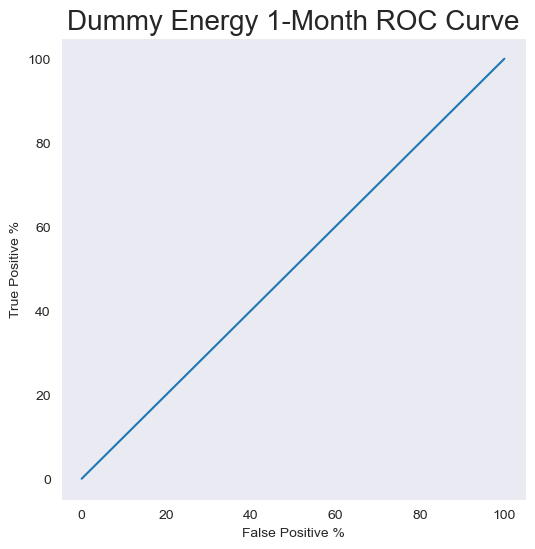

In [304]:
Energy.model_list[0].roc_curve()

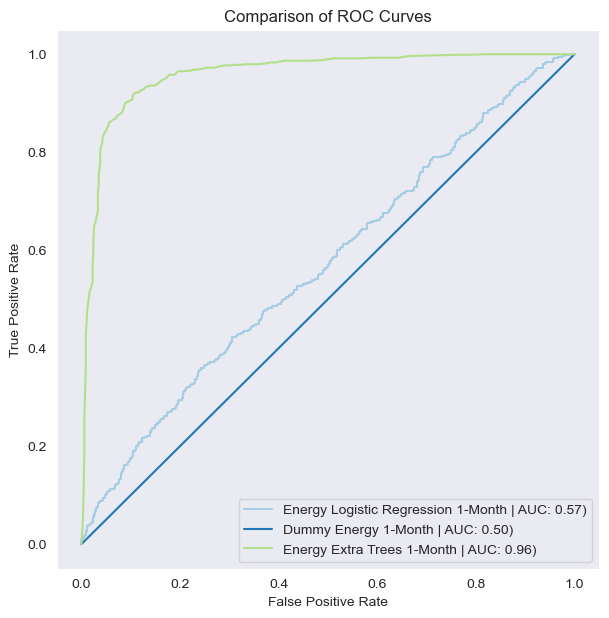

In [305]:
compare_curves([logreg3, Energy.model_list[0], etc3])

In [306]:
# Best overall models

all_data.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
121,"GridSearched Best-Model, 12-Month Technology",0.980231,0.981350,0.992506,0.986880,0.084918,0.987205,0.990222,0.992870,0.991544,0.052344,0.998891
118,Technology Random Forest 12-Month,0.978434,0.979596,0.991907,0.985694,0.077740,0.986532,0.990214,0.991979,0.991095,0.051671,0.998922
233,Real_Estate Extra Trees 6-Month,0.969419,0.977478,0.974914,0.976106,0.095903,0.986239,0.996466,0.982578,0.989474,0.143288,0.995300
266,"GridSearched Best-Model, 12-Month Communicatio...",0.985016,0.987254,0.990826,0.989015,0.092408,0.985075,0.982659,0.994152,0.988372,0.054820,0.997377
264,Communication_Services Extra Trees 12-Month,0.982516,0.985485,0.988991,0.987197,0.092167,0.985075,0.982659,0.994152,0.988372,0.046553,0.998704


In [307]:
all_data.loc[28, 'name']

'Energy Random Forest 1-Month'

# 2 out of 5 Top Models are in Communications Services, Tech (4total)

In [626]:
# Materials.model_list[-1].name = "GridSearch ETC 12-Month Materials"

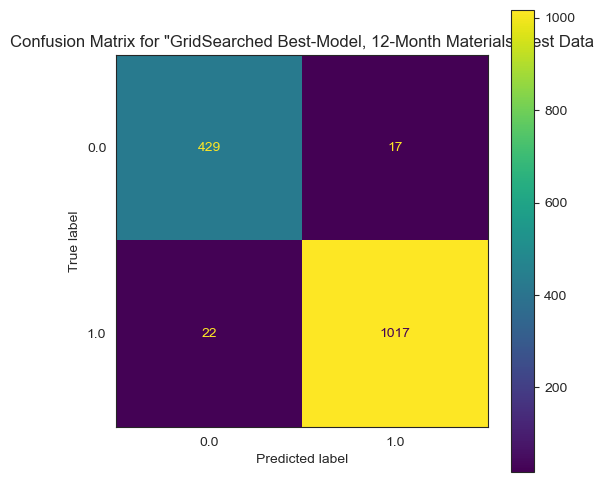

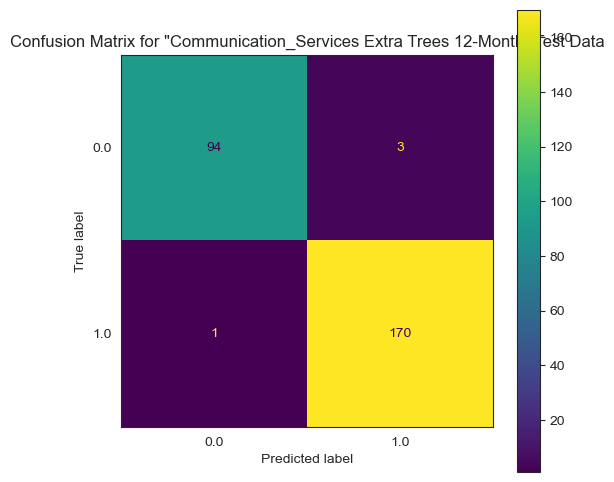

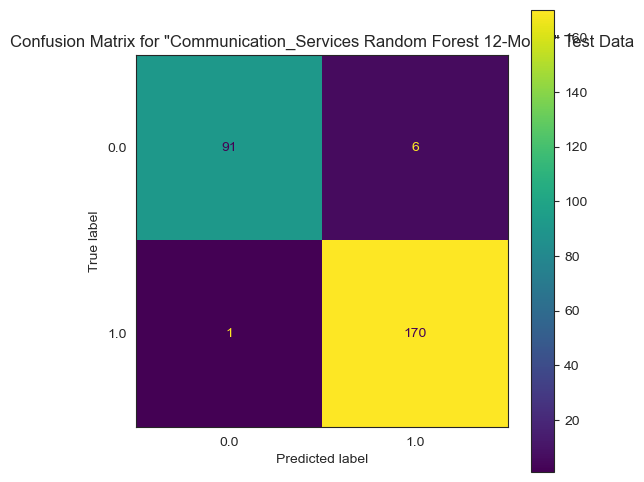

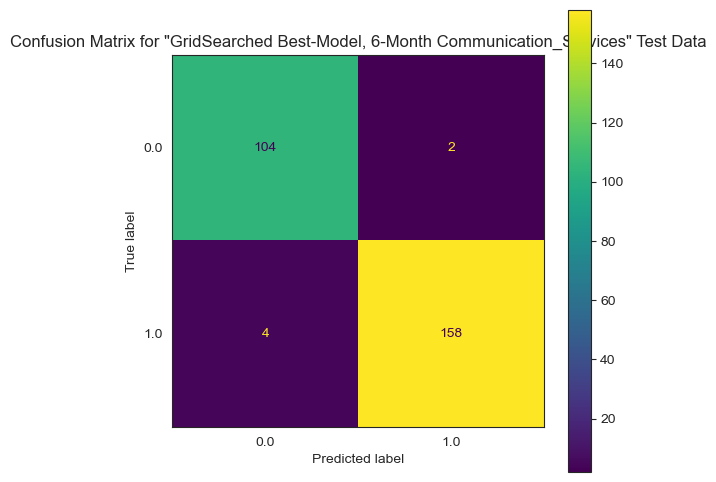

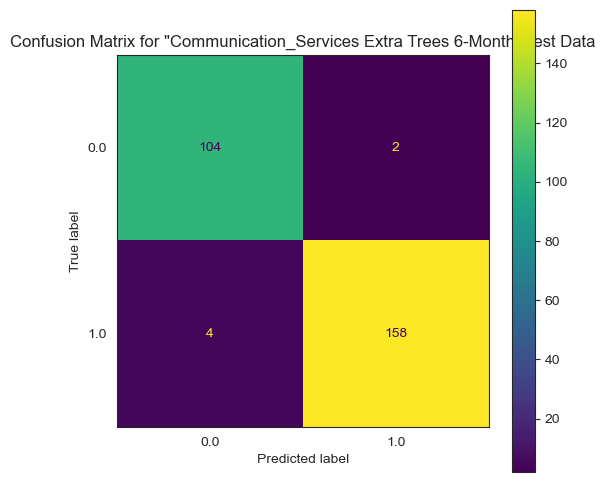

In [308]:
top_5_models = [Materials.model_list[-1], etc_CSrv_12, rfc_CSrv_12, grid_CSrv_6, etc_CSrv_6]
for i in top_5_models:
    i.confusion_matrix()

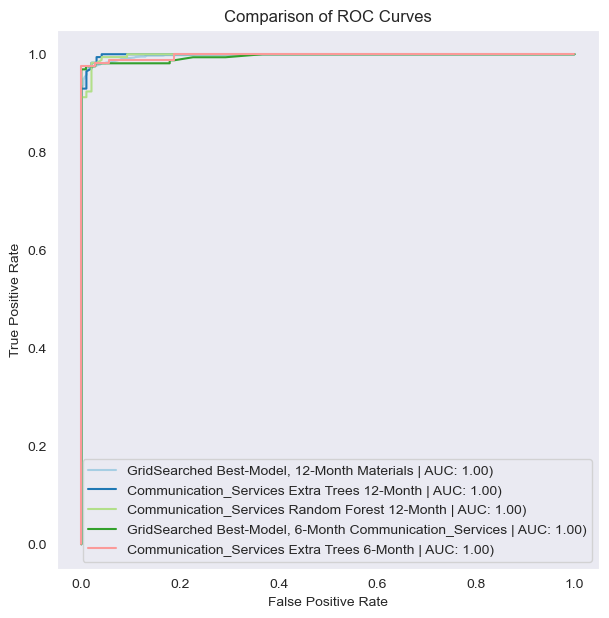

In [309]:
compare_curves(top_5_models)

In [325]:
len(Materials.model_list[4].model.named_steps['ct'].get_feature_names_out())

48

In [313]:
Importance.df

,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),Quarter_1,Quarter_2,Quarter_3,Quarter_4,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Materials 1-Month,0.044890,0.042906,0.040875,0.040902,0.037893,0.022596,0.029227,0.045234,0.015475,0.015633,0.015491,0.015779,0.015419,0.029040,0.036452,0.042583,0.043355,0.045168,0.043399,0.041740,0.042175,0.043671,0.022407,0.008054,0.008679,0.008086,0.008615,0.008225,0.008830,0.005291,0.005768,0.007023,8.573572e-03,0.010867,0.006627,0.008664,0.009519,0.006927,0.008633,0.012784,0.014564,0.019284,0.015009,0.008398,0.008487,0.006302,0.008166,0.006314
Materials 3-Month,0.041549,0.038883,0.041317,0.041996,0.041288,0.015714,0.046539,0.052163,0.008869,0.008845,0.009308,0.008089,0.009598,0.032032,0.024332,0.043753,0.039971,0.041239,0.041865,0.039677,0.037955,0.030861,0.014451,0.017342,0.018104,0.016444,0.014353,0.011371,0.008437,0.006605,0.007870,0.010041,1.300110e-02,0.007982,0.005486,0.007269,0.016000,0.007683,0.011310,0.021992,0.020624,0.029405,0.019624,0.004683,0.003118,0.003970,0.003398,0.003598
Materials 6-Month,0.041111,0.040615,0.038549,0.041320,0.035480,0.015791,0.060676,0.059790,0.007668,0.007579,0.007954,0.007367,0.007852,0.043915,0.021449,0.042883,0.041622,0.041164,0.042184,0.042523,0.036984,0.022893,0.012823,0.015442,0.013389,0.013923,0.024967,0.010452,0.006724,0.005107,0.006191,0.007275,9.175075e-03,0.008386,0.003732,0.004366,0.010425,0.006257,0.007727,0.026279,0.025873,0.035546,0.022017,0.002699,0.004072,0.002992,0.003444,0.003349
Materials 12-Month,0.043558,0.042014,0.041731,0.041565,0.041107,0.009551,0.081880,0.059024,0.003293,0.004235,0.003910,0.003309,0.003558,0.053218,0.011397,0.041829,0.048209,0.049204,0.045244,0.043951,0.033155,0.017345,0.009731,0.019346,0.020957,0.014935,0.025186,0.003912,0.005941,0.004294,0.004332,0.004156,6.151094e-03,0.005793,0.005394,0.005069,0.005096,0.006474,0.004522,0.024900,0.030834,0.034035,0.029423,0.001426,0.001662,0.001398,0.001304,0.001439
Energy 1-Month,0.039603,0.042283,0.040701,0.039026,0.034973,0.020339,0.039448,0.044089,0.014855,0.013553,0.014077,0.014393,0.013856,0.031040,0.033747,0.039289,0.039600,0.040403,0.041314,0.041687,0.041111,0.039689,0.021334,0.011887,0.012065,0.010380,0.009928,0.010435,0.008986,0.008949,0.009878,0.008291,1.087853e-02,0.009866,0.007726,0.012024,0.012421,0.007447,0.009484,0.017497,0.013816,0.018174,0.016657,0.006895,0.006334,0.005815,0.006795,0.006961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Real Estate 12-Month,0.062485,0.055302,0.048947,0.076653,0.050862,0.007538,0.055935,0.053593,0.005390,0.004922,0.004809,0.004907,0.005798,0.022917,0.014037,0.061205,0.050704,0.061522,0.048423,0.071036,0.018779,0.020853,0.008008,0.008058,0.009433,0.005527,0.002963,0.004150,0.002169,0.001572,0.002692,0.008063,5.044827e-03,0.007300,0.004336,0.004249,0.004141,0.002533,0.002281,0.025423,0.010009,0.046221,0.018639,0.002357,0.002043,0.002505,0.002208,0.001457
Communication Services 1-Month,0.033684,0.034958,0.029476,0.031966,0.028949,0.017550,0.043530,0.036925,0.012108,0.011590,0.013167,0.011106,0.012537,0.012395,0.032715,0.034897,0.034788,0.032684,0.030935,0.033840,0.031430,0.039973,0.015639,0.011195,0.011603,0.019135,0.019976,0.003715,0.006046,0.010112,0.014852,0.009908,5.876706e-03,0.004068,0.006407,0.011992,0.035107,0.011455,0.028158,0.010939,0.095670,0.022541,0.015795,0.005099,0.008545,0.005512,0.004599,0.004851
Communication Services 3-Month,0.032863,0.000203,0.013117,0.001509,0.000000,0.003422,0.33

In [315]:
# 12 Month Materials most important features

Importance.df.loc[Importance.df.index.str.contains("Materials")].T['Materials 12-Month'].sort_values(ascending=False)[:10]

GDP_Filled               0.081880
Interest_Rates           0.059024
garman_klass_vol         0.053218
20_day_SMA               0.049204
lower_bollinger_band     0.048209
one_up_bollinger_band    0.045244
upper_bollinger_band     0.043951
Adj Close                0.043558
Close                    0.042014
lowest_bollinger_band    0.041829
Name: Materials 12-Month, dtype: float64

In [316]:
# 6 Month Comms Services most important factors

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 6-Month"].sort_values(ascending=False)[:10]

GDP_Filled               0.113984
upper_bollinger_band     0.080058
20_day_SMA               0.064365
lower_bollinger_band     0.058721
Interest_Rates           0.058513
one_up_bollinger_band    0.053958
cycle_year_2             0.052361
ATR                      0.049061
Open                     0.044643
Adj Close                0.043613
Name: Communication Services 6-Month, dtype: float64

In [317]:
# 12 Month Comms Services most important factors

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 12-Month"].sort_values(ascending=False)[:10]

one_up_bollinger_band    0.085872
upper_bollinger_band     0.083756
cycle_year_1             0.069906
lowest_bollinger_band    0.067716
Adj Close                0.067031
Low                      0.063619
lower_bollinger_band     0.062773
20_day_SMA               0.062624
Close                    0.058278
High                     0.048913
Name: Communication Services 12-Month, dtype: float64

# Plotting Trees

After considering how difficult it would be to align each node with its actual splits, I have decided to rely on my feature importance collection created in the Importance() class.

In [318]:
from sklearn.tree import plot_tree

In [319]:
features = (Energy.model_list[23].model.named_steps["ct"].get_feature_names_out())
features_cleaned = [i.replace('num_pipe__', "").replace('cat_pipe__', "") for i in features]
features_cleaned[:5]

['Adj Close', 'Close', 'High', 'Low', 'Open']

In [320]:
Energy.model_list[23].name

'GridSearched Best-Model, 12-Month Energy'

In [324]:
Energy.model_df.sort_values(by="test_accuracy", ascending=False)[:3]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Energy",0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987,0.987988,0.056978,0.998055
21,Energy Extra Trees 12-Month,0.977987,0.980082,0.986714,0.983361,0.073745,0.983838,0.988978,0.987,0.987988,0.056978,0.998055
20,Energy Random Forest 12-Month,0.972148,0.977318,0.980585,0.978916,0.079379,0.979798,0.982107,0.988,0.985045,0.072762,0.997373


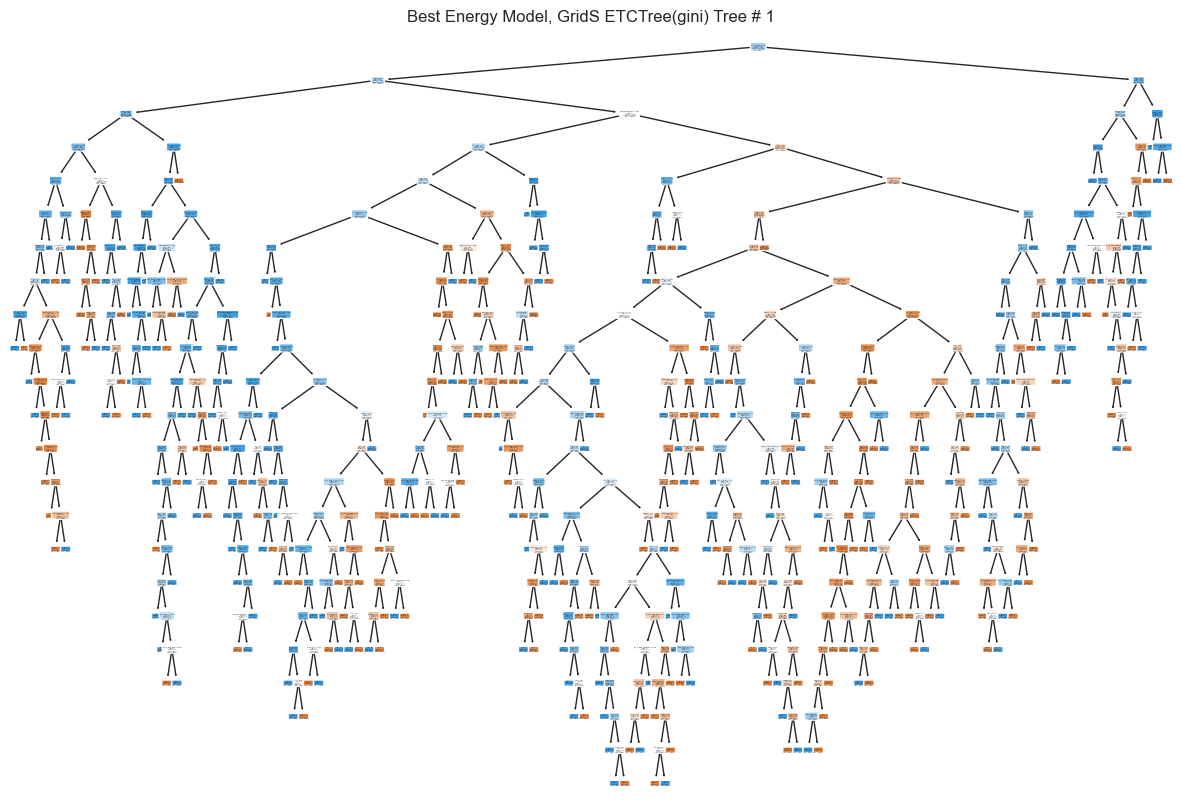

In [321]:
# Visualize the structure of one of the decision trees (e.g., the first tree)
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
plot_tree(Energy.model_list[23].model.named_steps["model"].estimators_[0], filled=True, \
          feature_names=features_cleaned, class_names=["Class 0", "Class 1"], rounded=True)
plt.title("Best Energy Model, GridS ETCTree(gini) Tree # 1")
plt.show()

In [618]:
Energy.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Energy",0.980361,0.983175,0.987150,0.985152,0.063432,0.980589,0.982249,0.989076,0.985651,0.056005,0.998331
21,Energy Extra Trees 12-Month,0.979468,0.982168,0.986812,0.984482,0.068770,0.980589,0.981299,0.990070,0.985665,0.055483,0.998220
20,Energy Random Forest 12-Month,0.974559,0.977501,0.984106,0.980788,0.076852,0.976573,0.978346,0.987090,0.982699,0.071217,0.997273
22,Energy XGBoost 12-Month,0.970987,0.974820,0.981399,0.978094,0.087563,0.971888,0.973503,0.985104,0.979269,0.083846,0.996035
17,"GridSearched Best-Model, 6-Month Energy",0.964739,0.975521,0.969359,0.972410,0.133980,0.968541,0.974950,0.977889,0.976417,0.093572,0.995605


# Time Stats for y_preds == 1

In [740]:
Energy.model_list[23].X_test

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,Quarter,cycle_year
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-16,69.142426,100.320000,100.360001,99.199997,99.230003,8167400.0,-0.050351,61.648384,67.863704,68.329122,68.794540,69.259959,69.725377,0.969786,0.478896,564.7138,17192.019,0.0002,0.0032,-0.0060,0.0036,0.0018,0.0016,3,2
2022-08-18,75.785782,79.480003,79.559998,78.120003,78.260002,23433000.0,-0.000232,57.574576,67.609407,69.784115,71.958823,74.133531,76.308239,2.477345,1.036360,1775.8882,24654.603,0.0261,0.0027,0.0035,0.0046,0.0079,0.0008,3,2
2018-05-30,58.681026,76.599998,76.940002,74.959999,74.989998,23022200.0,-0.022893,57.596273,55.720652,57.057584,58.394515,59.731447,61.068378,1.425199,0.736155,1350.9663,20037.088,0.0190,0.0131,0.0004,0.0037,-0.0072,0.0018,2,2
2010-12-01,41.664169,64.570000,64.720001,63.740002,63.740002,19973800.0,-0.069714,65.429662,39.228032,39.830361,40.432690,41.035019,41.637348,1.250325,0.673937,832.1918,15309.474,0.0016,0.0212,-0.0010,0.0000,-0.0039,0.0037,4,2
2017-01-03,56.082924,76.169998,76.809998,75.360001,76.110001,24623100.0,-0.035836,60.249312,55.155633,55.564350,55.973067,56.381784,56.790501,1.032110,0.635485,1380.9354,19089.379,0.0053,0.0083,-0.0011,0.0006,-0.0020,0.0026,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-03,54.043438,73.400002,73.779999,72.629997,73.059998,11828600.0,-0.034990,46.439018,53.318475,53.971599,54.624724,55.277848,55.930972,0.989261,-0.361579,639.2582,19089.379,0.0050,0.0082,0.0062,0.0075,-0.0050,0.0031,1,1
2010-11-12,40.612400,62.939999,63.480000,62.380001,63.180000,17874300.0,-0.075286,70.820151,36.822095,37.931162,39.040228,40.149294,41.258360,1.051431,1.012710,725.9182,15309.474,0.0013,-0.0129,-0.0047,-0.0005,0.0017,-0.0004,4,2
2019-02-28,51.143764,65.250000,66.010002,64.839996,65.919998,11249400.0,-0.024723,55.107499,49.315728,50.130398,50.945067,51.759737,52.574406,1.076548,0.661178,575.3367,20917.867,0.0240,-0.0031,-0.0002,-0.0024,0.0029,0.0016,1,3


In [739]:
targets = df[df["Ticker"] == 'XLE'][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', 'Twelve_Month_Change']]

In [745]:
try_out_df = Energy.model_list[23].X_test.join(targets)

In [753]:
predictions = list(Energy.model_list[23].y_pred)

In [754]:
try_out_df["Y_PREDS"] = predictions
try_out_df.head(2)

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,Y_PREDS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-16,69.142426,100.320000,100.360001,99.199997,99.230003,8167400.0,-0.050351,61.648384,67.863704,68.329122,68.794540,69.259959,69.725377,0.969786,0.478896,564.7138,17192.019,0.0002,0.0032,-0.0060,0.0036,0.0018,0.0016,3,2,-0.036782,-0.178409,-0.241559,-0.250746,0.0
2022-08-18,75.785782,79.480003,79.559998,78.120003,78.260002,23433000.0,-0.000232,57.574576,67.609407,69.784115,71.958823,74.133531,76.308239,2.477345,1.036360,1775.8882,24654.603,0.0261,0.0027,0.0035,0.0046,0.0079,0.0008,3,2,-0.012500,0.165438,0.080296,0.163271,1.0


In [761]:
try_out_df[try_out_df["Y_PREDS"] == 1][['One_Month_Change', 'Three_Month_Change',
       'Six_Month_Change', 'Twelve_Month_Change']].describe()

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1014.000000,1014.000000,1014.000000,1014.000000
mean,0.022356,0.068303,0.129365,0.259073
std,0.071422,0.107046,0.135993,0.185235
min,-0.353647,-0.241060,-0.225253,-0.039360
25%,-0.020025,0.002462,0.042883,0.125241
50%,0.023064,0.056387,0.109650,0.219052
75%,0.064840,0.125398,0.200028,0.358770
max,0.327986,0.579674,0.774847,1.113624


In [762]:
df.head(2)

,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),...,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-29,XLB,12.173974,21.109375,21.109375,20.953125,20.953125,400.0,-0.113866,45.359138,11.895115,12.260721,12.626327,12.991933,13.357539,0.428209,-0.181912,0.0049,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,1.0,1.0,1.0,1.0,1,3,0.003701,0.304892,0.224778,0.120443
1999-01-29,XLE,11.670676,21.812500,21.812500,21.437500,21.687500,18600.0,-0.148177,31.112282,11.538889,11.886099,12.233308,12.580518,12.927728,0.420353,-0.327213,0.2171,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.0,1.0,1.0,1.0,1,3,-0.018625,0.321352,0.294085,0.272486


In [764]:
Energy.model_list[5].name

'GridSearched Best-Model, 1-Month Energy'

In [765]:
Energy.model_df.iloc[:6].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Energy",0.906715,0.914735,0.923315,0.918987,0.271652,0.914993,0.928656,0.920991,0.924808,0.239967,0.969846
3,Energy Extra Trees 1-Month,0.905601,0.913060,0.923317,0.918089,0.266331,0.914324,0.925532,0.923349,0.924439,0.264940,0.969174
2,Energy Random Forest 1-Month,0.884398,0.884228,0.918643,0.901070,0.348565,0.890228,0.891304,0.918632,0.904762,0.323588,0.953783
4,Energy XGBoost 1-Month,0.837532,0.849890,0.870382,0.859845,0.435341,0.845382,0.858304,0.871462,0.864833,0.417102,0.911323
1,Energy Logistic Regression 1-Month,0.569291,0.584381,0.861042,0.696187,0.677679,0.570281,0.580595,0.875000,0.698024,0.674558,0.576213
0,Dummy Energy 1-Month,0.573310,0.573310,1.000000,0.728794,15.379481,0.567604,0.567604,1.000000,0.724167,15.585141,0.500000


In [806]:
def describe_predictions(model, ticker, df, cat=1):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()

In [816]:
describe_predictions(Energy.model_list[5], "XLE", df, 0)

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,653.000000,653.000000,653.000000,653.000000
mean,-0.052505,-0.034669,-0.005166,0.043192
std,0.061966,0.119808,0.170799,0.250762
min,-0.556992,-0.599644,-0.555319,-0.509324
25%,-0.070320,-0.093086,-0.110593,-0.148314
50%,-0.040235,-0.025241,0.010344,0.025348
75%,-0.016723,0.033757,0.089450,0.201292
max,0.077553,0.306647,0.689210,0.821258


In [814]:
pd.Series(Energy.model_list[5].y_pred).value_counts()

1.0    841
0.0    653
Name: count, dtype: int64

In [817]:
Financials.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
21,Financials Extra Trees 12-Month,0.979023,0.981827,0.985269,0.983537,0.066500,0.981258,0.987355,0.983211,0.985279,0.055513,0.998686
22,Financials XGBoost 12-Month,0.967866,0.974769,0.974749,0.974721,0.095076,0.979250,0.985263,0.982162,0.983710,0.066435,0.997269
20,Financials Random Forest 12-Month,0.972776,0.978630,0.978609,0.978597,0.094470,0.977912,0.986258,0.979014,0.982622,0.081450,0.997924
15,Financials Extra Trees 6-Month,0.963849,0.970263,0.972963,0.971603,0.140160,0.971888,0.980573,0.976578,0.978571,0.089501,0.995073


In [819]:
describe_predictions(Financials.model_list[23], "XLF", df)

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,950.000000,950.000000,950.000000,950.000000
mean,0.013592,0.048445,0.105341,0.203030
std,0.075443,0.106085,0.127367,0.159059
min,-0.391374,-0.433875,-0.284383,-0.019450
25%,-0.016996,0.001818,0.033155,0.097900
50%,0.016515,0.046507,0.093335,0.169777
75%,0.045444,0.097120,0.166316,0.269558
max,0.556485,0.736442,1.064366,1.199291
